TODO
# faire des visualisations multivariés. densité avec census

#Import drive

In [677]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries

In [678]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import os
# Plz install these packages if you want to make choropleth map.
!pip install plotly-geo
!pip install pyshp
!pip install geopandas
!pip install probatus


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [679]:
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

import plotly.figure_factory as ff
import geopandas
import shapely
import warnings
warnings.filterwarnings("ignore")

In [680]:
#preprocessing normalisation for modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

In [681]:
from probatus.utils import Scorer
from sklearn.metrics import make_scorer

In [682]:
#algorithm for modelling in classification case
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [683]:
from sklearn.linear_model import LinearRegression

#Functions

In [684]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [685]:
def hist_box_plot(df, col = "energy_100g", 
                  subtitle ="Visualisation de la distribution de la variable energy_100g",
                  hist_title = 'Histogramme de la variable energy_100g',
                  color = 'skyblue'):
  fig, ax =plt.subplots(1,2, sharex=True, figsize=(15,6))
  fig.suptitle(subtitle)
  sns.histplot(df, x=col, bins="sturges", kde=True, ax = ax[0])
  ax[0].set_xlabel(col)
  ax[0].set_ylabel("Nombre d'observations")
  ax[0].set_title(hist_title)

  #sns.boxplot(df, x=col, color= color, ax = ax[1])
  sns.boxplot(df[col], x=col, color= color, ax = ax[1])
  ax[1].set_title(f'Boite à moustache de la variable {col}')
  ax[1].set_xlabel(col)
  plt.show()

  print('-' * 223)
  print("Indicateurs de distribution")
  print(df[col].describe())


##Metrics

In [686]:
#a : y_true et f : y_pred
def SMAPE_(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [687]:
def SMAPE(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)

#Test metrics

In [688]:
df_true = pd.DataFrame([0,1])
df_pred =pd.DataFrame([0, 2])

In [689]:
SMAPE(df_true,df_pred)

0    33.333333
dtype: float64

In [690]:
#smape(df_true,df_pred)

#Param

In [691]:
BASE = '/content/drive/MyDrive/OpenClassRoom/P8/Data'

#Read data

In [692]:
base_filename='sample_submission.csv'
data_sub = os.path.join(BASE, base_filename)

In [693]:
sample_sub = pd.read_csv(data_sub)
print(sample_sub.columns)
print(sample_sub.shape)
sample_sub.head()

Index(['row_id', 'microbusiness_density'], dtype='object')
(25080, 2)


row_id  microbusiness_density
0  1001_2022-11-01               3.817671
1  1003_2022-11-01               3.817671
2  1005_2022-11-01               3.817671
3  1007_2022-11-01               3.817671
4  1009_2022-11-01               3.817671

##Census starter

In [694]:
base_filename='census_starter.csv'
data_census = os.path.join(BASE, base_filename)

In [695]:
#census = pd.read_csv("/content/drive/MyDrive/OpenClassRoom/P8/Data/census_starter.csv")
census = pd.read_csv(data_census)
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  cfips  \
0         76.6         78.9         80.6         82.7         85.5   1001   
1         74.5         78.1         81.8         85.1         87.9   1003   
2         57.2         60.4         60.5         64.6         64.6   1005   
3         62.0         66.1         69.2         76.1         74.6   1007   
4         65.8         68.5         73.0         79.6         81.0   1009   

   pct_college_2017  pct_college_2018  pct_college_2019  pct_college_2020  \
0              14.5              15.9              16.1              16.7   
1              20.4              20.7              21.0              20.2   
2               7.6               7.8               7.6               7.3   
3               8.1               7.6               6.5               7.4   
4               8.7               8.1               8.6               8.9   

   pct_college_2021  pct_foreign_born_2017  pct_foreign_born_2018  \
0              16.4                    2.1                    2.0   
1              20.6                    3.2                    3.4   
2               6.7                    2.7                    2.5   
3               7.9                    1.0                    1.4   
4               9.3                    4.5                    4.4   

   pct_foreign_born_2019  pct_foreign_born_2020  pct_foreign_born_2021  \
0                    2.3                    2.3                    2.1   
1                    3.7                    3.4                    3.5   
2                    2.7                    2.6                    2.6   
3                    1.5                    1.6                    1.1   
4                    4.5                    4.4                    4.5   

   pct_it_workers_2017  pct_it_workers_2018  pct_it_workers_2019  \
0                  1.3                  1.1                  0.7   
1                  1.4                  1.3                  1.4   
2                  0.5                  0.3                  0.8   
3                  1.2                  1.4                  1.6   
4                  1.3                  1.4                  0.9   

   pct_it_workers_2020  pct_it_workers_2021  median_hh_inc_2017  \
0                  0.6                  1.1               55317   
1                  1.0                  1.3               52562   
2                  1.1                  0.8               33368   
3                  1.7                  2.1               43404   
4                  1.1                  0.9               47412   

   median_hh_inc_2018  median_hh_inc_2019  median_hh_inc_2020  \
0             58786.0               58731             57982.0   
1             55962.0               58320             61756.0   
2             34186.0               32525             34990.0   
3             45340.0               47542             51721.0   
4             48695.0               49358             48922.0   

   median_hh_inc_2021  
0             62660.0  
1             64346.0  
2             36422.0  
3             54277.0  
4             52830.0

In [696]:
census.shape

(3142, 26)

In [697]:
census.query("cfips == 61")

Empty DataFrame
Columns: [pct_bb_2017, pct_bb_2018, pct_bb_2019, pct_bb_2020, pct_bb_2021, cfips, pct_college_2017, pct_college_2018, pct_college_2019, pct_college_2020, pct_college_2021, pct_foreign_born_2017, pct_foreign_born_2018, pct_foreign_born_2019, pct_foreign_born_2020, pct_foreign_born_2021, pct_it_workers_2017, pct_it_workers_2018, pct_it_workers_2019, pct_it_workers_2020, pct_it_workers_2021, median_hh_inc_2017, median_hh_inc_2018, median_hh_inc_2019, median_hh_inc_2020, median_hh_inc_2021]
Index: []

In [901]:
census.cfips.nunique()

3142

##describe

In [698]:
census.describe()

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  \
count  3142.000000  3142.000000  3142.000000  3141.000000  3141.000000   
mean     69.920401    72.690866    75.398600    78.543298    80.539096   
std       9.702052     9.255863     8.846665     8.250864     7.889931   
min      24.500000    25.700000    34.800000    33.300000    37.000000   
25%      64.200000    67.425000    70.500000    74.100000    76.400000   
50%      70.700000    73.600000    76.450000    79.600000    81.700000   
75%      76.400000    78.800000    81.400000    84.100000    85.900000   
max      94.600000    95.500000    96.000000    97.100000    97.600000   

              cfips  pct_college_2017  pct_college_2018  pct_college_2019  \
count   3142.000000       3142.000000       3142.000000       3142.000000   
mean   30383.649268         13.813399         14.005379         14.240452   
std    15162.508374          5.586649          5.630199          5.689780   
min     1001.000000          2.400000          0.000000          0.000000   
25%    18177.500000          9.700000          9.900000         10.100000   
50%    29176.000000         12.800000         13.000000         13.250000   
75%    45080.500000         16.800000         17.100000         17.300000   
max    56045.000000         43.700000         48.000000         45.400000   

       pct_college_2020  pct_college_2021  pct_foreign_born_2017  \
count       3141.000000       3141.000000            3142.000000   
mean          14.631328         14.851226               4.702451   
std            5.776940          5.832285               5.696355   
min            0.000000          0.000000               0.000000   
25%           10.500000         10.600000               1.400000   
50%           13.600000         13.800000               2.700000   
75%           17.900000         18.000000               5.700000   
max           43.000000         43.700000              52.900000   

       pct_foreign_born_2018  pct_foreign_born_2019  pct_foreign_born_2020  \
count            3142.000000            3142.000000            3141.000000   
mean                4.724507               4.769096               4.748520   
std                 5.705591               5.734774               5.684018   
min                 0.000000               0.000000               0.000000   
25%                 1.400000               1.400000               1.400000   
50%                 2.700000               2.700000               2.800000   
75%                 5.700000               5.700000               5.700000   
max                53.300000              53.700000              54.000000   

       pct_foreign_born_2021  pct_it_workers_2017  pct_it_workers_2018  \
count            3141.000000          3142.000000          3141.000000   
mean                4.743680             1.427148             1.382171   
std                 5.724552             0.986985             0.942777   
min                 0.000000             0.000000             0.000000   
25%                 1.400000             0.800000             0.800000   
50%                 2.700000             1.300000             1.300000   
75%                 5.700000             1.900000             1.800000   
max                54.000000            17.400000            11.700000   

       pct_it_workers_2019  pct_it_workers_2020  pct_it_workers_2021  \
count          3142.000000          3141.000000          3141.000000   
mean              1.338956             1.309265             1.272684   
std               0.940891             0.990342             0.968579   
min               0.000000             0.000000             0.000000   
25%               0.700000             0.700000             0.600000   
50%               1.200000             1.200000             1.100000   
75%               1.800000             1.800000             1.700000   
max              10.500000            15.200000            15.200000   

       median_

##Nan values

In [699]:
census.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              1
pct_bb_2021              1
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         1
pct_college_2021         1
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    1
pct_foreign_born_2021    1
pct_it_workers_2017      0
pct_it_workers_2018      1
pct_it_workers_2019      0
pct_it_workers_2020      1
pct_it_workers_2021      1
median_hh_inc_2017       0
median_hh_inc_2018       1
median_hh_inc_2019       0
median_hh_inc_2020       2
median_hh_inc_2021       2
dtype: int64

In [700]:
census[census.isna().any(axis=1)]

pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  pct_bb_2021  cfips  \
92           80.5         79.1         80.4          NaN          NaN   2261   
1816         49.1         52.1         57.6         60.7         63.5  35039   
2644         66.3         66.6         61.2         63.2         70.1  48243   
2673         64.5         72.7         73.3         96.8         97.0  48301   

      pct_college_2017  pct_college_2018  pct_college_2019  pct_college_2020  \
92                23.1              19.0              16.5               NaN   
1816              12.0              12.5              12.6              10.6   
2644              18.4              16.0              10.8              14.3   
2673               4.7               0.0               0.0               0.0   

      pct_college_2021  pct_foreign_born_2017  pct_foreign_born_2018  \
92                 NaN                    4.9                    6.3   
1816              10.1                    4.5                    3.7   
2644              10.9                   22.4                   14.9   
2673               0.0                   10.8                   15.7   

      pct_foreign_born_2019  pct_foreign_born_2020  pct_foreign_born_2021  \
92                      6.6                    NaN                    NaN   
1816                    4.2                    4.5                    4.8   
2644                   20.9                   10.1                   12.7   
2673                   12.2                    0.0                    1.2   

      pct_it_workers_2017  pct_it_workers_2018  pct_it_workers_2019  \
92                    3.3                  3.9                  5.3   
1816                  0.8                  NaN                  0.8   
2644                  0.0                  0.0                  0.0   
2673                  0.0                  0.0                  0.0   

      pct_it_workers_2020  pct_it_workers_2021  median_hh_inc_2017  \
92                    NaN                  NaN               86019   
1816                  0.4                  0.7               33422   
2644                  0.0                  0.0               46534   
2673                  0.0                  0.0               80938   

      median_hh_inc_2018  median_hh_inc_2019  median_hh_inc_2020  \
92               82306.0               79867                 NaN   
1816                 NaN               39952             42264.0   
2644             53194.0               53088                 NaN   
2673             81875.0               83750             44076.0   

      median_hh_inc_2021  
92                   NaN  
1816             46994.0  
2644             38659.0  
2673                 NaN

 Replace these nan values with previous values of this type. For example, nan value in pct_bb_2020 I will replace the on value in pct_bb_2019

In [701]:
census.at[92, "pct_bb_2020"] = census.at[92, "pct_bb_2019"]
census.at[92, "pct_bb_2021"] = census.at[92, "pct_bb_2019"]

census.at[92, "pct_college_2020"] = census.at[92, "pct_college_2019"]
census.at[92, "pct_college_2021"] = census.at[92, "pct_college_2019"]

census.at[92, "pct_foreign_born_2020"] = census.at[92, "pct_foreign_born_2019"]
census.at[92, "pct_foreign_born_2021"] = census.at[92, "pct_foreign_born_2019"]

census.at[92, "pct_it_workers_2020"] = census.at[92, "pct_it_workers_2019"]
census.at[92, "pct_it_workers_2021"] = census.at[92, "pct_it_workers_2019"]

census.at[92, "median_hh_inc_2020"] = census.at[92, "median_hh_inc_2019"]
census.at[92, "median_hh_inc_2021"] = census.at[92, "median_hh_inc_2019"]

In [702]:
census.at[1816, "pct_it_workers_2018"] = census.at[1816, "pct_it_workers_2017"]
census.at[1816, "median_hh_inc_2018"] = census.at[1816, "median_hh_inc_2017"]
census.at[2644, "median_hh_inc_2020"] = census.at[2644, "median_hh_inc_2019"]
census.at[2673, "median_hh_inc_2021"] = census.at[2673, "median_hh_inc_2020"]
census.at[1816, "pct_it_workers_2018"] = census.at[1816, "pct_it_workers_2017"]
census.at[1816, "median_hh_inc_2018"] = census.at[1816, "median_hh_inc_2017"]
census.at[2644, "median_hh_inc_2020"] = census.at[2644, "median_hh_inc_2019"]
census.at[2673, "median_hh_inc_2021"] = census.at[2673, "median_hh_inc_2020"]

In [703]:
census[census.isna().any(axis=1)]

Empty DataFrame
Columns: [pct_bb_2017, pct_bb_2018, pct_bb_2019, pct_bb_2020, pct_bb_2021, cfips, pct_college_2017, pct_college_2018, pct_college_2019, pct_college_2020, pct_college_2021, pct_foreign_born_2017, pct_foreign_born_2018, pct_foreign_born_2019, pct_foreign_born_2020, pct_foreign_born_2021, pct_it_workers_2017, pct_it_workers_2018, pct_it_workers_2019, pct_it_workers_2020, pct_it_workers_2021, median_hh_inc_2017, median_hh_inc_2018, median_hh_inc_2019, median_hh_inc_2020, median_hh_inc_2021]
Index: []

In [704]:
census.isna().sum()

pct_bb_2017              0
pct_bb_2018              0
pct_bb_2019              0
pct_bb_2020              0
pct_bb_2021              0
cfips                    0
pct_college_2017         0
pct_college_2018         0
pct_college_2019         0
pct_college_2020         0
pct_college_2021         0
pct_foreign_born_2017    0
pct_foreign_born_2018    0
pct_foreign_born_2019    0
pct_foreign_born_2020    0
pct_foreign_born_2021    0
pct_it_workers_2017      0
pct_it_workers_2018      0
pct_it_workers_2019      0
pct_it_workers_2020      0
pct_it_workers_2021      0
median_hh_inc_2017       0
median_hh_inc_2018       0
median_hh_inc_2019       0
median_hh_inc_2020       0
median_hh_inc_2021       0
dtype: int64

In [705]:
census.cfips.nunique()

3142

##dtypes

In [706]:
census.dtypes

pct_bb_2017              float64
pct_bb_2018              float64
pct_bb_2019              float64
pct_bb_2020              float64
pct_bb_2021              float64
cfips                      int64
pct_college_2017         float64
pct_college_2018         float64
pct_college_2019         float64
pct_college_2020         float64
pct_college_2021         float64
pct_foreign_born_2017    float64
pct_foreign_born_2018    float64
pct_foreign_born_2019    float64
pct_foreign_born_2020    float64
pct_foreign_born_2021    float64
pct_it_workers_2017      float64
pct_it_workers_2018      float64
pct_it_workers_2019      float64
pct_it_workers_2020      float64
pct_it_workers_2021      float64
median_hh_inc_2017         int64
median_hh_inc_2018       float64
median_hh_inc_2019         int64
median_hh_inc_2020       float64
median_hh_inc_2021       float64
dtype: object

##Viz pct_college_2021

In [707]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(census, geojson=counties, locations='cfips', color='pct_college_2021',
                           color_continuous_scale="Viridis",
                           range_color=(0, 43),
                           scope="usa")
                           #labels={'unemp':'unemployment rate'}

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

##train

In [708]:
base_filename='train.csv'
data_train = os.path.join(BASE, base_filename)
train = pd.read_csv(data_train)
train

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  
0                    3.007682    1249  
1                    2.884870    1198  
2                    3.055843    1269  
3                    2.993233    1243  
4                    2.993233    1243  
...                       ...     ...  
122260               1.803249     101  
122261               1.803249     101  
122262               1.785395     100  
122263               1.785395     100  
122264               1.785395     100  

[122265 rows x 7 columns]

In [709]:
train.cfips.nunique()

3135

In [710]:
train.describe()

cfips  microbusiness_density        active
count  122265.000000          122265.000000  1.222650e+05
mean    30376.037640               3.817671  6.442858e+03
std     15143.508721               4.991087  3.304001e+04
min      1001.000000               0.000000  0.000000e+00
25%     18177.000000               1.639344  1.450000e+02
50%     29173.000000               2.586543  4.880000e+02
75%     45077.000000               4.519231  2.124000e+03
max     56045.000000             284.340030  1.167744e+06

In [711]:
train.first_day_of_month.min()

'2019-08-01'

In [712]:
train.first_day_of_month.max()

'2022-10-01'

In [713]:
train.isna().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

In [897]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(train, geojson=counties, locations='cfips', color='microbusiness_density',
                           color_continuous_scale="Viridis",
                           range_color=(0, 5),
                           scope="usa",
                           title="Latest densities of each county")
                           #labels={'unemp':'unemployment rate'}

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

##Test

In [715]:
base_filename='test.csv'
data_test = os.path.join(BASE, base_filename)
test = pd.read_csv(data_test)
test

row_id  cfips first_day_of_month
0       1001_2022-11-01   1001         2022-11-01
1       1003_2022-11-01   1003         2022-11-01
2       1005_2022-11-01   1005         2022-11-01
3       1007_2022-11-01   1007         2022-11-01
4       1009_2022-11-01   1009         2022-11-01
...                 ...    ...                ...
25075  56037_2023-06-01  56037         2023-06-01
25076  56039_2023-06-01  56039         2023-06-01
25077  56041_2023-06-01  56041         2023-06-01
25078  56043_2023-06-01  56043         2023-06-01
25079  56045_2023-06-01  56045         2023-06-01

[25080 rows x 3 columns]

##concat train test

In [716]:
print(train.shape, test.shape, sample_sub.shape)
#identify train and test
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw

(122265, 7) (25080, 3) (25080, 2)


row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
147340  56045_2023-02-01  56045             NaN      NaN         2023-02-01   
147341  56045_2023-03-01  56045             NaN      NaN         2023-03-01   
147342  56045_2023-04-01  56045             NaN      NaN         2023-04-01   
147343  56045_2023-05-01  56045             NaN      NaN         2023-05-01   
147344  56045_2023-06-01  56045             NaN      NaN         2023-06-01   

        microbusiness_density  active  istest  
0                    3.007682  1249.0       0  
1                    2.884870  1198.0       0  
2                    3.055843  1269.0       0  
3                    2.993233  1243.0       0  
4                    2.993233  1243.0       0  
...                       ...     ...     ...  
147340                    NaN     NaN       1  
147341                    NaN     NaN       1  
147342                    NaN     NaN       1  
147343                    NaN     NaN       1  
147344                    NaN     NaN       1  

[147345 rows x 8 columns]

In [717]:
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
#annee
raw["year"] = raw["first_day_of_month"].dt.year
#mois
raw["month"] = raw["first_day_of_month"].dt.month
#identifie/encode le couple cfips row_id par une valeur num
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
#identifie/encode le couple county state par une valeur unique
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
#identifie/encode state par une valeur unique
raw['state_i'] = raw['state'].factorize()[0]
raw

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
147340  56045_2023-02-01  56045   Weston County  Wyoming         2023-02-01   
147341  56045_2023-03-01  56045   Weston County  Wyoming         2023-03-01   
147342  56045_2023-04-01  56045   Weston County  Wyoming         2023-04-01   
147343  56045_2023-05-01  56045   Weston County  Wyoming         2023-05-01   
147344  56045_2023-06-01  56045   Weston County  Wyoming         2023-06-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
147340                    NaN     NaN       1  2023      2      42      3134   
147341                    NaN     NaN       1  2023      3      43      3134   
147342                    NaN     NaN       1  2023      4      44      3134   
147343                    NaN     NaN       1  2023      5      45      3134   
147344                    NaN     NaN       1  2023      6      46      3134   

        state_i  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
147340       50  
147341       50  
147342       50  
147343       50  
147344       50  

[147345 rows x 13 columns]

In [718]:
#dcount correspond au même mois/année
raw.dcount.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [719]:
raw.query("dcount==46").first_day_of_month.unique()

array(['2023-06-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [720]:
raw.query("dcount==46").cfips.unique()

array([ 1001,  1003,  1005, ..., 56041, 56043, 56045])

##merge census et train test

In [721]:
# merge census data with train-test dataset. 
df_all = raw.merge(census, on = 'cfips', how='left')
df_all

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
147340  56045_2023-02-01  56045   Weston County  Wyoming         2023-02-01   
147341  56045_2023-03-01  56045   Weston County  Wyoming         2023-03-01   
147342  56045_2023-04-01  56045   Weston County  Wyoming         2023-04-01   
147343  56045_2023-05-01  56045   Weston County  Wyoming         2023-05-01   
147344  56045_2023-06-01  56045   Weston County  Wyoming         2023-06-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
147340                    NaN     NaN       1  2023      2      42      3134   
147341                    NaN     NaN       1  2023      3      43      3134   
147342                    NaN     NaN       1  2023      4      44      3134   
147343                    NaN     NaN       1  2023      5      45      3134   
147344                    NaN     NaN       1  2023      6      46      3134   

        state_i  pct_bb_2017  pct_bb_2018  pct_bb_2019  pct_bb_2020  \
0             0         76.6         78.9         80.6         82.7   
1             0         76.6         78.9         80.6         82.7   
2             0         76.6         78.9         80.6         82.7   
3             0         76.6         78.9         80.6         82.7   
4             0         76.6         78.9         80.6         82.7   
...         ...          ...          ...          ...          ...   
147340       50         71.1         73.3         76.8         79.7   
147341       50         71.1         73.3         76.8         79.7   
147342       50         71.1         73.3         76.8         79.7   
147343       50         71.1         73.3         76.8         79.7   
147344       50         71.1         73.3         76.8         79.7   

        pct_bb_2021  pct_college_2017  pct_college_2018  pct_college_2019  \
0              85.5              14.5              15.9              16.1   
1              85.5              14.5              15.9              16.1   
2              85.5              14.5              15.9              16.1   
3              85.5              14.5              15.9              16.1   
4              85.5              14.5              15.9              16.1   
...             ...               ...               ...               ...   
147340         81.3              14.1              13.5              13.4   
147341         81.3              14.1              13.5              13.4   
147342         81.3              14.1              13.5              13.4   
147343         81.3              14.1              13.5              13.4   
147344         81.3              14.1              13.5              13.4   

        pct_college_2020  pct_college_2021  pct_foreign_born_2017  \
0                   16.7              16.4                    2.1   
1                   16.7              16.4                    2.1   
2                   16.7              16.4                    2.1   
3                   16.7              16.4            

In [722]:
# add 2-year lag census data to each rows 

conditions = [df_all['year']==2019,df_all['year']==2020,df_all['year']==2021, df_all['year']==2022, df_all['year']==2023]
choices_bb = [df_all['pct_bb_2017'],df_all['pct_bb_2018'],df_all['pct_bb_2019'],df_all['pct_bb_2020'],df_all['pct_bb_2021'] ]
choices_college = [df_all['pct_college_2017'],df_all['pct_college_2018'],df_all['pct_college_2019'],
                   df_all['pct_college_2020'],df_all['pct_college_2021']]
choices_foreign = [df_all['pct_foreign_born_2017'],df_all['pct_foreign_born_2018'],df_all['pct_foreign_born_2019'],
                   df_all['pct_foreign_born_2020'],df_all['pct_foreign_born_2021']]
choices_workers = [df_all['pct_it_workers_2017'],df_all['pct_it_workers_2018'],df_all['pct_it_workers_2019'],
                   df_all['pct_it_workers_2020'],df_all['pct_it_workers_2021']]
choices_inc = [df_all['median_hh_inc_2017'],df_all['median_hh_inc_2018'],df_all['median_hh_inc_2019'],
               df_all['median_hh_inc_2020'],df_all['median_hh_inc_2021']]

In [723]:
df_all["pct_bb"] = np.select(conditions, choices_bb, default=np.nan)
df_all["pct_college"] = np.select(conditions, choices_college, default=np.nan)
df_all["pct_foreign"] = np.select(conditions, choices_foreign, default=np.nan)
df_all["pct_workers"] = np.select(conditions, choices_workers, default=np.nan)
df_all["pct_inc"] = np.select(conditions, choices_inc, default=np.nan)

In [724]:
# drop unnecessary columns
df_all.drop(['pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'], axis=1, inplace=True)

In [725]:
df_all

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
147340  56045_2023-02-01  56045   Weston County  Wyoming         2023-02-01   
147341  56045_2023-03-01  56045   Weston County  Wyoming         2023-03-01   
147342  56045_2023-04-01  56045   Weston County  Wyoming         2023-04-01   
147343  56045_2023-05-01  56045   Weston County  Wyoming         2023-05-01   
147344  56045_2023-06-01  56045   Weston County  Wyoming         2023-06-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
147340                    NaN     NaN       1  2023      2      42      3134   
147341                    NaN     NaN       1  2023      3      43      3134   
147342                    NaN     NaN       1  2023      4      44      3134   
147343                    NaN     NaN       1  2023      5      45      3134   
147344                    NaN     NaN       1  2023      6      46      3134   

        state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  
0             0    76.6         14.5          2.1          1.3  55317.0  
1             0    76.6         14.5          2.1          1.3  55317.0  
2             0    76.6         14.5          2.1          1.3  55317.0  
3             0    76.6         14.5          2.1          1.3  55317.0  
4             0    76.6         14.5          2.1          1.3  55317.0  
...         ...     ...          ...          ...          ...      ...  
147340       50    81.3         13.9          1.6          0.0  65566.0  
147341       50    81.3         13.9          1.6          0.0  65566.0  
147342       50    81.3         13.9          1.6          0.0  65566.0  
147343       50    81.3         13.9          1.6          0.0  65566.0  
147344       50    81.3         13.9          1.6          0.0  65566.0  

[147345 rows x 18 columns]

In [908]:
df_all_test = df_all.query("istest==1")
df_all_test

row_id  cfips          county    state first_day_of_month  \
39       1001_2022-11-01   1001  Autauga County  Alabama         2022-11-01   
40       1001_2022-12-01   1001  Autauga County  Alabama         2022-12-01   
41       1001_2023-01-01   1001  Autauga County  Alabama         2023-01-01   
42       1001_2023-02-01   1001  Autauga County  Alabama         2023-02-01   
43       1001_2023-03-01   1001  Autauga County  Alabama         2023-03-01   
...                  ...    ...             ...      ...                ...   
147340  56045_2023-02-01  56045   Weston County  Wyoming         2023-02-01   
147341  56045_2023-03-01  56045   Weston County  Wyoming         2023-03-01   
147342  56045_2023-04-01  56045   Weston County  Wyoming         2023-04-01   
147343  56045_2023-05-01  56045   Weston County  Wyoming         2023-05-01   
147344  56045_2023-06-01  56045   Weston County  Wyoming         2023-06-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
39                        NaN     NaN       1  2022     11      39         0   
40                        NaN     NaN       1  2022     12      40         0   
41                        NaN     NaN       1  2023      1      41         0   
42                        NaN     NaN       1  2023      2      42         0   
43                        NaN     NaN       1  2023      3      43         0   
...                       ...     ...     ...   ...    ...     ...       ...   
147340                    NaN     NaN       1  2023      2      42      3134   
147341                    NaN     NaN       1  2023      3      43      3134   
147342                    NaN     NaN       1  2023      4      44      3134   
147343                    NaN     NaN       1  2023      5      45      3134   
147344                    NaN     NaN       1  2023      6      46      3134   

        state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  
39            0    82.7         16.7          2.3          0.6  57982.0  
40            0    82.7         16.7          2.3          0.6  57982.0  
41            0    85.5         16.4          2.1          1.1  62660.0  
42            0    85.5         16.4          2.1          1.1  62660.0  
43            0    85.5         16.4          2.1          1.1  62660.0  
...         ...     ...          ...          ...          ...      ...  
147340       50    81.3         13.9          1.6          0.0  65566.0  
147341       50    81.3         13.9          1.6          0.0  65566.0  
147342       50    81.3         13.9          1.6          0.0  65566.0  
147343       50    81.3         13.9          1.6          0.0  65566.0  
147344       50    81.3         13.9          1.6          0.0  65566.0  

[25080 rows x 18 columns]

In [909]:
df_all_test.first_day_of_month.max()

Timestamp('2023-06-01 00:00:00')

In [907]:
df_all_test.first_day_of_month.min()

Timestamp('2022-11-01 00:00:00')

#train all

In [726]:
# using pivot table to check the trend of micro-biz
df_all_train = df_all.query("istest==0")
df_all_train.reset_index(inplace=True, drop=True)
df_all_train


row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
122260               1.803249   101.0       0  2022      6      34      3134   
122261               1.803249   101.0       0  2022      7      35      3134   
122262               1.785395   100.0       0  2022      8      36      3134   
122263               1.785395   100.0       0  2022      9      37      3134   
122264               1.785395   100.0       0  2022     10      38      3134   

        state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  
0             0    76.6         14.5          2.1          1.3  55317.0  
1             0    76.6         14.5          2.1          1.3  55317.0  
2             0    76.6         14.5          2.1          1.3  55317.0  
3             0    76.6         14.5          2.1          1.3  55317.0  
4             0    76.6         14.5          2.1          1.3  55317.0  
...         ...     ...          ...          ...          ...      ...  
122260       50    79.7         12.7          2.3          0.0  53333.0  
122261       50    79.7         12.7          2.3          0.0  53333.0  
122262       50    79.7         12.7          2.3          0.0  53333.0  
122263       50    79.7         12.7          2.3          0.0  53333.0  
122264       50    79.7         12.7          2.3          0.0  53333.0  

[122265 rows x 18 columns]

In [727]:
df_all_train.dtypes

row_id                           object
cfips                             int64
county                           object
state                            object
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                          float64
istest                            int64
year                              int64
month                             int64
dcount                            int64
county_i                          int64
state_i                           int64
pct_bb                          float64
pct_college                     float64
pct_foreign                     float64
pct_workers                     float64
pct_inc                         float64
dtype: object

#Visualisation quantitatives et countinious data df_all_train

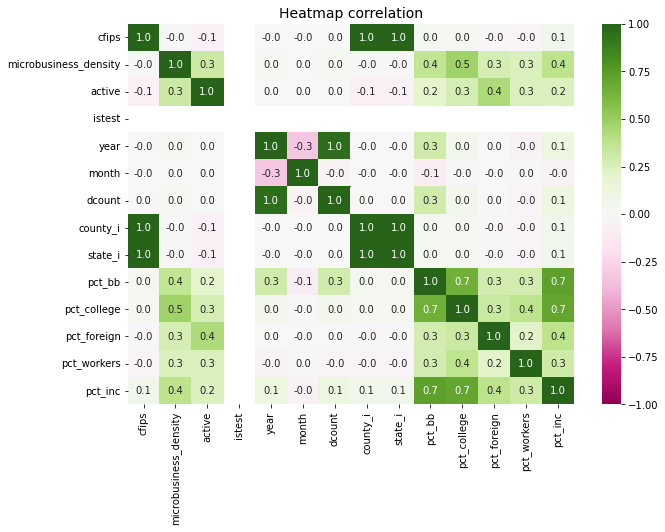

In [904]:
plt.figure(figsize = (10,7))

plt.title("Heatmap correlation", fontsize =14,loc='center')
heatmap_reg = sns.heatmap(df_all_train.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
square=True

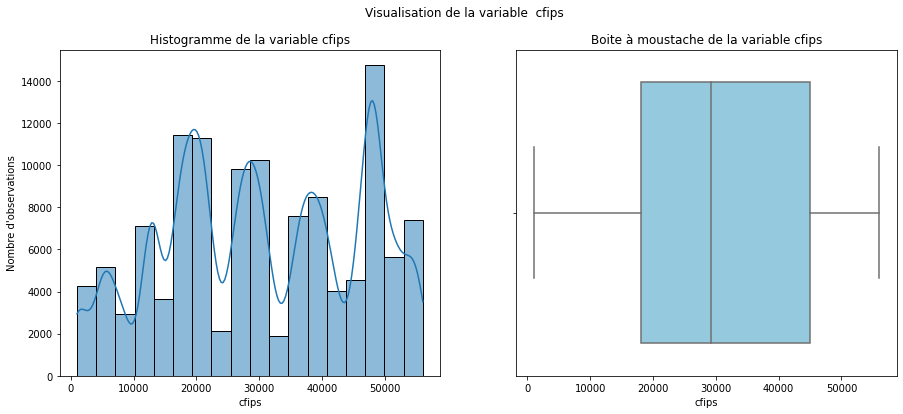

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


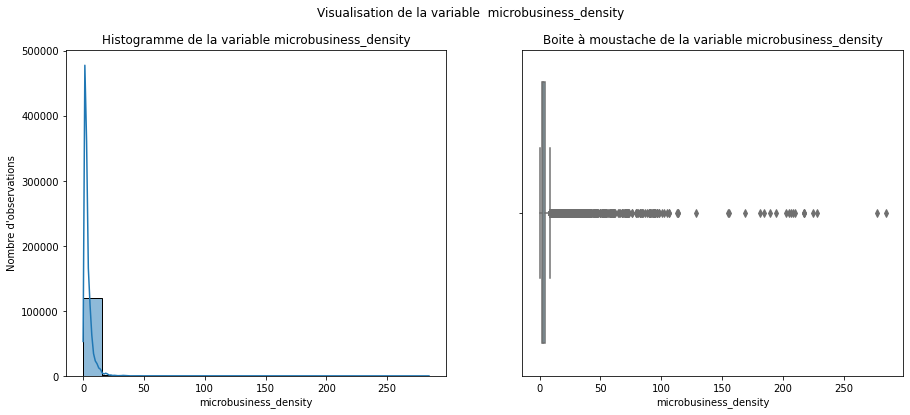

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64


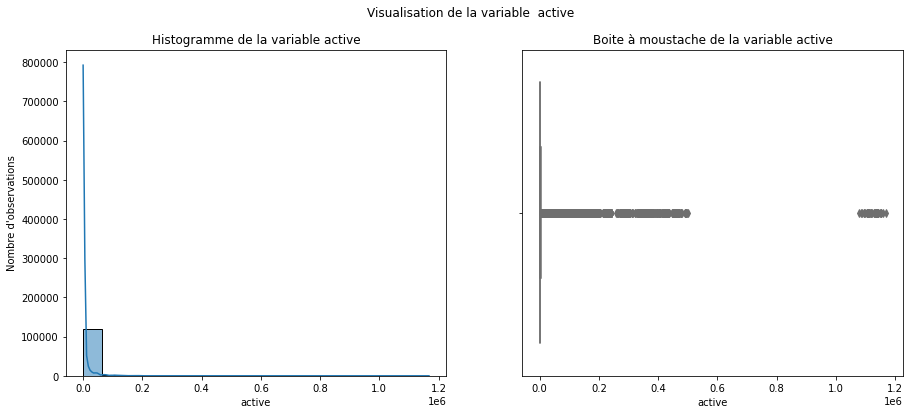

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean     6.442858e+03
std      3.304001e+04
min      0.000000e+00
25%      1.450000e+02
50%      4.880000e+02
75%      2.124000e+03
max      1.167744e+06
Name: active, dtype: float64


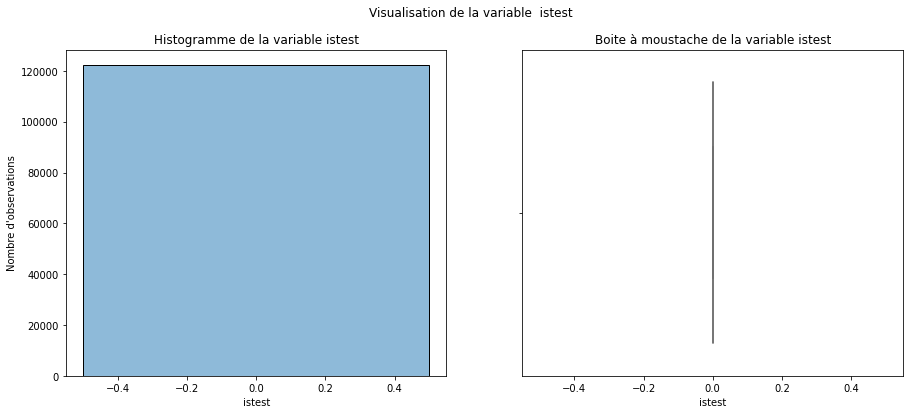

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


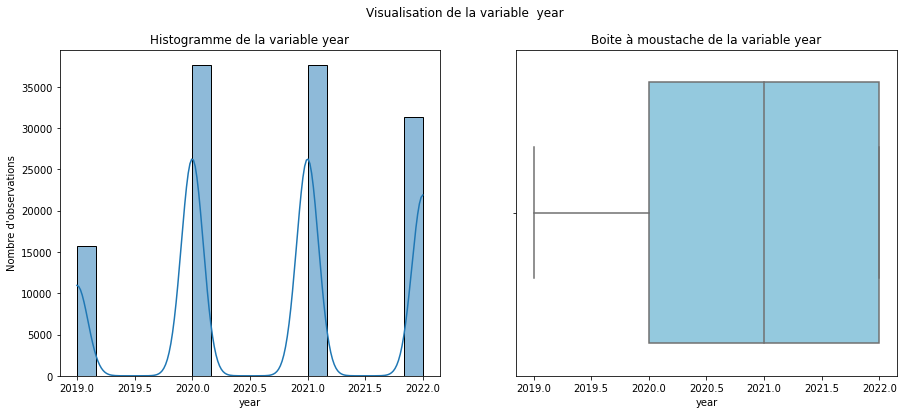

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


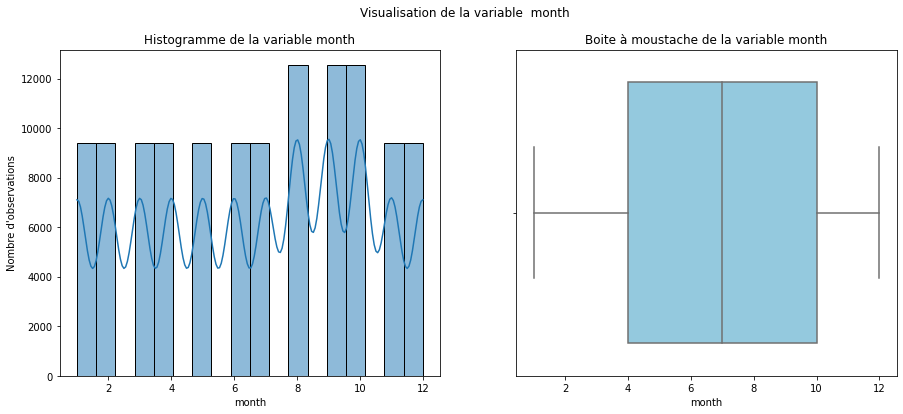

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


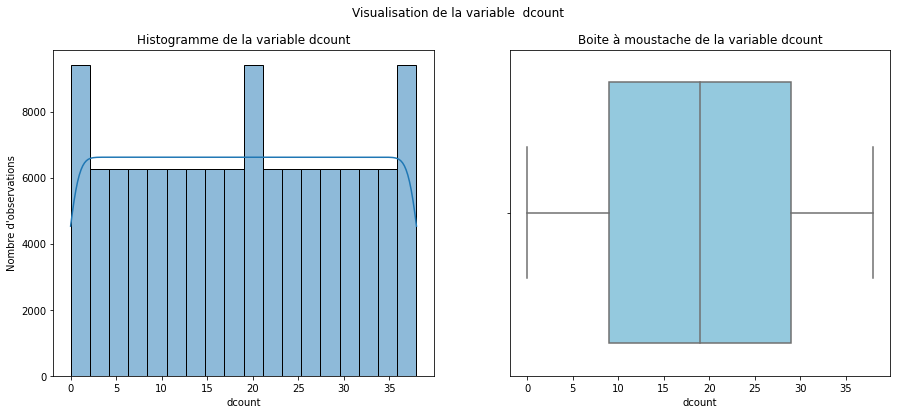

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


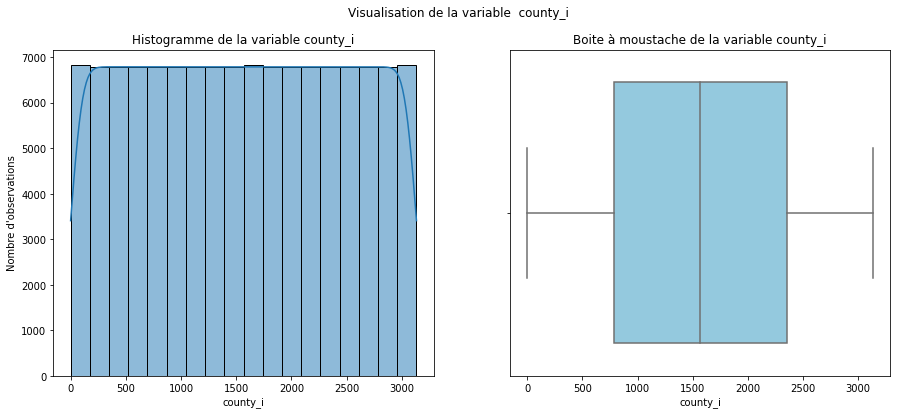

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


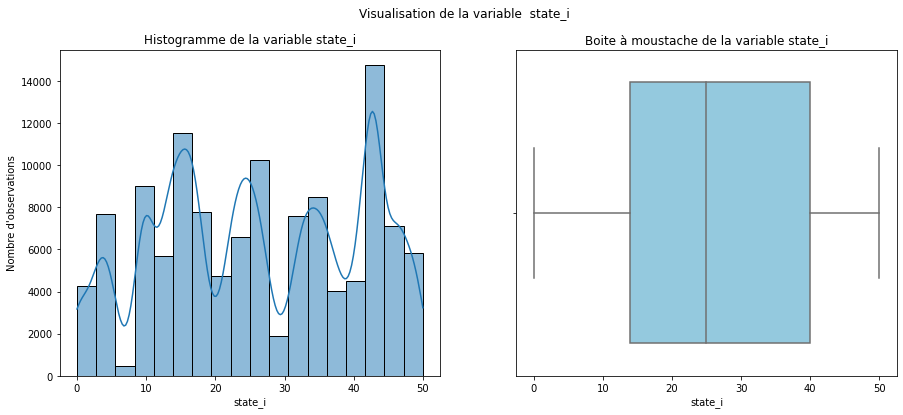

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


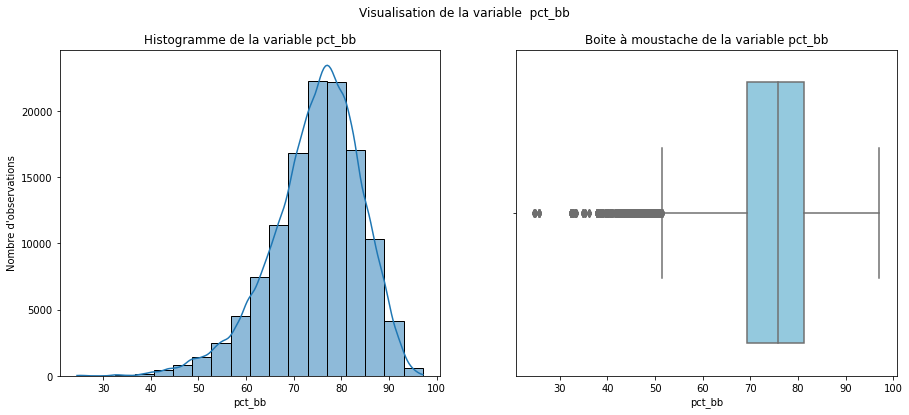

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.686369
std           9.374487
min          24.500000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


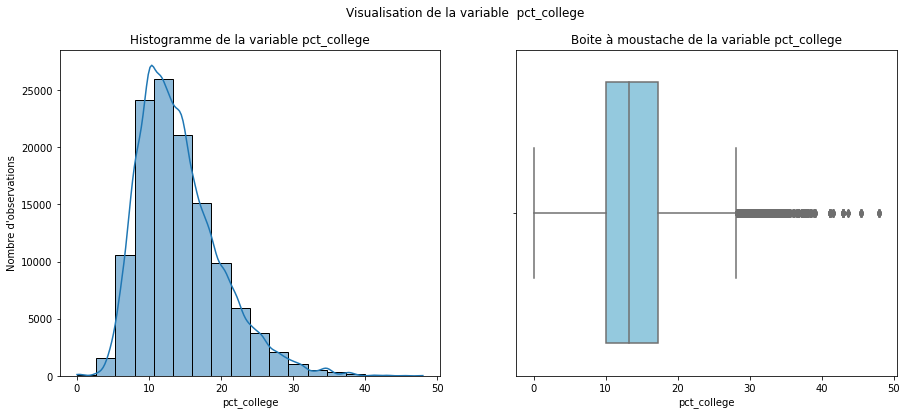

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         14.220153
std           5.685812
min           0.000000
25%          10.100000
50%          13.200000
75%          17.300000
max          48.000000
Name: pct_college, dtype: float64


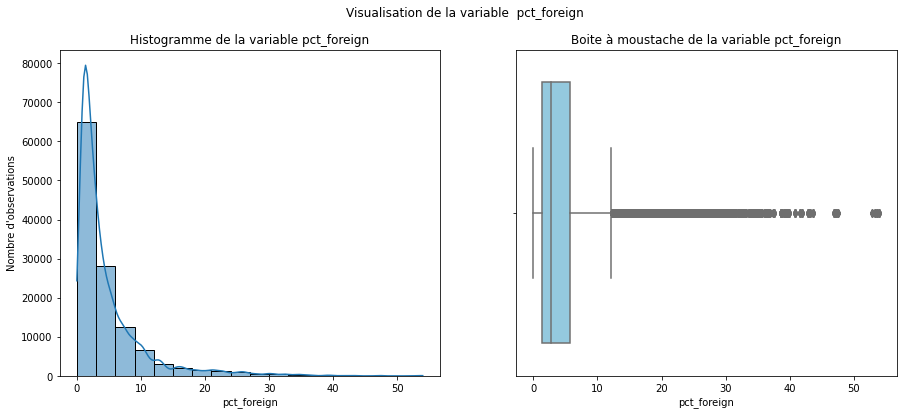

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.744932
std           5.711121
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          54.000000
Name: pct_foreign, dtype: float64


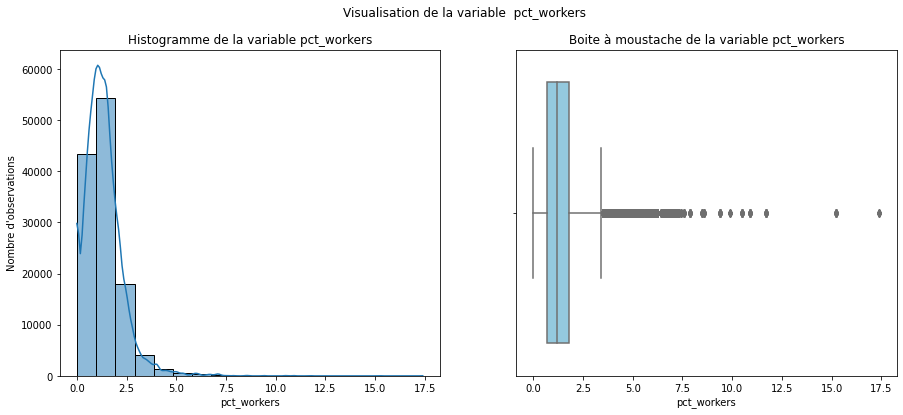

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.355777
std           0.960013
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max          17.400000
Name: pct_workers, dtype: float64


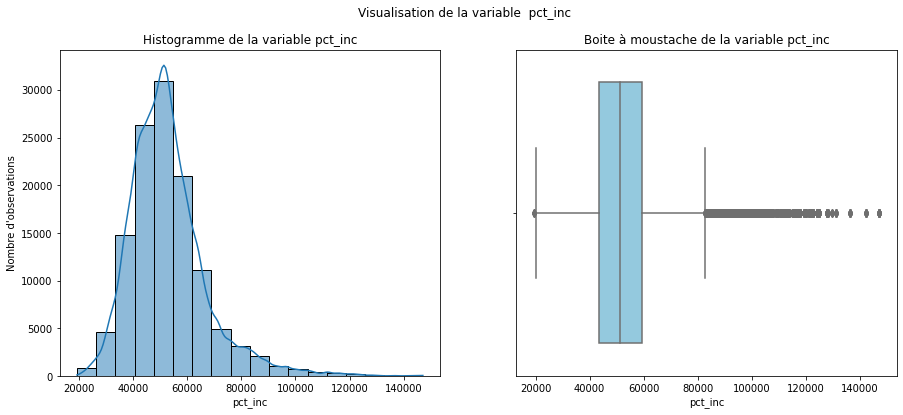

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52830.468850
std       14129.478137
min       19264.000000
25%       43507.000000
50%       51097.000000
75%       59230.000000
max      147111.000000
Name: pct_inc, dtype: float64


In [537]:
for col in df_all_train.select_dtypes(include=['float64', 'int64']):
  hist_box_plot(df_all_train, 
                col, 
                subtitle =f"Visualisation de la variable  {col}",
                hist_title = f'Histogramme de la variable {col}',
                color = 'skyblue')

##Log microbusiness density

In [538]:
df_all_train.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc'],
      dtype='object')

In [539]:
df_all_train['microbusiness_density_log'] = np.log(df_all_train["microbusiness_density"])

In [540]:
df_all_train

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
122260               1.803249   101.0       0  2022      6      34      3134   
122261               1.803249   101.0       0  2022      7      35      3134   
122262               1.785395   100.0       0  2022      8      36      3134   
122263               1.785395   100.0       0  2022      9      37      3134   
122264               1.785395   100.0       0  2022     10      38      3134   

        state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  \
0             0    76.6         14.5          2.1          1.3  55317.0   
1             0    76.6         14.5          2.1          1.3  55317.0   
2             0    76.6         14.5          2.1          1.3  55317.0   
3             0    76.6         14.5          2.1          1.3  55317.0   
4             0    76.6         14.5          2.1          1.3  55317.0   
...         ...     ...          ...          ...          ...      ...   
122260       50    79.7         12.7          2.3          0.0  53333.0   
122261       50    79.7         12.7          2.3          0.0  53333.0   
122262       50    79.7         12.7          2.3          0.0  53333.0   
122263       50    79.7         12.7          2.3          0.0  53333.0   
122264       50    79.7         12.7          2.3          0.0  53333.0   

        microbusiness_density_log  
0                        1.101170  
1                        1.059480  
2                        1.117056  
3                        1.096354  
4                        1.096354  
...                           ...  
122260                   0.589590  
122261                   0.589590  
122262                   0.579640  
122263                   0.579640  
122264                   0.579640  

[122265 rows x 19 columns]

##Viz microbusiness_density_log

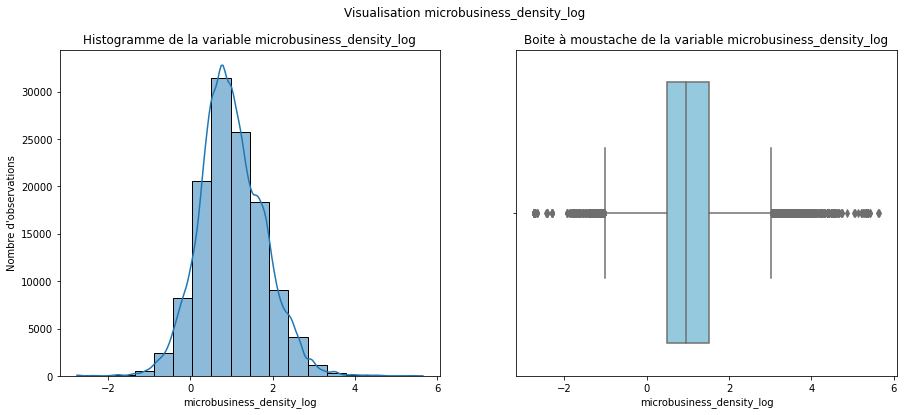

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.942963e-01
50%      9.503224e-01
75%      1.508342e+00
max      5.650171e+00
Name: microbusiness_density_log, dtype: float64


In [541]:
hist_box_plot(df_all_train, 
                col = "microbusiness_density_log", 
                subtitle ="Visualisation microbusiness_density_log",
                hist_title = 'Histogramme de la variable microbusiness_density_log',
                color = 'skyblue')

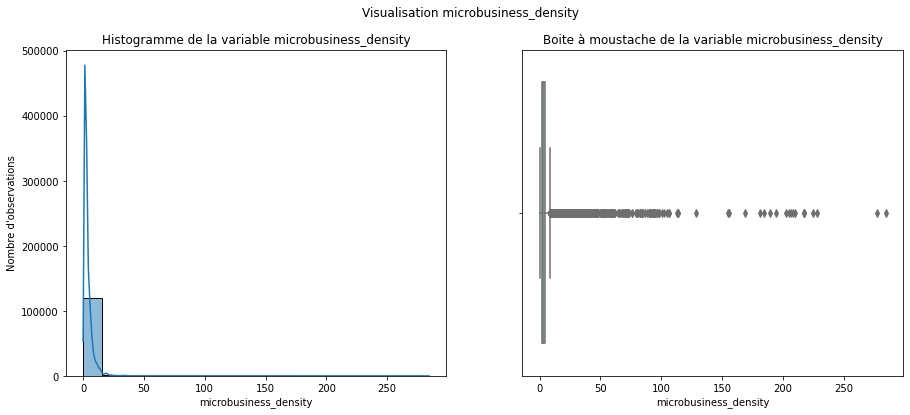

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64


In [542]:
hist_box_plot(df_all_train, 
                col = "microbusiness_density", 
                subtitle ="Visualisation microbusiness_density",
                hist_title = 'Histogramme de la variable microbusiness_density',
                color = 'skyblue')

In [543]:
high_density_cfips = df_all_train[df_all_train["microbusiness_density"] >= 70]["cfips"]

high_density_cfips.unique()

array([ 8105, 16021, 32017, 32510, 46127, 56033])

In [544]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
pd.set_option('display.max_columns', None)

fig = make_subplots(rows=6, cols=1)
for idx, curr_cfip in enumerate(high_density_cfips.unique()):
  cfip_data = df_all_train[df_all_train["cfips"] == curr_cfip]
  fig.add_trace(
        go.Scatter(name=f"{curr_cfip}", x=cfip_data["first_day_of_month"], y=cfip_data["microbusiness_density"]),
        row=idx+1,
        col=1
        )
fig.update_layout(height=900, width=1100,  title_text="Microbusiness density of counties with highest values")
fig.show()

##Log active

In [545]:
df_all_train['active_log'] = np.log(df_all_train["active"])

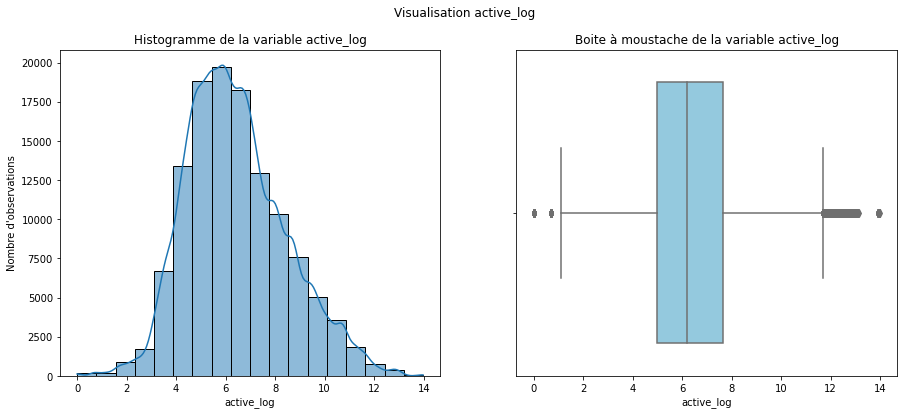

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.976734e+00
50%      6.190315e+00
75%      7.661056e+00
max      1.397058e+01
Name: active_log, dtype: float64


In [546]:
hist_box_plot(df_all_train, 
                col = "active_log", 
                subtitle ="Visualisation active_log",
                hist_title = 'Histogramme de la variable active_log',
                color = 'skyblue')

In [547]:
df_all_train.head()

row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active  istest  year  month  dcount  county_i  \
0               3.007682  1249.0       0  2019      8       0         0   
1               2.884870  1198.0       0  2019      9       1         0   
2               3.055843  1269.0       0  2019     10       2         0   
3               2.993233  1243.0       0  2019     11       3         0   
4               2.993233  1243.0       0  2019     12       4         0   

   state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  \
0        0    76.6         14.5          2.1          1.3  55317.0   
1        0    76.6         14.5          2.1          1.3  55317.0   
2        0    76.6         14.5          2.1          1.3  55317.0   
3        0    76.6         14.5          2.1          1.3  55317.0   
4        0    76.6         14.5          2.1          1.3  55317.0   

   microbusiness_density_log  active_log  
0                   1.101170    7.130099  
1                   1.059480    7.088409  
2                   1.117056    7.145984  
3                   1.096354    7.125283  
4                   1.096354    7.125283

In [548]:
df_all_train[df_all_train.loc[:,"cfips" ]==1001]

row_id  cfips          county    state first_day_of_month  \
0   1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1   1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2   1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3   1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4   1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
5   1001_2020-01-01   1001  Autauga County  Alabama         2020-01-01   
6   1001_2020-02-01   1001  Autauga County  Alabama         2020-02-01   
7   1001_2020-03-01   1001  Autauga County  Alabama         2020-03-01   
8   1001_2020-04-01   1001  Autauga County  Alabama         2020-04-01   
9   1001_2020-05-01   1001  Autauga County  Alabama         2020-05-01   
10  1001_2020-06-01   1001  Autauga County  Alabama         2020-06-01   
11  1001_2020-07-01   1001  Autauga County  Alabama         2020-07-01   
12  1001_2020-08-01   1001  Autauga County  Alabama         2020-08-01   
13  1001_2020-09-01   1001  Autauga County  Alabama         2020-09-01   
14  1001_2020-10-01   1001  Autauga County  Alabama         2020-10-01   
15  1001_2020-11-01   1001  Autauga County  Alabama         2020-11-01   
16  1001_2020-12-01   1001  Autauga County  Alabama         2020-12-01   
17  1001_2021-01-01   1001  Autauga County  Alabama         2021-01-01   
18  1001_2021-02-01   1001  Autauga County  Alabama         2021-02-01   
19  1001_2021-03-01   1001  Autauga County  Alabama         2021-03-01   
20  1001_2021-04-01   1001  Autauga County  Alabama         2021-04-01   
21  1001_2021-05-01   1001  Autauga County  Alabama         2021-05-01   
22  1001_2021-06-01   1001  Autauga County  Alabama         2021-06-01   
23  1001_2021-07-01   1001  Autauga County  Alabama         2021-07-01   
24  1001_2021-08-01   1001  Autauga County  Alabama         2021-08-01   
25  1001_2021-09-01   1001  Autauga County  Alabama         2021-09-01   
26  1001_2021-10-01   1001  Autauga County  Alabama         2021-10-01   
27  1001_2021-11-01   1001  Autauga County  Alabama         2021-11-01   
28  1001_2021-12-01   1001  Autauga County  Alabama         2021-12-01   
29  1001_2022-01-01   1001  Autauga County  Alabama         2022-01-01   
30  1001_2022-02-01   1001  Autauga County  Alabama         2022-02-01   
31  1001_2022-03-01   1001  Autauga County  Alabama         2022-03-01   
32  1001_2022-04-01   1001  Autauga County  Alabama         2022-04-01   
33  1001_2022-05-01   1001  Autauga County  Alabama         2022-05-01   
34  1001_2022-06-01   1001  Autauga County  Alabama         2022-06-01   
35  1001_2022-07-01   1001  Autauga County  Alabama         2022-07-01   
36  1001_2022-08-01   1001  Autauga County  Alabama         2022-08-01   
37  1001_2022-09-01   1001  Autauga County  Alabama         2022-09-01   
38  1001_2022-10-01   1001  Autauga County  Alabama         2022-10-01   

    microbusiness_density  active  istest  year  month  dcount  county_i  \
0                3.007682  1249.0       0  2019      8       0         0   
1                2.884870  1198.0       0  2019      9       1         0   
2                3.055843  1269.0       0  2019     10       2         0   
3                2.993233  1243.0       0  2019     11       3         0   
4                2.993233  1243.0       0  2019     12       4         0   
5                2.969090  1242.0       0  2020      1       5         0   
6                2.909326  1217.0       0  2020      2       6         0   
7                2.933231  1227.0       0  2020      3       7         0   
8                3.000167  1255.0       0  2020      4       8         0   
9                3.004948  1257.0       0  2020      5       9         0   
10               3.019292  1263.0       0  2020      6      10         0   
11               3.083837  1290.0       0  2020      7      11         0   
12               3.174679  1328.0       0  2020      8      12  

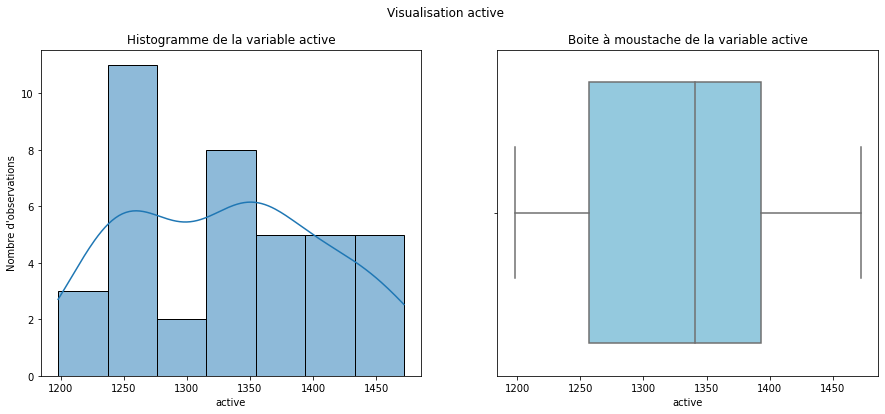

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count      39.000000
mean     1331.717949
std        78.200467
min      1198.000000
25%      1256.500000
50%      1341.000000
75%      1393.500000
max      1472.000000
Name: active, dtype: float64


In [549]:
hist_box_plot(df_all_train[df_all_train.loc[:,"cfips" ]==1001], 
                col = "active", 
                subtitle ="Visualisation active",
                hist_title = 'Histogramme de la variable active',
                color = 'skyblue')

#df all train pivot

In [550]:
train_pivoted = df_all_train.pivot(index='cfips',columns='first_day_of_month',values='microbusiness_density')
train_pivoted

first_day_of_month  2019-08-01  2019-09-01  2019-10-01  2019-11-01  \
cfips                                                                
1001                  3.007682    2.884870    3.055843    2.993233   
1003                  7.239156    7.290936    7.425439    7.426071   
1005                  1.073138    0.995794    1.160149    1.000628   
1007                  1.310777    1.305176    1.254761    1.254761   
1009                  1.544148    1.575892    1.546415    1.573625   
...                        ...         ...         ...         ...   
56037                 2.640386    2.858371    2.913635    3.008812   
56039                26.433363   26.611856   26.736261   26.920164   
56041                 4.612016    4.338306    4.420419    4.372520   
56043                 2.603246    2.683593    2.635385    2.683593   
56045                 1.548594    1.530794    1.530794    1.601994   

first_day_of_month  2019-12-01  2020-01-01  2020-02-01  2020-03-01  \
cfips                                                                
1001                  2.993233    2.969090    2.909326    2.933231   
1003                  7.470274    7.413655    7.282522    7.309610   
1005                  1.000628    1.027229    1.022314    1.032144   
1007                  1.265965    1.253638    1.248041    1.264831   
1009                  1.555485    1.573217    1.536999    1.541526   
...                        ...         ...         ...         ...   
56037                 3.088637    3.150922    3.169494    3.237588   
56039                26.903938   26.684565   26.738255   26.668457   
56041                 4.310935    4.367864    4.237172    4.182143   
56043                 2.635385    2.666882    2.699208    2.699208   
56045                 1.584194    1.590706    1.519214    1.537087   

first_day_of_month  2020-04-01  2020-05-01  2020-06-01  2020-07-01  \
cfips                                                                
1001                  3.000167    3.004948    3.019292    3.083837   
1003                  7.568799    7.603275    7.708551    7.783045   
1005                  1.086209    1.081294    0.997739    0.987909   
1007                  1.270428    1.287217    1.304007    1.343183   
1009                  1.577744    1.575481    1.570953    1.602644   
...                        ...         ...         ...         ...   
56037                 3.293302    3.311873    3.126161    3.194255   
56039                27.119463   27.414764   27.506041   27.720806   
56041                 4.195900    4.443527    4.450406    4.477920   
56043                 2.683045    2.731534    2.699208    2.731534   
56045                 1.554960    1.608579    1.662198    1.554960   

first_day_of_month  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
cfips                                                                
1001                  3.174679    3.205756    3.193804    3.038416   
1003                  7.853229    8.412239    8.329126    8.263252   
1005                  0.982994    1.022314    1.037059    1.032144   
1007                  1.304007    1.320797    1.326394    1.320797   
1009                  1.604907    1.647916    1.641125    1.641125   
...                        ...         ...         ...         ...   
56037                 3.197351    3.178779    3.163303    3.188065   
56039                27.565102   27.495302   27.441610   27.463087   
56041                 4.491677    3.907002    3.838217    3.886367   
56043                 2.569905    2.586068    2.650719    2.666882   
56045                 1.590706    1.590706    1.554960    1.554960   

first_day_of_month  2020-12-01  2021-01-01  2021-02-01  2021-03-01  \
cfips                                                                
1001                  3.002558    2.947244    3.106106    3.144043   
1003                  8.224466    8.011045    7.909001    7.978031   
1005                  1.032144    1.111998    1.072105    1.057146   
1007  

In [551]:
train_pivoted.mean(axis=0)

first_day_of_month
2019-08-01    3.749621
2019-09-01    3.696846
2019-10-01    3.778263
2019-11-01    3.722510
2019-12-01    3.717284
2020-01-01    3.689041
2020-02-01    3.635546
2020-03-01    3.648742
2020-04-01    3.700048
2020-05-01    3.716288
2020-06-01    3.723051
2020-07-01    3.742934
2020-08-01    3.764328
2020-09-01    3.771558
2020-10-01    3.769525
2020-11-01    3.758974
2020-12-01    3.744650
2021-01-01    3.711420
2021-02-01    3.785175
2021-03-01    3.813435
2021-04-01    3.835583
2021-05-01    3.834570
2021-06-01    3.835156
2021-07-01    3.845064
2021-08-01    3.860317
2021-09-01    3.861170
2021-10-01    3.876802
2021-11-01    3.910580
2021-12-01    3.924642
2022-01-01    3.902177
2022-02-01    3.918186
2022-03-01    3.955753
2022-04-01    3.959441
2022-05-01    3.941799
2022-06-01    3.902961
2022-07-01    3.965593
2022-08-01    3.953798
2022-09-01    3.959358
2022-10-01    4.006963
dtype: float64

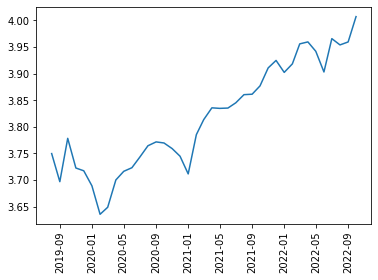

In [552]:
# micro-business density 

plt.plot(train_pivoted.mean(axis=0));
plt.xticks(rotation=90);

#df all train group by

In [553]:
df_all_train.groupby(["cfips", "year"]).mean("microbusiness_density")

microbusiness_density        active  istest  month  dcount  \
cfips year                                                               
1001  2019               2.986972   1240.400000     0.0   10.0     2.0   
      2020               3.044592   1273.583333     0.0    6.5    10.5   
      2021               3.181585   1341.833333     0.0    6.5    22.5   
      2022               3.376788   1435.000000     0.0    5.5    33.5   
1003  2019               7.370375  11671.800000     0.0   10.0     2.0   
...                           ...           ...     ...    ...     ...   
56043 2022               3.088503    186.700000     0.0    5.5    33.5   
56045 2019               1.559274     87.600000     0.0   10.0     2.0   
      2020               1.574322     88.083333     0.0    6.5    10.5   
      2021               1.699000     94.583333     0.0    6.5    22.5   
      2022               1.780039     99.700000     0.0    5.5    33.5   

            county_i  state_i  pct_bb  pct_college  pct_foreign  pct_workers  \
cfips year                                                                     
1001  2019       0.0      0.0    76.6         14.5          2.1          1.3   
      2020       0.0      0.0    78.9         15.9          2.0          1.1   
      2021       0.0      0.0    80.6         16.1          2.3          0.7   
      2022       0.0      0.0    82.7         16.7          2.3          0.6   
1003  2019       1.0      0.0    74.5         20.4          3.2          1.4   
...              ...      ...     ...          ...          ...          ...   
56043 2022    3133.0     50.0    82.8         15.0          2.2          0.9   
56045 2019    3134.0     50.0    71.1         14.1          3.8          0.6   
      2020    3134.0     50.0    73.3         13.5          4.1          0.6   
      2021    3134.0     50.0    76.8         13.4          1.7          0.0   
      2022    3134.0     50.0    79.7         12.7          2.3          0.0   

            pct_inc  microbusiness_density_log  active_log  
cfips year                                                  
1001  2019  55317.0                   1.094083    7.123012  
      2020  58786.0                   1.112881    7.149104  
      2021  58731.0                   1.157032    7.201445  
      2022  57982.0                   1.216782    7.268777  
1003  2019  52562.0                   1.997395    9.364858  
...             ...                        ...         ...  
56043 2022  57306.0                   1.127176    5.228993  
56045 2019  59605.0                   0.444049    4.472610  
      2020  52867.0                   0.453565    4.478024  
      2021  57031.0                   0.529542    4.548984  
      2022  53333.0                   0.576574    4.602105  

[12540 rows x 14 columns]

#Outliers

##fonction smoth

In [728]:
def smooth(df, coln):
  for i in range(0, len(coln)):
      data_stats = df.copy(deep=True)
      data_stats = data_stats.loc[:, ["cfips", coln[i]]]
      data_stats["cfips"] = data_stats["cfips"].astype(str)

      stats = data_stats.describe().transpose()
      stats['IQR'] = stats['75%'] - stats['25%']

      outliers = pd.DataFrame(columns=stats.columns)

      for col in stats.index:
          iqr = stats.at[col,'IQR']
          cutoff = iqr * 1.5
          lower = stats.at[col,'25%'] - cutoff
          upper = stats.at[col,'75%'] + cutoff
          results = data_stats[(data_stats[col] < lower) | 
                        (data_stats[col] > upper)].copy()
          results['Outlier'] = col
          outliers = outliers.append(results)
      outliers.reset_index(inplace=True)
      idx = outliers["index"].tolist()
      print(f'column : {coln[i]}')
      print(f'index outliers : {idx}')
      print(f'lenght outliers : {len(idx)}')
      print(f'upper:{upper}')
      print(f'lower:{lower}')


      for j in idx:
          out = df.iloc[idx, df.columns.get_loc(coln[i])].tolist()[0]
          if out > upper:
              df.iloc[idx, df.columns.get_loc(coln[i])] = upper
          if out < lower:
              df.iloc[idx, df.columns.get_loc(coln[i])] = lower
  return df


##dataframe df_train_smoothy

In [729]:
df_train_to_smooth = df_all_train.copy(deep=True)

In [730]:
lst1 = df_train_to_smooth.columns[5:7].tolist()
lst1

['microbusiness_density', 'active']

In [731]:
lst2 = df_train_to_smooth.columns[13:19].tolist()
lst2

['pct_bb', 'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc']

In [732]:
lst = lst1+lst2
lst

['microbusiness_density',
 'active',
 'pct_bb',
 'pct_college',
 'pct_foreign',
 'pct_workers',
 'pct_inc']

In [733]:
%%time
col_census = lst #df_train_to_smooth.columns['microbusiness_density', 'active', 'pct_bb', 'pct_college', 'pct_foreign','pct_workers', 'pct_inc'].tolist()
df_train_smoothy = smooth(df_train_to_smooth, coln = col_census)
df_train_smoothy

column : microbusiness_density
index outliers : [2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 5304, 5305, 530

row_id  cfips          county    state first_day_of_month  \
0        1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1        1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2        1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3        1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4        1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   
...                  ...    ...             ...      ...                ...   
122260  56045_2022-06-01  56045   Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045   Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045   Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045   Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045   Weston County  Wyoming         2022-10-01   

        microbusiness_density  active  istest  year  month  dcount  county_i  \
0                    3.007682  1249.0       0  2019      8       0         0   
1                    2.884870  1198.0       0  2019      9       1         0   
2                    3.055843  1269.0       0  2019     10       2         0   
3                    2.993233  1243.0       0  2019     11       3         0   
4                    2.993233  1243.0       0  2019     12       4         0   
...                       ...     ...     ...   ...    ...     ...       ...   
122260               1.803249   101.0       0  2022      6      34      3134   
122261               1.803249   101.0       0  2022      7      35      3134   
122262               1.785395   100.0       0  2022      8      36      3134   
122263               1.785395   100.0       0  2022      9      37      3134   
122264               1.785395   100.0       0  2022     10      38      3134   

        state_i  pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  
0             0    76.6         14.5          2.1          1.3  55317.0  
1             0    76.6         14.5          2.1          1.3  55317.0  
2             0    76.6         14.5          2.1          1.3  55317.0  
3             0    76.6         14.5          2.1          1.3  55317.0  
4             0    76.6         14.5          2.1          1.3  55317.0  
...         ...     ...          ...          ...          ...      ...  
122260       50    79.7         12.7          2.3          0.0  53333.0  
122261       50    79.7         12.7          2.3          0.0  53333.0  
122262       50    79.7         12.7          2.3          0.0  53333.0  
122263       50    79.7         12.7          2.3          0.0  53333.0  
122264       50    79.7         12.7          2.3          0.0  53333.0  

[122265 rows x 18 columns]

##Viz df train smoothy

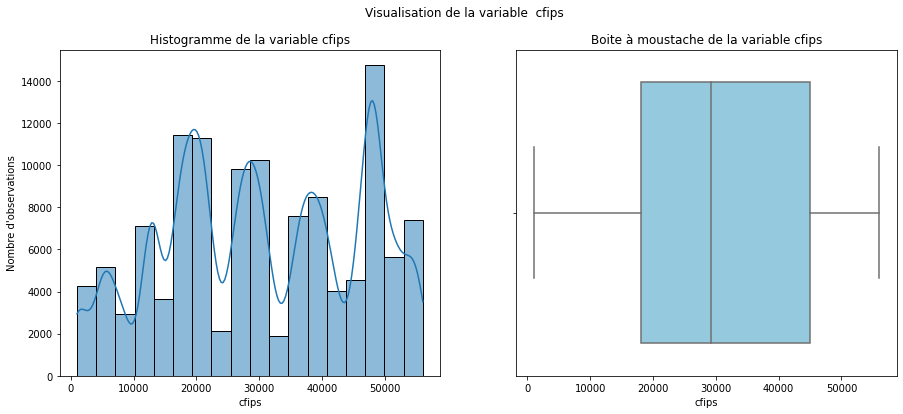

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


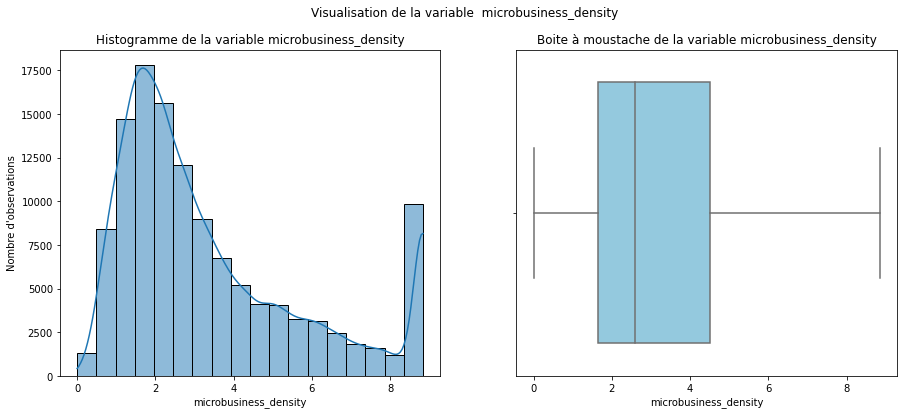

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.378144
std           2.349475
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max           8.839061
Name: microbusiness_density, dtype: float64


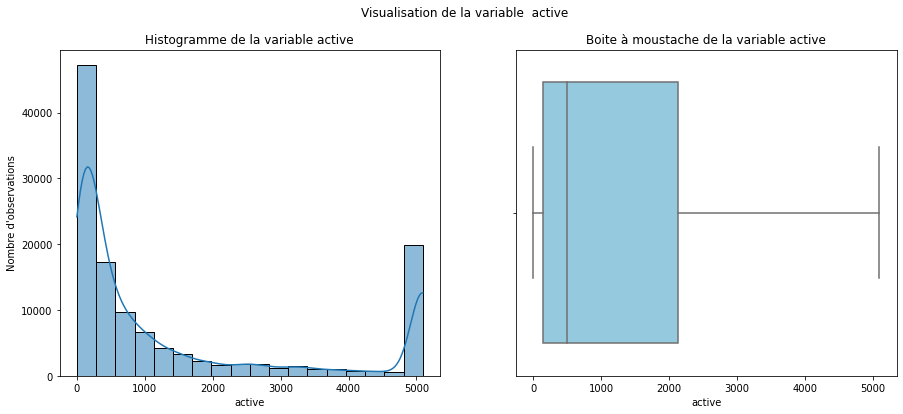

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1455.818251
std        1835.466134
min           0.000000
25%         145.000000
50%         488.000000
75%        2124.000000
max        5092.500000
Name: active, dtype: float64


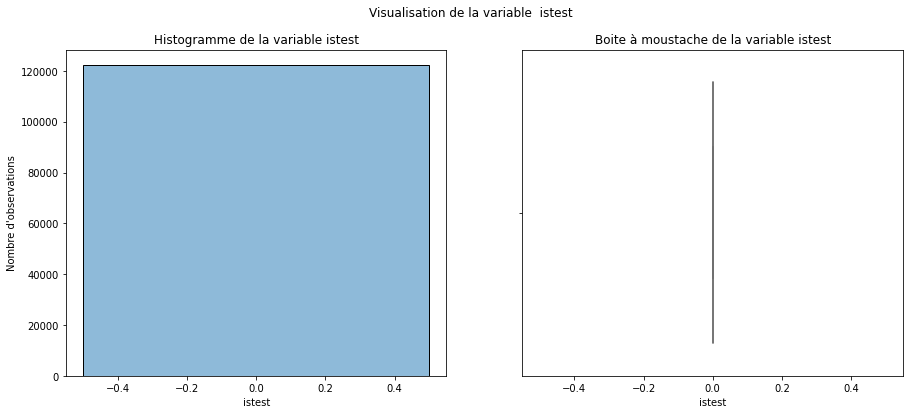

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


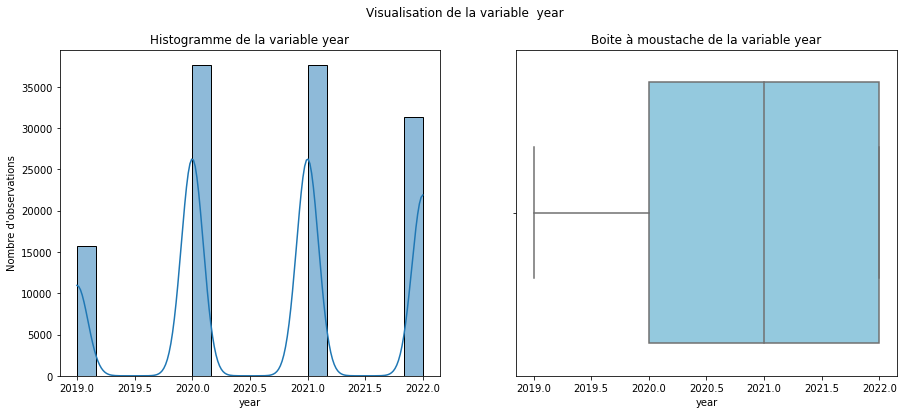

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


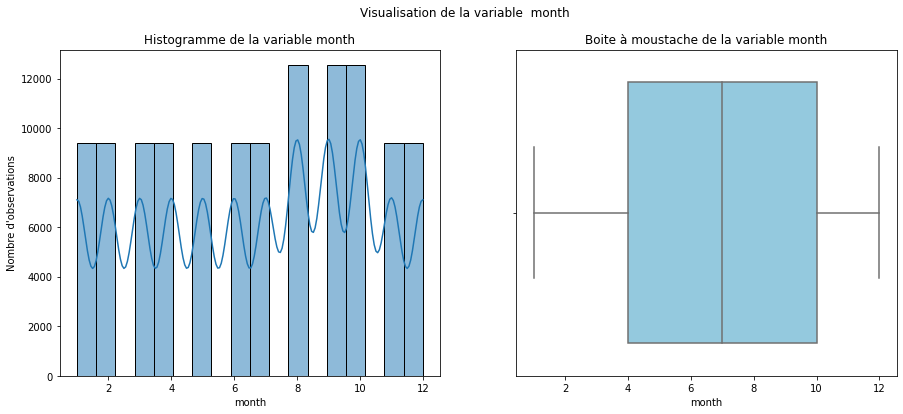

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


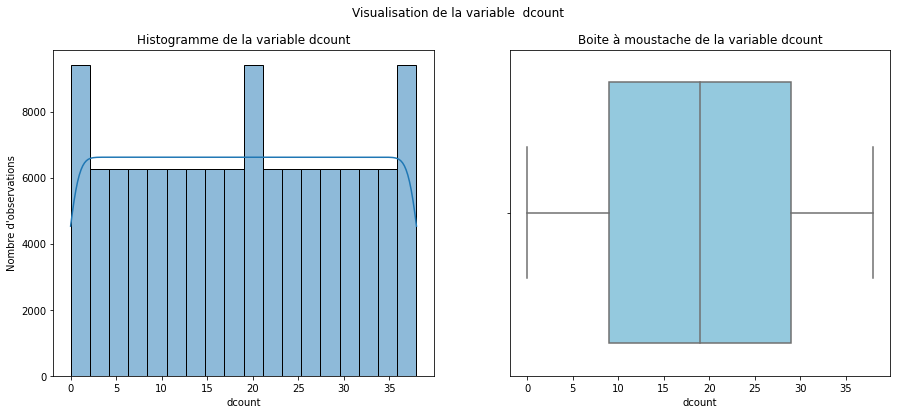

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


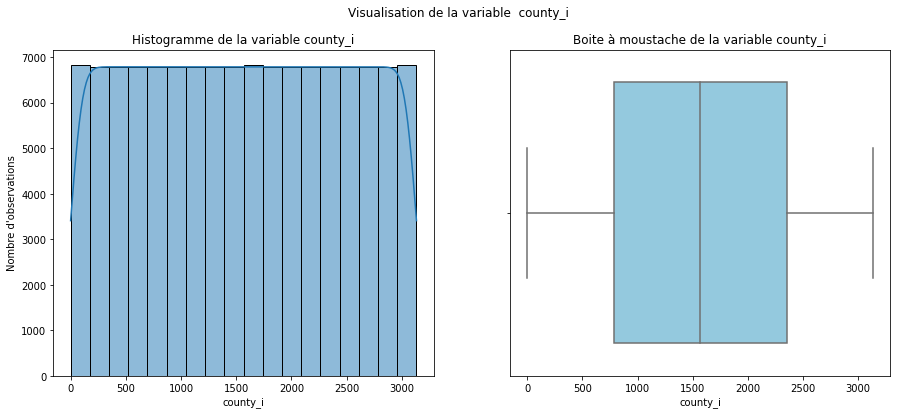

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


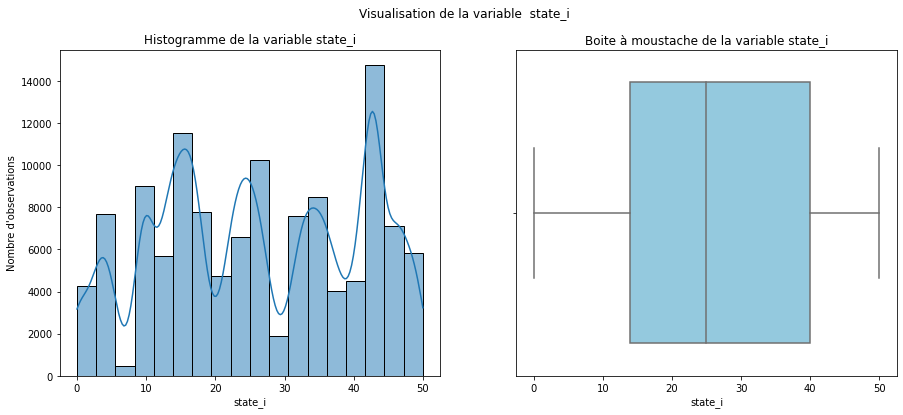

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


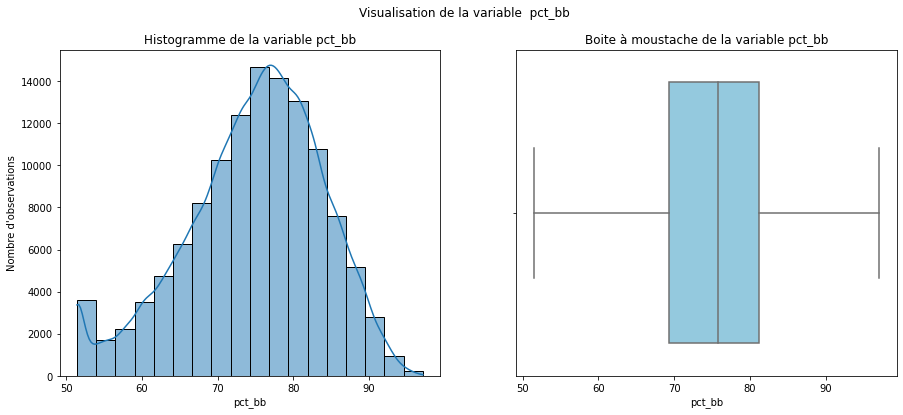

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.788855
std           9.064733
min          51.450000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


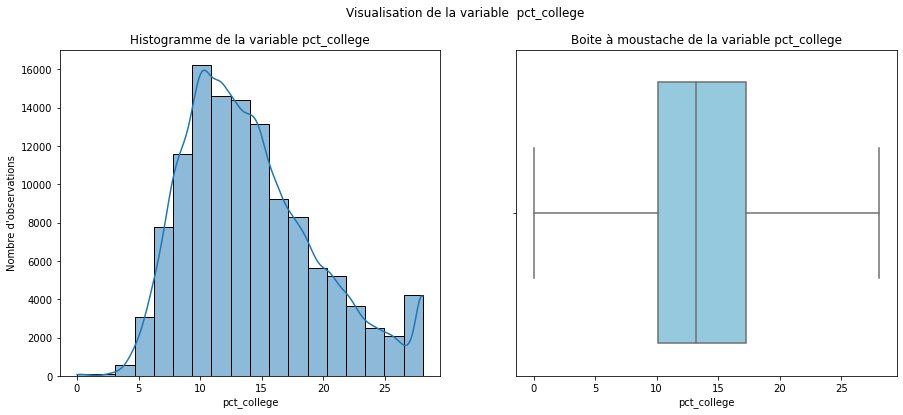

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.00000
mean         14.13029
std           5.40431
min           0.00000
25%          10.10000
50%          13.20000
75%          17.30000
max          28.10000
Name: pct_college, dtype: float64


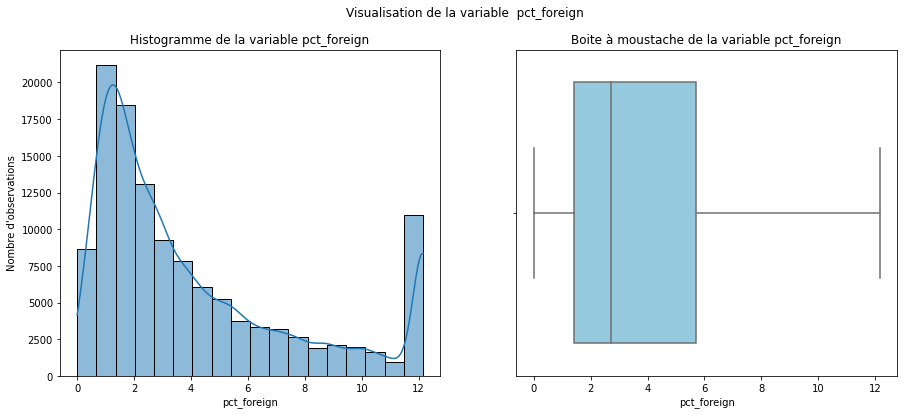

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.080285
std           3.561062
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          12.150000
Name: pct_foreign, dtype: float64


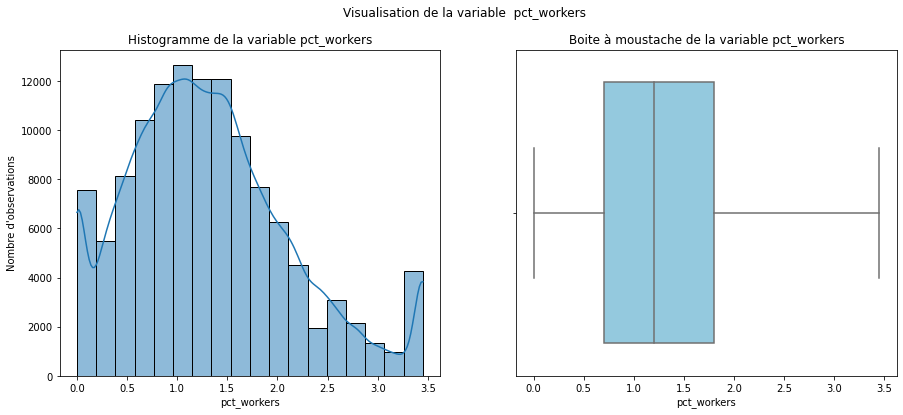

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.320209
std           0.815275
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max           3.450000
Name: pct_workers, dtype: float64


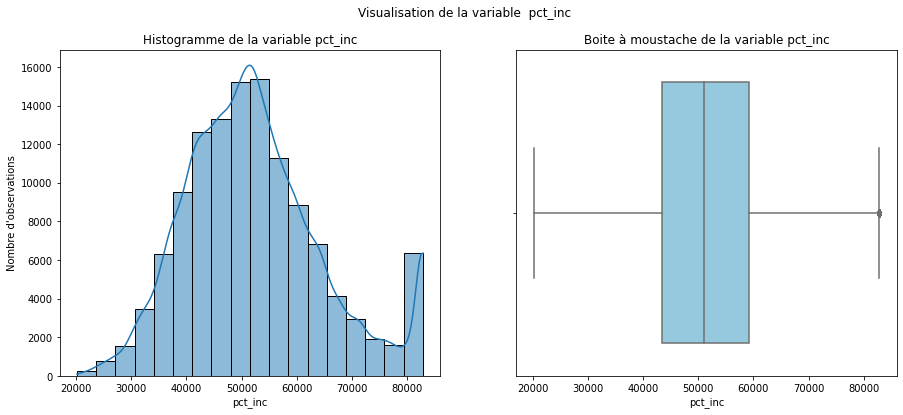

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52330.531644
std       12544.911912
min       20188.000000
25%       43512.000000
50%       51097.000000
75%       59230.000000
max       82814.500000
Name: pct_inc, dtype: float64


In [734]:
for col in df_train_smoothy.select_dtypes(include=['float64', 'int64']):
  hist_box_plot(df_train_smoothy, 
                col, 
                subtitle =f"Visualisation de la variable  {col}",
                hist_title = f'Histogramme de la variable {col}',
                color = 'skyblue')

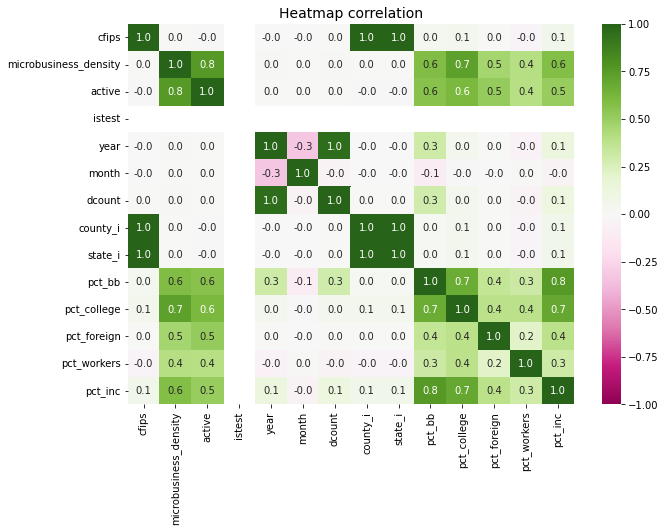

In [902]:
plt.figure(figsize = (10,7))

plt.title("Heatmap correlation", fontsize =14,loc='center')
heatmap_reg = sns.heatmap(df_train_smoothy.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
square=True

##Viz map

In [900]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(df_train_smoothy, geojson=counties, locations='cfips', color='microbusiness_density',
                           color_continuous_scale="Viridis",
                           range_color=(0, 8),
                           scope="usa",
                           title="Latest densities of each county")
                           #labels={'unemp':'unemployment rate'}

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

##Viz

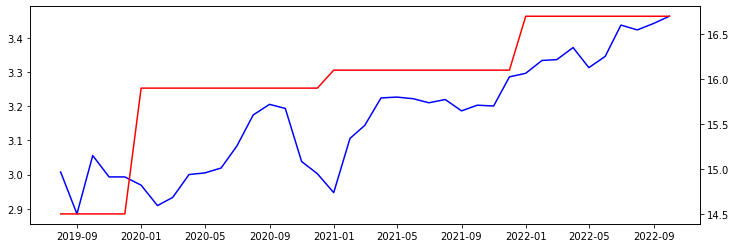

In [735]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_train_smoothy.set_index('first_day_of_month')
test = test[test['cfips']==1001]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['pct_college'], color='red' , label='college')

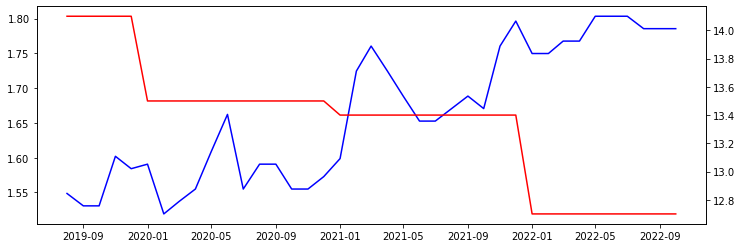

In [736]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_train_smoothy.set_index('first_day_of_month')
test = test[test['cfips']==56045]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['pct_college'], color='red' , label='college')

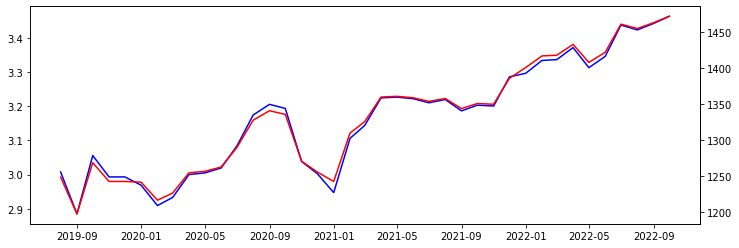

In [737]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_train_smoothy.set_index('first_day_of_month')
test = test[test['cfips']==1001]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['active'], color='red' , label='college')

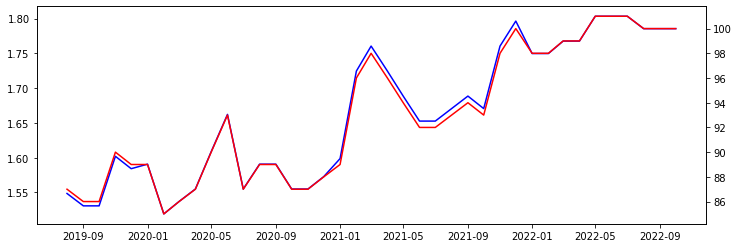

In [738]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_train_smoothy.set_index('first_day_of_month')
test = test[test['cfips']==56045]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['active'], color='red' , label='college')

##dataframe pred - A supp

In [739]:
#df_all_train_nodensityout.columns

In [740]:
#df_all_train_nodensityout

In [741]:
#plt.figure(figsize = (10,7))

#plt.title("Heatmap correlation", fontsize =14,loc='center')
#heatmap_reg = sns.heatmap(df_all_train_nodensityout.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
#square=True

In [742]:
#col = ['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
#       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
#       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
#       'pct_workers', 'pct_inc', 'microbusiness_density_log', 'mbd_lag_1',
#       'dif', 'dif_log']

In [743]:
#df = df_all_train_nodensityout

#Features engineering

In [778]:
train.shape

(122265, 8)

In [779]:
df_all_train.describe()

cfips  microbusiness_density        active    istest  \
count  122265.000000          122265.000000  1.222650e+05  122265.0   
mean    30376.037640               3.817671  6.442858e+03       0.0   
std     15143.508721               4.991087  3.304001e+04       0.0   
min      1001.000000               0.000000  0.000000e+00       0.0   
25%     18177.000000               1.639344  1.450000e+02       0.0   
50%     29173.000000               2.586543  4.880000e+02       0.0   
75%     45077.000000               4.519231  2.124000e+03       0.0   
max     56045.000000             284.340030  1.167744e+06       0.0   

                year          month         dcount       county_i  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean     2020.692308       6.692308      19.000000    1567.000000   
std         0.991089       3.390452      11.254675     905.000202   
min      2019.000000       1.000000       0.000000       0.000000   
25%      2020.000000       4.000000       9.000000     783.000000   
50%      2021.000000       7.000000      19.000000    1567.000000   
75%      2022.000000      10.000000      29.000000    2351.000000   
max      2022.000000      12.000000      38.000000    3134.000000   

             state_i         pct_bb    pct_college    pct_foreign  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean       26.229665      74.686369      14.220153       4.744932   
std        14.253994       9.374487       5.685812       5.711121   
min         0.000000      24.500000       0.000000       0.000000   
25%        14.000000      69.300000      10.100000       1.400000   
50%        25.000000      75.800000      13.200000       2.700000   
75%        40.000000      81.200000      17.300000       5.700000   
max        50.000000      97.100000      48.000000      54.000000   

         pct_workers        pct_inc  
count  122265.000000  122265.000000  
mean        1.355777   52830.468850  
std         0.960013   14129.478137  
min         0.000000   19264.000000  
25%         0.700000   43507.000000  
50%         1.200000   51097.000000  
75%         1.800000   59230.000000  
max        17.400000  147111.000000

In [780]:
#df_train_smoothy.shape

In [781]:
#df_train_smoothy.describe()

In [782]:
#df_train_smoothy_1 = df_train_smoothy.copy(deep=True)
#df_train_smoothy_1

In [783]:
#df_train_smoothy_1.county_i.nunique()

In [784]:
#%%time
#for i in range (-2, 0):
#  j = np.abs(i)
#  df_train_smoothy_1[f'density_shift_{j}'] = df_train_smoothy_1.groupby('cfips')['microbusiness_density'].shift(i)

In [785]:
#df_train_smoothy_1.fillna({'density_shift_1': df_train_smoothy_1.microbusiness_density_log, 'density_shift_2': df_train_smoothy_1.microbusiness_density_log}, inplace =True)

In [786]:
#for i in range (-2, 0):
#  j = np.abs(i)
#  df_train_smoothy_1[f'dif_{j}'] = (df_train_smoothy_1[f'density_shift_{j}']- df_train_smoothy_1['microbusiness_density'])#.fillna(1).clip(0, None) - 1

In [787]:
#df_train_smoothy_1

In [788]:
#df_train_smoothy_1[df_train_smoothy_1.loc[:, "county_i"] == 0].sort_values(by='first_day_of_month', ascending=True).shape

In [789]:
#df_train_smoothy_1[df_train_smoothy_1.loc[:, "county_i"] == 0].sort_values(by='first_day_of_month', ascending=True).loc[:, ["row_id", 
#                                                                                                                           "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            #"dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            #"dif_1",
#                                                                                                                            "county_i"]]

In [790]:
#df_train_smoothy_1[df_train_smoothy_1.loc[:, "county_i"] == 1].sort_values(by='first_day_of_month', ascending=True).shape

In [791]:
#df_train_smoothy_1[df_train_smoothy_1.loc[:, "county_i"] == 1].sort_values(by='first_day_of_month', ascending=True).loc[:, ["row_id", 
#                                                                                                                            "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            "dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            "dif_1",
#                                                                                                                            "county_i"]]

In [792]:
#df_train_smoothy_1[df_train_smoothy_1.loc[:, "county_i"] == 2].sort_values(by='first_day_of_month', ascending=True).loc[:, ["row_id", 
#                                                                                                                            "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            "dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            "dif_1",
#                                                                                                                            "county_i"]]

##function FEng

In [793]:
# create new features and fill density_shift_.median on fillna density_shift_> KO
#%%time
#def features_1(df):
#  for i in range (-11, 0):
#    j = np.abs(i)
#    df[f'density_shift_{j}'] = df.groupby('cfips')['microbusiness_density'].shift(i)
#    df.fillna({df.groupby('cfips')[f'density_shift_{j}']: df.groupby('cfips')[f'density_shift_{j}'].median()}, inplace =True)
  #df.fillna({'density_shift_1': df.microbusiness_density, 'density_shift_2': df.microbusiness_density}, inplace =True)
#  for i in range (-11, 0):
#    j = np.abs(i)
#    df[f'dif_{j}'] = (df[f'density_shift_{j}']- df['microbusiness_density'])
#  return df

In [794]:
# create new features and fill microdensity on fillna density_shift_> OK
%%time
def features(df):
  for i in range (-11, 0):
    j = np.abs(i)
    df[f'density_shift_{j}'] = df.groupby('cfips')['microbusiness_density'].shift(i)
    df.fillna({f'density_shift_{j}': df.microbusiness_density}, inplace =True)
  #df.fillna({'density_shift_1': df.microbusiness_density, 'density_shift_2': df.microbusiness_density}, inplace =True)
  for i in range (-11, 0):
    j = np.abs(i)
    df[f'dif_{j}'] = (df[f'density_shift_{j}']- df['microbusiness_density'])
  return df

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


In [795]:
# create new features and fill microdensity on fillna density_shift_ > KO
#%%time
#col = df.columns[20:31]
##def new_features(df, col):
#  for i in range (-11, 0):
#    j = np.abs(i)
#    df[f'density_shift_{j}'] = df.groupby('cfips')['microbusiness_density'].shift(i)

#  for i in df.cfips.unique(): 
#    for k in range(len(col)-1, -1, -1):
#      median_density = df[df["cfips"]==i].loc[:, col[k]].median()
#      df.loc[(df["cfips"]==i) & (df[col[k]].isnull()), col[k]] = median_density
  
##  for i in range (-11, 0):
#    j = np.abs(i)
#    df[f'dif_{j}'] = (df[f'density_shift_{j}']- df['microbusiness_density'])
#  return df

In [796]:
def new_features(df):
    for i in range (-11, 0):
        j = np.abs(i)
        df[f'density_shift_{j}'] = df.groupby('cfips')['microbusiness_density'].shift(i)
    return df

def new_features1(df, col) :
  for i in df.cfips.unique(): 
    for k in range(len(col)-1, -1, -1):
      median_density = df[df["cfips"]==i].loc[:, col[k]].median()
      df.loc[(df["cfips"]==i) & (df[col[k]].isnull()), col[k]] = median_density
  return df

def new_features2(df):
    for i in range (-11, 0):
        j = np.abs(i)
        df[f'dif_{j}'] = (df[f'density_shift_{j}']- df['microbusiness_density'])
    return df


##dataframe

In [797]:
df_train_smoothy_1 = df_train_smoothy.copy(deep=True)
df_train_smoothy_1.sort_values(by='first_day_of_month', ascending=False, inplace=True)
df_train_smoothy_1

row_id  cfips              county         state  \
122264  56045_2022-10-01  56045       Weston County       Wyoming   
119378  55041_2022-10-01  55041       Forest County     Wisconsin   
103934  48291_2022-10-01  48291      Liberty County         Texas   
45083   22089_2022-10-01  22089  St. Charles Parish     Louisiana   
115088  53009_2022-10-01  53009      Clallam County    Washington   
...                  ...    ...                 ...           ...   
92118   46009_2019-08-01  46009    Bon Homme County  South Dakota   
30186   18159_2019-08-01  18159       Tipton County       Indiana   
92079   46007_2019-08-01  46007      Bennett County  South Dakota   
30225   18161_2019-08-01  18161        Union County       Indiana   
0        1001_2019-08-01   1001      Autauga County       Alabama   

       first_day_of_month  microbusiness_density  active  istest  year  month  \
122264         2022-10-01               1.785395   100.0       0  2022     10   
119378         2022-10-01               1.634575   118.0       0  2022     10   
103934         2022-10-01               2.547569  1612.0       0  2022     10   
45083          2022-10-01               3.703333  1480.0       0  2022     10   
115088         2022-10-01               4.997481  3174.0       0  2022     10   
...                   ...                    ...     ...     ...   ...    ...   
92118          2019-08-01               0.980049    56.0       0  2019      8   
30186          2019-08-01               2.100457   253.0       0  2019      8   
92079          2019-08-01               0.585322    13.0       0  2019      8   
30225          2019-08-01               2.126509   118.0       0  2019      8   
0              2019-08-01               3.007682  1249.0       0  2019      8   

        dcount  county_i  state_i  pct_bb  pct_college  pct_foreign  \
122264      38      3134       50    79.7         12.7          2.3   
119378      38      3060       49    76.3         10.7          0.8   
103934      38      2664       43    82.7          7.1          9.3   
45083       38      1155       18    87.2         21.3          3.7   
115088      38      2950       47    86.5         17.5          5.2   
...        ...       ...      ...     ...          ...          ...   
92118        0      2362       41    68.9         12.9          2.0   
30186        0       774       14    74.0         14.0          1.3   
92079        0      2361       41    62.4         14.3          0.5   
30225        0       775       14    63.9         11.7          0.5   
0            0         0        0    76.6         14.5          2.1   

        pct_workers  pct_inc  
122264          0.0  53333.0  
119378          0.5  48394.0  
103934          1.1  50917.0  
45083           1.2  68113.0  
115088          0.7  55090.0  
...             ...      ...  
92118           0.3  52923.0  
30186           0.8  53931.0  
92079           0.9  45725.0  
30225           1.3  45531.0  
0               1.3  55317.0  

[122265 rows x 18 columns]

In [798]:
df_train_smoothy_2 = features(df_train_smoothy_1)

In [799]:
df_train_smoothy_2.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc', 'density_shift_11', 'density_shift_10',
       'density_shift_9', 'density_shift_8', 'density_shift_7',
       'density_shift_6', 'density_shift_5', 'density_shift_4',
       'density_shift_3', 'density_shift_2', 'density_shift_1', 'dif_11',
       'dif_10', 'dif_9', 'dif_8', 'dif_7', 'dif_6', 'dif_5', 'dif_4', 'dif_3',
       'dif_2', 'dif_1'],
      dtype='object')

In [800]:
df_train_smoothy_2.describe()

cfips  microbusiness_density         active    istest  \
count  122265.000000          122265.000000  122265.000000  122265.0   
mean    30376.037640               3.378144    1455.818251       0.0   
std     15143.508721               2.349475    1835.466134       0.0   
min      1001.000000               0.000000       0.000000       0.0   
25%     18177.000000               1.639344     145.000000       0.0   
50%     29173.000000               2.586543     488.000000       0.0   
75%     45077.000000               4.519231    2124.000000       0.0   
max     56045.000000               8.839061    5092.500000       0.0   

                year          month         dcount       county_i  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean     2020.692308       6.692308      19.000000    1567.000000   
std         0.991089       3.390452      11.254675     905.000202   
min      2019.000000       1.000000       0.000000       0.000000   
25%      2020.000000       4.000000       9.000000     783.000000   
50%      2021.000000       7.000000      19.000000    1567.000000   
75%      2022.000000      10.000000      29.000000    2351.000000   
max      2022.000000      12.000000      38.000000    3134.000000   

             state_i         pct_bb   pct_college    pct_foreign  \
count  122265.000000  122265.000000  122265.00000  122265.000000   
mean       26.229665      74.788855      14.13029       4.080285   
std        14.253994       9.064733       5.40431       3.561062   
min         0.000000      51.450000       0.00000       0.000000   
25%        14.000000      69.300000      10.10000       1.400000   
50%        25.000000      75.800000      13.20000       2.700000   
75%        40.000000      81.200000      17.30000       5.700000   
max        50.000000      97.100000      28.10000      12.150000   

         pct_workers        pct_inc  density_shift_11  density_shift_10  \
count  122265.000000  122265.000000     122265.000000     122265.000000   
mean        1.320209   52330.531644          3.355515          3.356379   
std         0.815275   12544.911912          2.348094          2.348357   
min         0.000000   20188.000000          0.000000          0.000000   
25%         0.700000   43512.000000          1.621836          1.622740   
50%         1.200000   51097.000000          2.571245          2.571138   
75%         1.800000   59230.000000          4.478046          4.480519   
max         3.450000   82814.500000          8.839061          8.839061   

       density_shift_9  density_shift_8  density_shift_7  density_shift_6  \
count    122265.000000    122265.000000    122265.000000    122265.000000   
mean          3.357034         3.358077         3.360748         3.363513   
std           2.348217         2.348312         2.348826         2.349322   
min           0.000000         0.000000         0.000000         0.000000   
25%           1.623599         1.624815         1.626141         1.627907   
50%           2.571039         2.571717         2.573371         2.575540   
75%           4.481617         4.485050         4.490528         4.495019   
max           8.839061         8.839061         8.839061         8.839061   

       density_shift_5  density_shift_4  density_shift_3  density_shift_2  \
count    122265.000000    122265.000000    122265.000000    122265.000000   
mean          3.365023         3.366537         3.369155         3.371809   
std           2.349250         2.349005         2.348951         2.348917   
min           0.000000         0.000000         0.000000         0.000000   
25%           1.629107         1.630667         1.632784         1.635020   
50%           2.575982         2.576951         2.579097         2.581411   
75%           4.498251         4.500802         4.505426         4.510027   
max           8.839061         8.839061         8.839061         8.839061   

       density_shift_1         dif_11         dif_10          dif_9

In [801]:
df_train_smoothy_2.density_shift_1.isna().sum()

0

In [802]:
df_train_smoothy_2.density_shift_2.isna().sum()

0

In [803]:
df_train_smoothy_2.dif_1.isna().sum()

0

In [804]:
df_train_smoothy_2.dif_2.isna().sum()

0

In [805]:
df_train_smoothy_2.loc[:, ['row_id',"state", "microbusiness_density", "density_shift_1", "density_shift_2"]]#,"dif_1",  "dif_2"

row_id         state  microbusiness_density  \
122264  56045_2022-10-01       Wyoming               1.785395   
119378  55041_2022-10-01     Wisconsin               1.634575   
103934  48291_2022-10-01         Texas               2.547569   
45083   22089_2022-10-01     Louisiana               3.703333   
115088  53009_2022-10-01    Washington               4.997481   
...                  ...           ...                    ...   
92118   46009_2019-08-01  South Dakota               0.980049   
30186   18159_2019-08-01       Indiana               2.100457   
92079   46007_2019-08-01  South Dakota               0.585322   
30225   18161_2019-08-01       Indiana               2.126509   
0        1001_2019-08-01       Alabama               3.007682   

        density_shift_1  density_shift_2  
122264         1.785395         1.785395  
119378         1.634575         1.593018  
103934         2.542828         2.534926  
45083          3.705835         3.698329  
115088         4.972289         4.958118  
...                 ...              ...  
92118          0.980049         0.980049  
30186          2.100457         2.100457  
92079          0.585322         0.585322  
30225          2.126509         2.126509  
0              3.007682         3.007682  

[122265 rows x 5 columns]

In [806]:
df_train_smoothy_2[df_train_smoothy_2.loc[:, "county_i"] == 0].loc[:, ['row_id',"state", "microbusiness_density", "density_shift_10", "dif_10","density_shift_11","dif_11",]]
#.sort_values(by='first_day_of_month', ascending=F)                                                                                                                                                                                                  

row_id    state  microbusiness_density  density_shift_10  \
38  1001_2022-10-01  Alabama               3.463856          3.286307   
37  1001_2022-09-01  Alabama               3.442677          3.200948   
36  1001_2022-08-01  Alabama               3.423852          3.203320   
35  1001_2022-07-01  Alabama               3.437971          3.186722   
34  1001_2022-06-01  Alabama               3.346197          3.219917   
33  1001_2022-05-01  Alabama               3.313253          3.210433   
32  1001_2022-04-01  Alabama               3.372082          3.222288   
31  1001_2022-03-01  Alabama               3.336785          3.227030   
30  1001_2022-02-01  Alabama               3.334431          3.224659   
29  1001_2022-01-01  Alabama               3.296781          3.144043   
28  1001_2021-12-01  Alabama               3.286307          3.106106   
27  1001_2021-11-01  Alabama               3.200948          2.947244   
26  1001_2021-10-01  Alabama               3.203320          3.002558   
25  1001_2021-09-01  Alabama               3.186722          3.038416   
24  1001_2021-08-01  Alabama               3.219917          3.193804   
23  1001_2021-07-01  Alabama               3.210433          3.205756   
22  1001_2021-06-01  Alabama               3.222288          3.174679   
21  1001_2021-05-01  Alabama               3.227030          3.083837   
20  1001_2021-04-01  Alabama               3.224659          3.019292   
19  1001_2021-03-01  Alabama               3.144043          3.004948   
18  1001_2021-02-01  Alabama               3.106106          3.000167   
17  1001_2021-01-01  Alabama               2.947244          2.933231   
16  1001_2020-12-01  Alabama               3.002558          2.909326   
15  1001_2020-11-01  Alabama               3.038416          2.969090   
14  1001_2020-10-01  Alabama               3.193804          2.993233   
13  1001_2020-09-01  Alabama               3.205756          2.993233   
12  1001_2020-08-01  Alabama               3.174679          3.055843   
11  1001_2020-07-01  Alabama               3.083837          2.884870   
10  1001_2020-06-01  Alabama               3.019292          3.007682   
9   1001_2020-05-01  Alabama               3.004948          3.004948   
8   1001_2020-04-01  Alabama               3.000167          3.000167   
7   1001_2020-03-01  Alabama               2.933231          2.933231   
6   1001_2020-02-01  Alabama               2.909326          2.909326   
5   1001_2020-01-01  Alabama               2.969090          2.969090   
4   1001_2019-12-01  Alabama               2.993233          2.993233   
3   1001_2019-11-01  Alabama               2.993233          2.993233   
2   1001_2019-10-01  Alabama               3.055843          3.055843   
1   1001_2019-09-01  Alabama               2.884870          2.884870   
0   1001_2019-08-01  Alabama               3.007682          3.007682   

      dif_10  density_shift_11    dif_11  
38 -0.177548          3.200948 -0.262907  
37 -0.241729          3.203320 -0.239358  
36 -0.220532          3.186722 -0.237130  
35 -0.251249          3.219917 -0.218053  
34 -0.126280          3.210433 -0.135765  
33 -0.102820          3.222288 -0.090965  
32 -0.149794          3.227030 -0.145052  
31 -0.109754          3.224659 -0.112125  
30 -0.109772          3.144043 -0.190389  
29 -0.152738          3.106106 -0.190675  
28 -0.180202          2.947244 -0.339063  
27 -0.253705          3.002558 -0.198390  
26 -0.200762          3.038416 -0.164903  
25 -0.148306          3.193804  0.007081  
24 -0.026114          3.205756 -0.014161  
23 -0.004676          3.174679 -0.035754  
22 -0.047609          3.083837 -0.138451  
21 -0.143193          3.019292 -0.207738  
20 -0.205367          3.004948 -0.219711  
19 -0.139094          3.000167 -0.143875  
18 -0.105938          2.933231 -0.172874  
17 -0.014012          2.909326 -0.037918  
16 -0.093232          2.969090 -0.033468  
15 -0.069326          2.993233 -0.045183  
14 -0.200570     

In [807]:
df_train_smoothy_2[df_train_smoothy_2.loc[:, "county_i"] == 1].loc[:, ["row_id", 
                                                                                                                            "state",
                                                                                                                            "microbusiness_density",
                                                                                                                            "density_shift_2",
                                                                                                                            "dif_2",
                                                                                                                            "density_shift_1",
                                                                                                                            "dif_1",
                                                                                                                            "county_i"]]

row_id    state  microbusiness_density  density_shift_2  \
77  1003_2022-10-01  Alabama               8.359798         8.491150   
76  1003_2022-09-01  Alabama               8.341701         8.573463   
75  1003_2022-08-01  Alabama               8.491150         8.507496   
74  1003_2022-07-01  Alabama               8.573463         7.907365   
73  1003_2022-06-01  Alabama               8.507496         7.979170   
72  1003_2022-05-01  Alabama               7.907365         7.945311   
71  1003_2022-04-01  Alabama               7.979170         7.823300   
70  1003_2022-03-01  Alabama               7.945311         7.733397   
69  1003_2022-02-01  Alabama               7.823300         7.930010   
68  1003_2022-01-01  Alabama               7.733397         7.900597   
67  1003_2021-12-01  Alabama               7.930010         7.832168   
66  1003_2021-11-01  Alabama               7.900597         7.802155   
65  1003_2021-10-01  Alabama               7.832168         7.918605   
64  1003_2021-09-01  Alabama               7.802155         7.984033   
63  1003_2021-08-01  Alabama               7.918605         8.077073   
62  1003_2021-07-01  Alabama               7.984033         8.061466   
61  1003_2021-06-01  Alabama               8.077073         8.032654   
60  1003_2021-05-01  Alabama               8.061466         7.978031   
59  1003_2021-04-01  Alabama               8.032654         7.909001   
58  1003_2021-03-01  Alabama               7.978031         8.011045   
57  1003_2021-02-01  Alabama               7.909001         8.224466   
56  1003_2021-01-01  Alabama               8.011045         8.263252   
55  1003_2020-12-01  Alabama               8.224466         8.329126   
54  1003_2020-11-01  Alabama               8.263252         8.412239   
53  1003_2020-10-01  Alabama               8.329126         7.853229   
52  1003_2020-09-01  Alabama               8.412239         7.783045   
51  1003_2020-08-01  Alabama               7.853229         7.708551   
50  1003_2020-07-01  Alabama               7.783045         7.603275   
49  1003_2020-06-01  Alabama               7.708551         7.568799   
48  1003_2020-05-01  Alabama               7.603275         7.309610   
47  1003_2020-04-01  Alabama               7.568799         7.282522   
46  1003_2020-03-01  Alabama               7.309610         7.413655   
45  1003_2020-02-01  Alabama               7.282522         7.470274   
44  1003_2020-01-01  Alabama               7.413655         7.426071   
43  1003_2019-12-01  Alabama               7.470274         7.425439   
42  1003_2019-11-01  Alabama               7.426071         7.290936   
41  1003_2019-10-01  Alabama               7.425439         7.239156   
40  1003_2019-09-01  Alabama               7.290936         7.290936   
39  1003_2019-08-01  Alabama               7.239156         7.239156   

       dif_2  density_shift_1     dif_1  county_i  
77  0.131351         8.341701 -0.018098         1  
76  0.231763         8.491150  0.149449         1  
75  0.016346         8.573463  0.082313         1  
74 -0.666099         8.507496 -0.065967         1  
73 -0.528326         7.907365 -0.600131         1  
72  0.037946         7.979170  0.071805         1  
71 -0.155870         7.945311 -0.033859         1  
70 -0.211914         7.823300 -0.122011         1  
69  0.106710         7.733397 -0.089903         1  
68  0.167200         7.930010  0.196613         1  
67 -0.097842         7.900597 -0.029413         1  
66 -0.098442         7.832168 -0.068429         1  
65  0.086437         7.802155 -0.030013         1  
64  0.181878         7.918605  0.116450         1  
63  0.158468         7.984033  0.065428         1  
62  0.077433         8.077073  0.093040         1  
61 -0.044419         8.061466 -0.015607         1  
60 -0.083436         8.032654 -0.028812         1  
59 -0.123653         7.978031 -0.054623         1  
58  0.033014         7.909001 -0.069030         1  
57  0.315465         8.011045  0.102044 

##dataframe train with new features (median)

In [808]:
df_train_feat_smooth_ = df_train_smoothy.copy(deep=True)
df_train_feat_smooth_.sort_values(by='first_day_of_month', ascending=False, inplace=True)
df_train_feat_smooth_.reset_index(drop=True, inplace=True)

In [809]:
%%time
df_train_feat_smooth_1 = new_features(df_train_feat_smooth_)


CPU times: user 64.7 ms, sys: 992 µs, total: 65.7 ms
Wall time: 67.8 ms


In [810]:
%%time
df_train_new_feat_smooth_2 = new_features1(df_train_feat_smooth_1, df_train_feat_smooth_1.columns[18:31])


CPU times: user 1min 28s, sys: 247 ms, total: 1min 28s
Wall time: 1min 29s


In [811]:
#df_train_new_feat_smooth1.isna().sum()

In [812]:
%%time
df_train_new_feat_smooth = new_features2(df_train_new_feat_smooth_2)


CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 14.2 ms


In [813]:
df_train_new_feat_smooth.isna().sum()

row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
istest                   0
year                     0
month                    0
dcount                   0
county_i                 0
state_i                  0
pct_bb                   0
pct_college              0
pct_foreign              0
pct_workers              0
pct_inc                  0
density_shift_11         0
density_shift_10         0
density_shift_9          0
density_shift_8          0
density_shift_7          0
density_shift_6          0
density_shift_5          0
density_shift_4          0
density_shift_3          0
density_shift_2          0
density_shift_1          0
dif_11                   0
dif_10                   0
dif_9                    0
dif_8                    0
dif_7                    0
dif_6                    0
dif_5                    0
dif_4                    0
d

In [814]:
df_train_new_feat_smooth.describe()

cfips  microbusiness_density         active    istest  \
count  122265.000000          122265.000000  122265.000000  122265.0   
mean    30376.037640               3.378144    1455.818251       0.0   
std     15143.508721               2.349475    1835.466134       0.0   
min      1001.000000               0.000000       0.000000       0.0   
25%     18177.000000               1.639344     145.000000       0.0   
50%     29173.000000               2.586543     488.000000       0.0   
75%     45077.000000               4.519231    2124.000000       0.0   
max     56045.000000               8.839061    5092.500000       0.0   

                year          month         dcount       county_i  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean     2020.692308       6.692308      19.000000    1567.000000   
std         0.991089       3.390452      11.254675     905.000202   
min      2019.000000       1.000000       0.000000       0.000000   
25%      2020.000000       4.000000       9.000000     783.000000   
50%      2021.000000       7.000000      19.000000    1567.000000   
75%      2022.000000      10.000000      29.000000    2351.000000   
max      2022.000000      12.000000      38.000000    3134.000000   

             state_i         pct_bb   pct_college    pct_foreign  \
count  122265.000000  122265.000000  122265.00000  122265.000000   
mean       26.229665      74.788855      14.13029       4.080285   
std        14.253994       9.064733       5.40431       3.561062   
min         0.000000      51.450000       0.00000       0.000000   
25%        14.000000      69.300000      10.10000       1.400000   
50%        25.000000      75.800000      13.20000       2.700000   
75%        40.000000      81.200000      17.30000       5.700000   
max        50.000000      97.100000      28.10000      12.150000   

         pct_workers        pct_inc  density_shift_11  density_shift_10  \
count  122265.000000  122265.000000     122265.000000     122265.000000   
mean        1.320209   52330.531644          3.355573          3.356868   
std         0.815275   12544.911912          2.344294          2.344952   
min         0.000000   20188.000000          0.000000          0.000000   
25%         0.700000   43512.000000          1.625677          1.626016   
50%         1.200000   51097.000000          2.568728          2.569110   
75%         1.800000   59230.000000          4.470059          4.475314   
max         3.450000   82814.500000          8.839061          8.839061   

       density_shift_9  density_shift_8  density_shift_7  density_shift_6  \
count    122265.000000    122265.000000    122265.000000    122265.000000   
mean          3.357728         3.358822         3.360778         3.362829   
std           2.344526         2.344575         2.344939         2.345538   
min           0.000000         0.000000         0.000000         0.000000   
25%           1.627544         1.627502         1.629138         1.630914   
50%           2.569269         2.570657         2.572649         2.573916   
75%           4.479419         4.481247         4.488442         4.490528   
max           8.839061         8.839061         8.839061         8.839061   

       density_shift_5  density_shift_4  density_shift_3  density_shift_2  \
count    122265.000000    122265.000000    122265.000000    122265.000000   
mean          3.364152         3.365943         3.369880         3.372903   
std           2.345470         2.345847         2.346599         2.347801   
min           0.000000         0.000000         0.000000         0.000000   
25%           1.631602         1.632535         1.634991         1.636189   
50%           2.574461         2.576309         2.580498         2.582141   
75%           4.494822         4.498283         4.505376         4.511774   
max           8.839061         8.839061         8.839061         8.839061   

       density_shift_1         dif_11         dif_10          dif_9

In [815]:
df_train_new_feat_smooth[df_train_new_feat_smooth.loc[:, "county_i"] == 1].loc[:, ["row_id", 
                                                                                                                            "state",
                                                                                                                            "microbusiness_density",
                                                                                                                            "density_shift_2",
                                                                                                                            "dif_2",
                                                                                                                            "density_shift_1",
                                                                                                                            "dif_1",
                                                                                                                            "county_i"]]

row_id    state  microbusiness_density  density_shift_2  \
2866    1003_2022-10-01  Alabama               8.359798         8.491150   
5889    1003_2022-09-01  Alabama               8.341701         8.573463   
6529    1003_2022-08-01  Alabama               8.491150         8.507496   
11583   1003_2022-07-01  Alabama               8.573463         7.907365   
13645   1003_2022-06-01  Alabama               8.507496         7.979170   
18680   1003_2022-05-01  Alabama               7.907365         7.945311   
21326   1003_2022-04-01  Alabama               7.979170         7.823300   
23159   1003_2022-03-01  Alabama               7.945311         7.733397   
25130   1003_2022-02-01  Alabama               7.823300         7.930010   
31081   1003_2022-01-01  Alabama               7.733397         7.900597   
33821   1003_2021-12-01  Alabama               7.930010         7.832168   
35583   1003_2021-11-01  Alabama               7.900597         7.802155   
40421   1003_2021-10-01  Alabama               7.832168         7.918605   
41842   1003_2021-09-01  Alabama               7.802155         7.984033   
44826   1003_2021-08-01  Alabama               7.918605         8.077073   
47444   1003_2021-07-01  Alabama               7.984033         8.061466   
52862   1003_2021-06-01  Alabama               8.077073         8.032654   
53492   1003_2021-05-01  Alabama               8.061466         7.978031   
57278   1003_2021-04-01  Alabama               8.032654         7.909001   
62144   1003_2021-03-01  Alabama               7.978031         8.011045   
64670   1003_2021-02-01  Alabama               7.909001         8.224466   
68414   1003_2021-01-01  Alabama               8.011045         8.263252   
69530   1003_2020-12-01  Alabama               8.224466         8.329126   
74579   1003_2020-11-01  Alabama               8.263252         8.412239   
75767   1003_2020-10-01  Alabama               8.329126         7.853229   
80819   1003_2020-09-01  Alabama               8.412239         7.783045   
82386   1003_2020-08-01  Alabama               7.853229         7.708551   
85515   1003_2020-07-01  Alabama               7.783045         7.603275   
89293   1003_2020-06-01  Alabama               7.708551         7.568799   
93762   1003_2020-05-01  Alabama               7.603275         7.309610   
97180   1003_2020-04-01  Alabama               7.568799         7.282522   
98712   1003_2020-03-01  Alabama               7.309610         7.413655   
102151  1003_2020-02-01  Alabama               7.282522         7.470274   
104689  1003_2020-01-01  Alabama               7.413655         7.426071   
107278  1003_2019-12-01  Alabama               7.470274         7.425439   
110397  1003_2019-11-01  Alabama               7.426071         7.290936   
112903  1003_2019-10-01  Alabama               7.425439         7.239156   
116263  1003_2019-09-01  Alabama               7.290936         7.907365   
119250  1003_2019-08-01  Alabama               7.239156         7.907365   

           dif_2  density_shift_1     dif_1  county_i  
2866    0.131351         8.341701 -0.018098         1  
5889    0.231763         8.491150  0.149449         1  
6529    0.016346         8.573463  0.082313         1  
11583  -0.666099         8.507496 -0.065967         1  
13645  -0.528326         7.907365 -0.600131         1  
18680   0.037946         7.979170  0.071805         1  
21326  -0.155870         7.945311 -0.033859         1  
23159  -0.211914         7.823300 -0.122011         1  
25130   0.106710         7.733397 -0.089903         1  
31081   0.167200         7.930010  0.196613         1  
33821  -0.097842         7.900597 -0.029413         1  
35583  -0.098442         7.832168 -0.068429         1  
40421   0.086437         7.802155 -0.030013         1  
41842   0.181878         7.918605  0.116450         1  
44826   0.158468         7.984033  0.065428         1  
47444   0.077433         8.077073  0.093040         1  
52862  -0.044419        

##dataframe train with new features (median) KO

In [816]:
#df_train_smoothy_3 = df_train_smoothy.copy(deep=True)
#df_train_smoothy_3.sort_values(by='first_day_of_month', ascending=False, inplace=True)
#df_train_smoothy_3

In [817]:
#df_train_smoothy_4 = features_1(df_train_smoothy_2)

In [818]:
#df_train_smoothy_4.describe()

In [819]:
#df_train_smoothy_4.shape

In [820]:
#df_train_smoothy_4.groupby('cfips')['density_shift_1'].median()

In [821]:
#df_train_smoothy_4[df_train_smoothy_4.loc[:, "county_i"] == 1].loc[:, ["row_id", 
#                                                                                                                            "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            "dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            "dif_1",
#                                                                                                                            "county_i"]].shape

In [822]:
#df_train_smoothy_4[df_train_smoothy_4.loc[:, "county_i"] == 1].loc[:, ["row_id", 
#                                                                                                                            "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            "dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            "dif_1",
#                                                                                                                            "county_i"]]

##Test

In [823]:
#df_train_s = df_train_smoothy_4.copy(deep=True)

In [824]:
#df_train_s.reset_index(drop=True, inplace=True)

In [825]:
#df_train_s.cfips.unique()

In [826]:
#df_train_s.columns[20:31]


In [827]:
#len(df_train_s.columns[20:31])

In [828]:
#add median density_shift_ on fillna density_shift_ OK
#%%time
#for i in df_train_s.cfips.unique():
#  col = df_train_s.columns[20:31]
#  for k in range(len(col)-1, -1, -1):
#    median_density = df_train_s[df_train_s["cfips"]==i].loc[:, col[k]].median()
#    df_train_s.loc[(df_train_s["cfips"]==i) & (df_train_s[col[k]].isnull()), col[k]] = median_density


In [829]:
#add median density_shift_1 on fillna density_shift_1 > OK
#%%time
#for i in df_train_s.cfips.unique():
#  median_density = df_train_s[df_train_s["cfips"]==i].loc[:, k].median()
#  df_train_s.loc[(df_train_s["cfips"]==i) & (df_train_s["density_shift_1"].isnull()), "density_shift_1"] = median_density


In [830]:
#df_train_s[df_train_s.loc[:, "county_i"] == 8].loc[:, ["row_id", 
#                                                                                                                            "state",
#                                                                                                                            "microbusiness_density",
#                                                                                                                            "density_shift_2",
#                                                                                                                            "dif_2",
#                                                                                                                            "density_shift_1",
#                                                                                                                            "dif_1",
#                                                                                                                            "county_i"]]

In [831]:
#df_train_s.loc[:, ['density_shift_11', 'density_shift_10', 'density_shift_9',
#       'density_shift_8', 'density_shift_7', 'density_shift_6',
#       'density_shift_5', 'density_shift_4', 'density_shift_3',
#       'density_shift_2', 'density_shift_1']].isna().sum()

##Viz

In [832]:
df_train_new_feat_smooth["log_dif_1"]=np.log(df_train_new_feat_smooth["dif_1"])

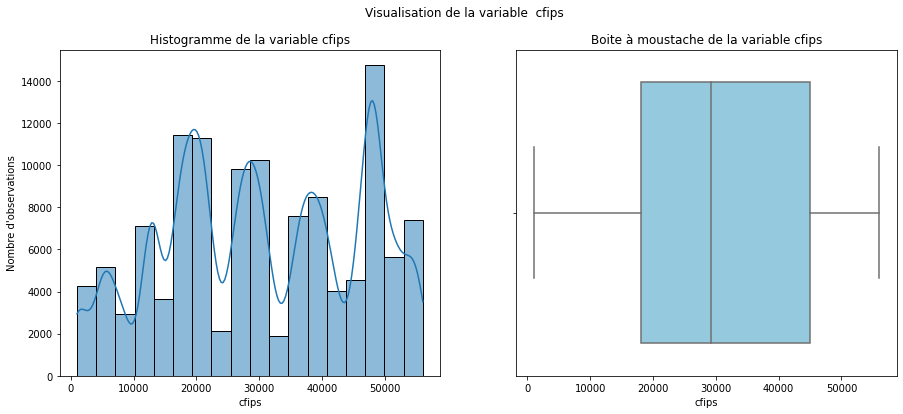

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


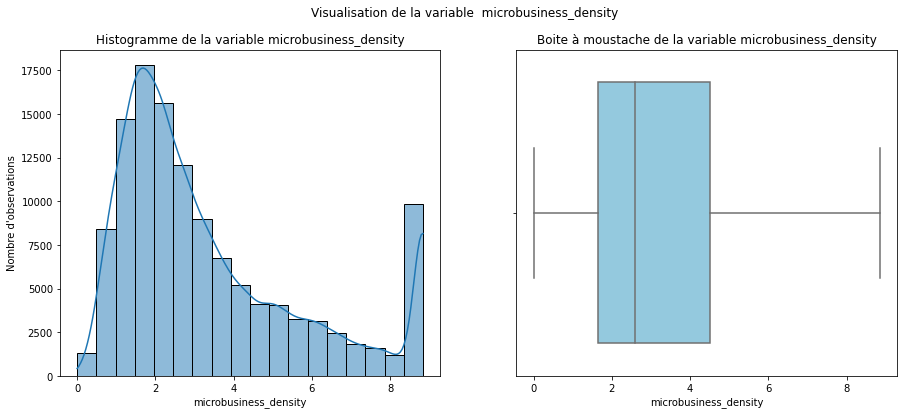

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.378144
std           2.349475
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max           8.839061
Name: microbusiness_density, dtype: float64


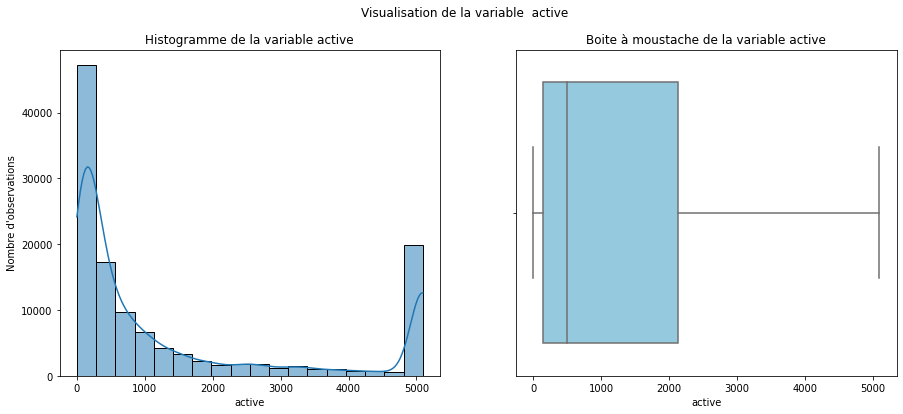

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1455.818251
std        1835.466134
min           0.000000
25%         145.000000
50%         488.000000
75%        2124.000000
max        5092.500000
Name: active, dtype: float64


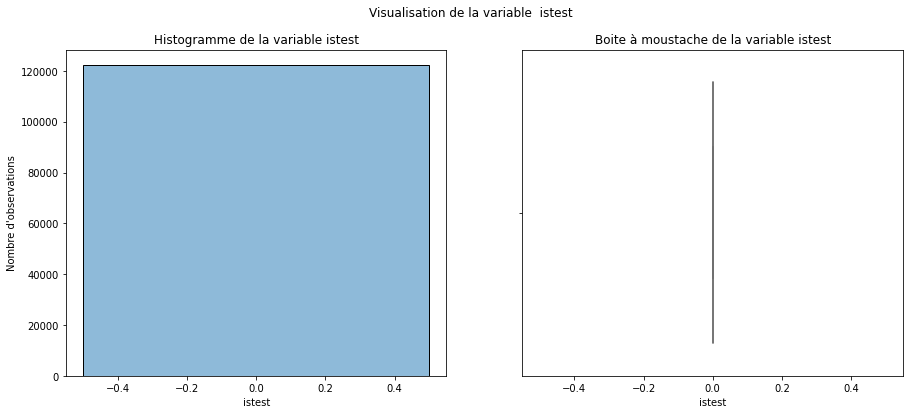

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


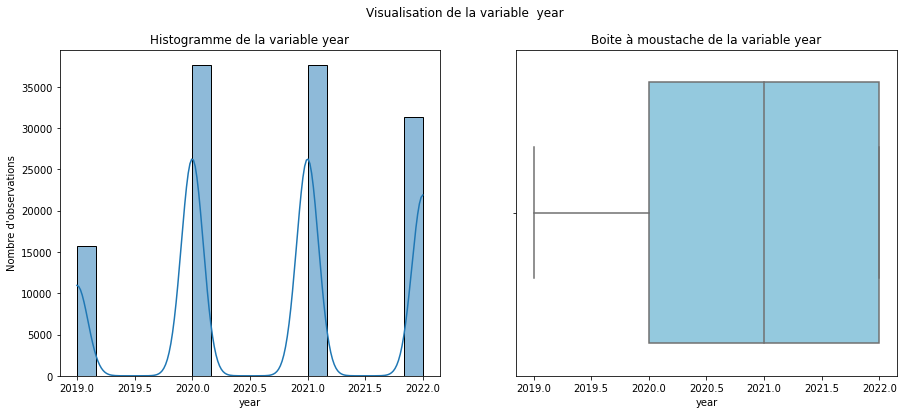

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


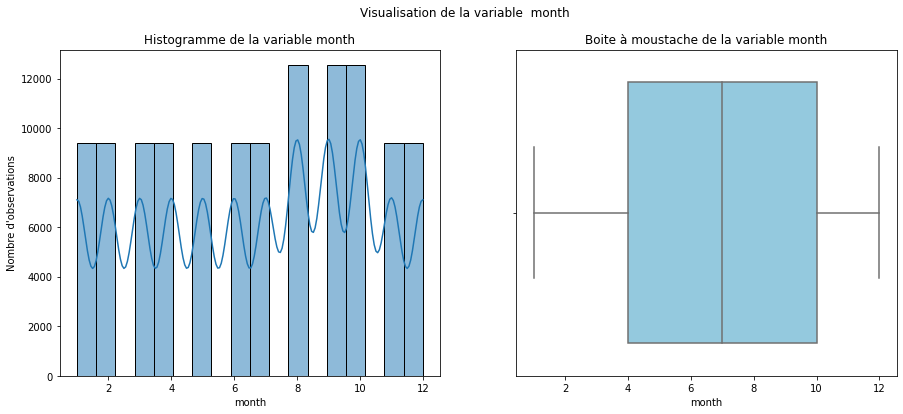

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


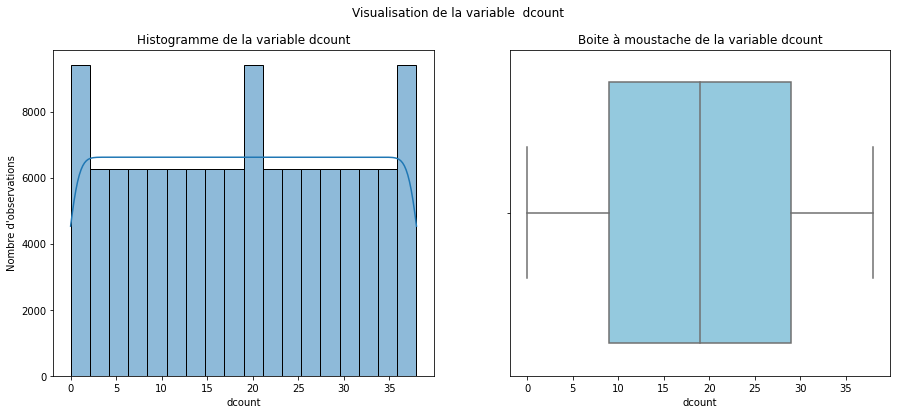

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


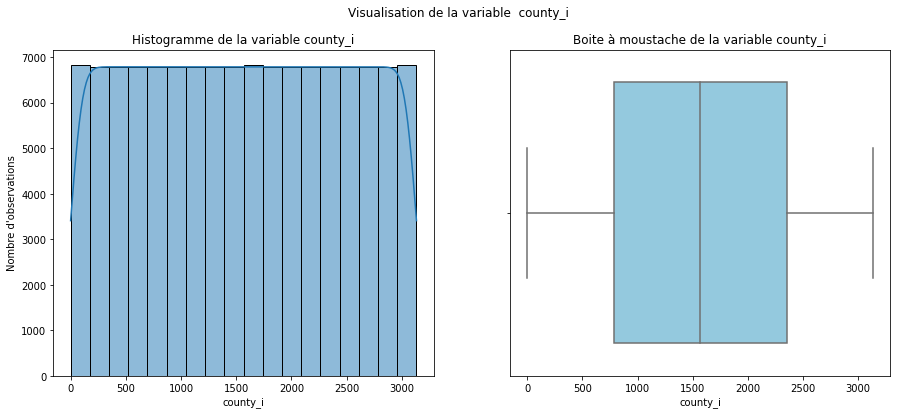

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


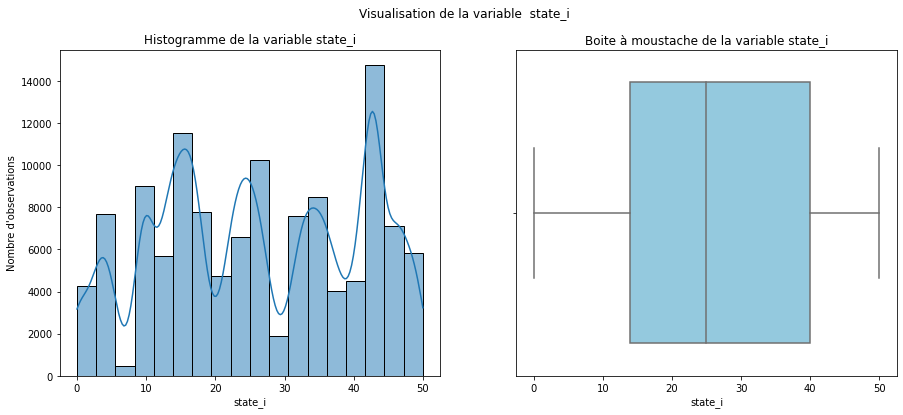

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


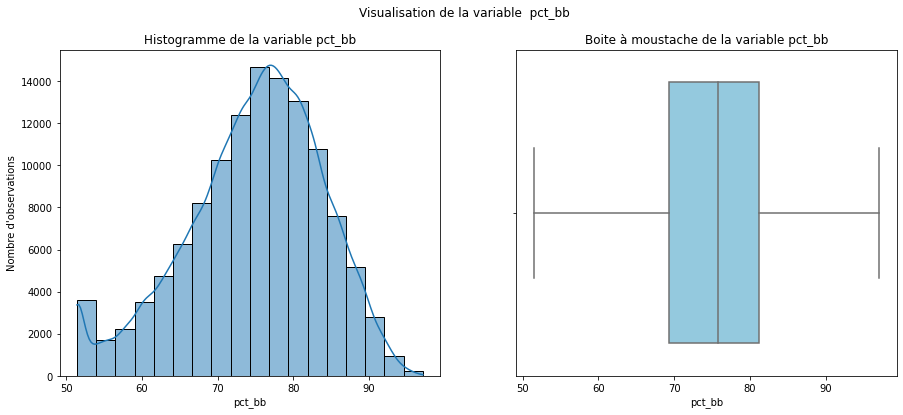

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.788855
std           9.064733
min          51.450000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


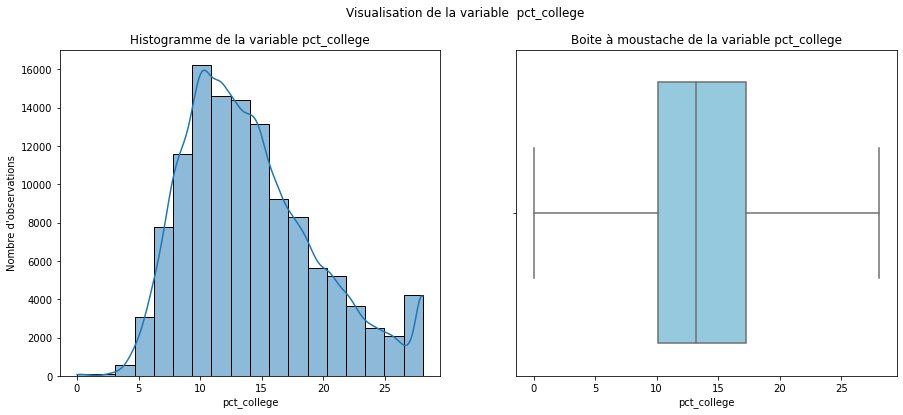

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.00000
mean         14.13029
std           5.40431
min           0.00000
25%          10.10000
50%          13.20000
75%          17.30000
max          28.10000
Name: pct_college, dtype: float64


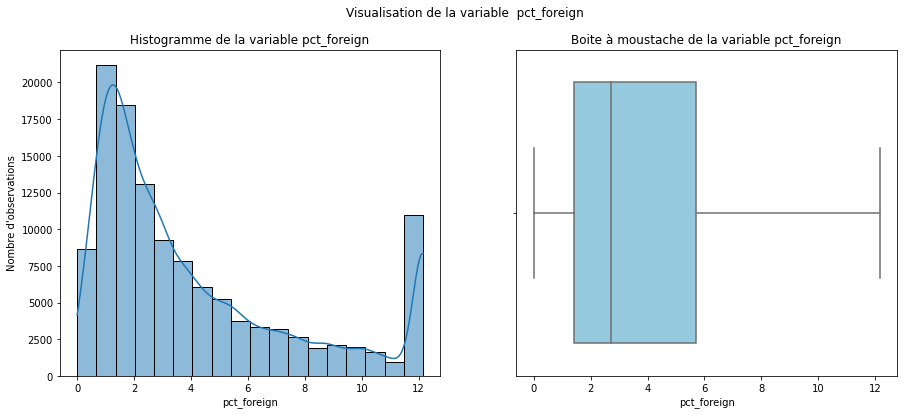

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.080285
std           3.561062
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          12.150000
Name: pct_foreign, dtype: float64


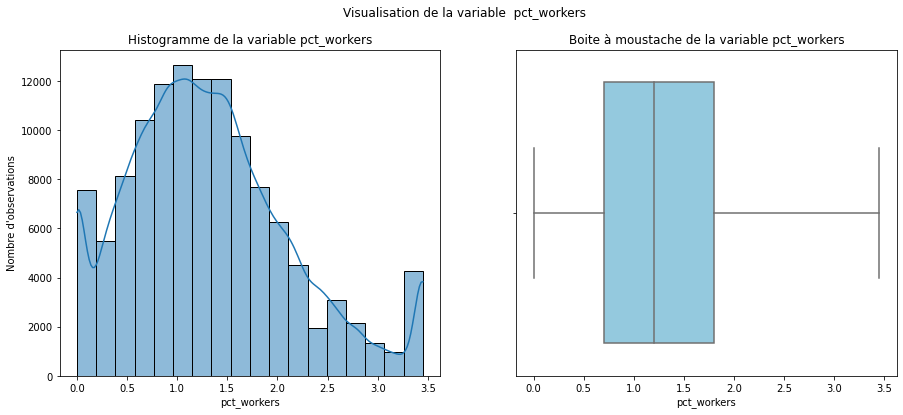

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.320209
std           0.815275
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max           3.450000
Name: pct_workers, dtype: float64


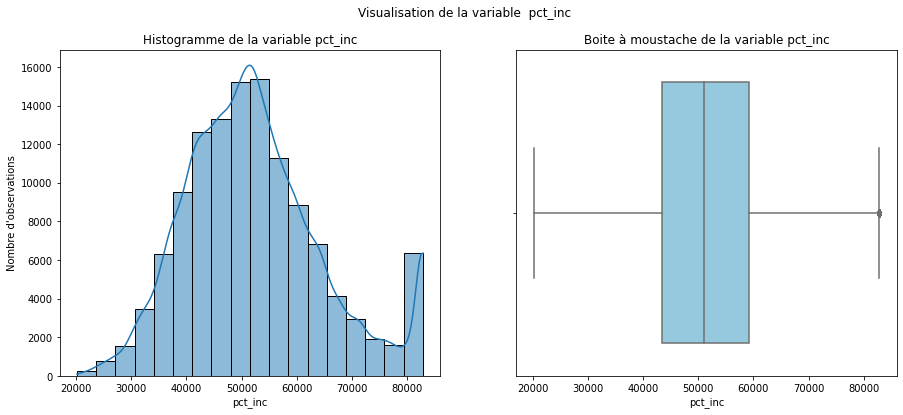

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52330.531644
std       12544.911912
min       20188.000000
25%       43512.000000
50%       51097.000000
75%       59230.000000
max       82814.500000
Name: pct_inc, dtype: float64


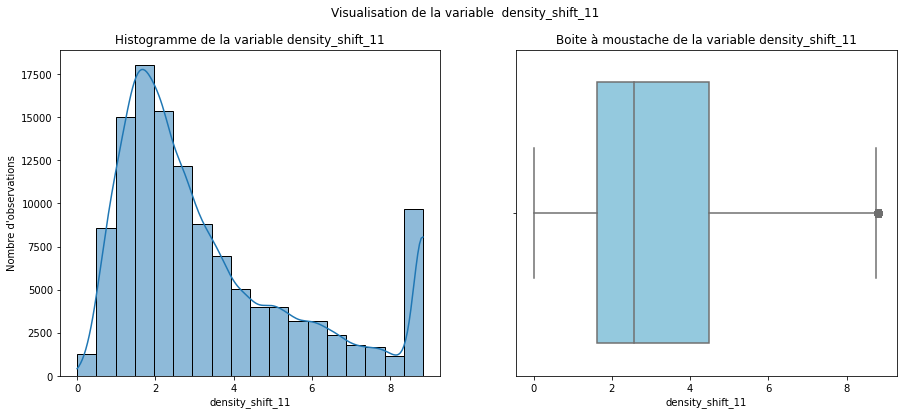

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.355573
std           2.344294
min           0.000000
25%           1.625677
50%           2.568728
75%           4.470059
max           8.839061
Name: density_shift_11, dtype: float64


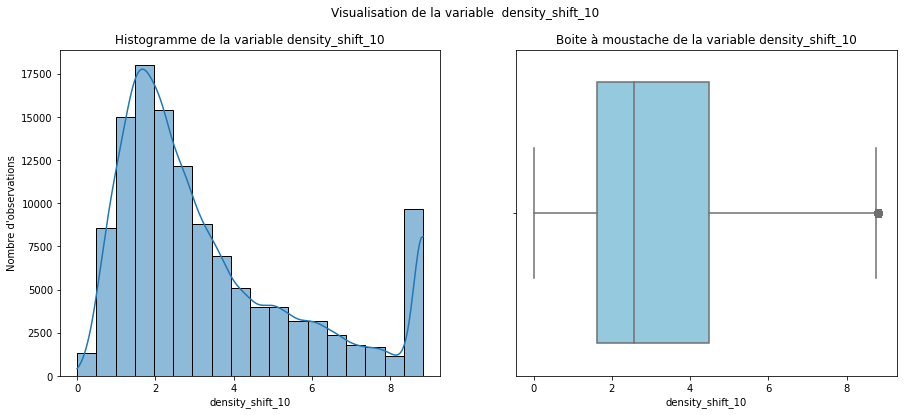

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.356868
std           2.344952
min           0.000000
25%           1.626016
50%           2.569110
75%           4.475314
max           8.839061
Name: density_shift_10, dtype: float64


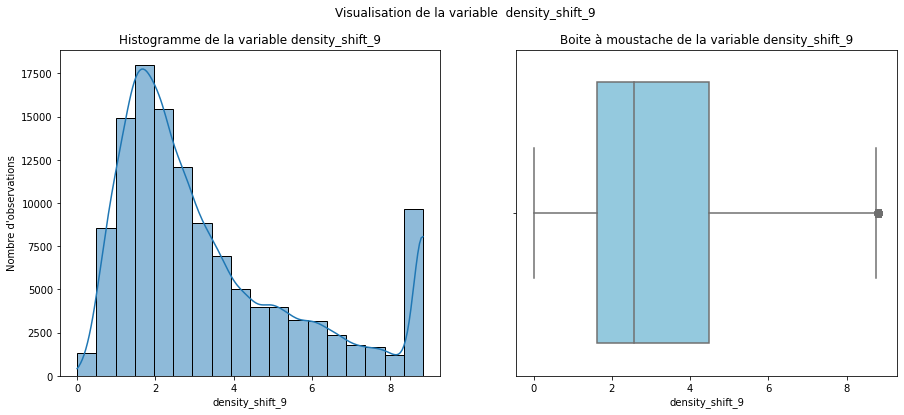

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.357728
std           2.344526
min           0.000000
25%           1.627544
50%           2.569269
75%           4.479419
max           8.839061
Name: density_shift_9, dtype: float64


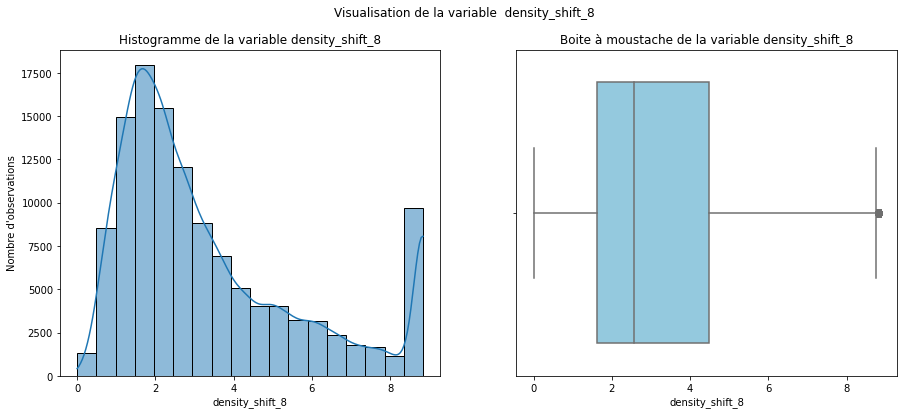

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.358822
std           2.344575
min           0.000000
25%           1.627502
50%           2.570657
75%           4.481247
max           8.839061
Name: density_shift_8, dtype: float64


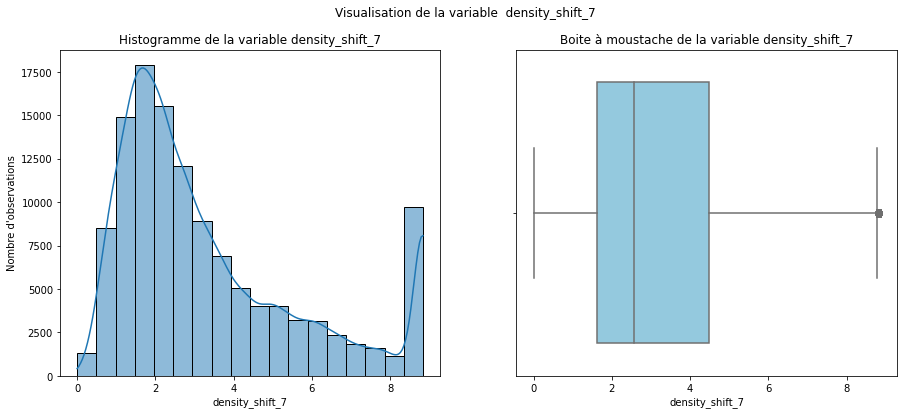

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.360778
std           2.344939
min           0.000000
25%           1.629138
50%           2.572649
75%           4.488442
max           8.839061
Name: density_shift_7, dtype: float64


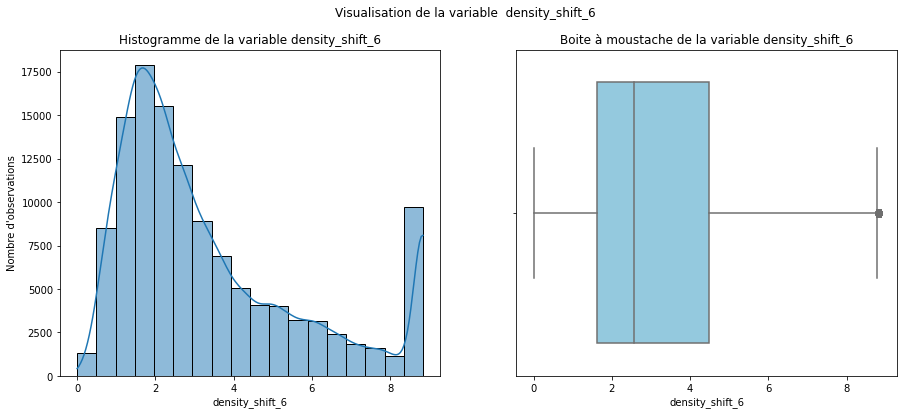

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.362829
std           2.345538
min           0.000000
25%           1.630914
50%           2.573916
75%           4.490528
max           8.839061
Name: density_shift_6, dtype: float64


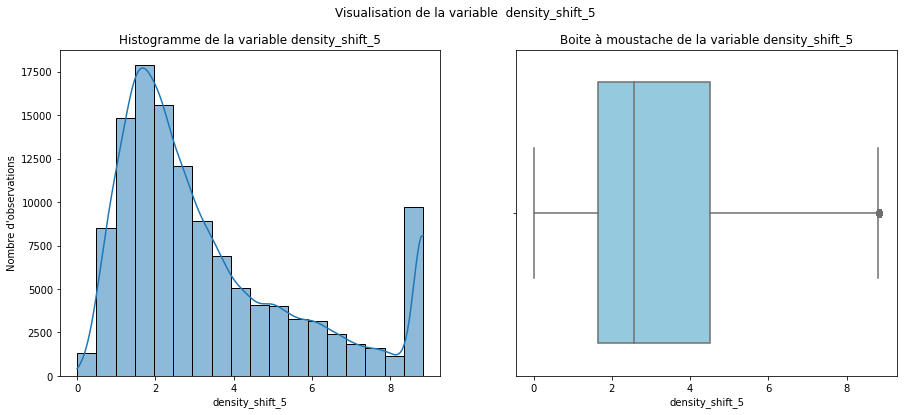

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.364152
std           2.345470
min           0.000000
25%           1.631602
50%           2.574461
75%           4.494822
max           8.839061
Name: density_shift_5, dtype: float64


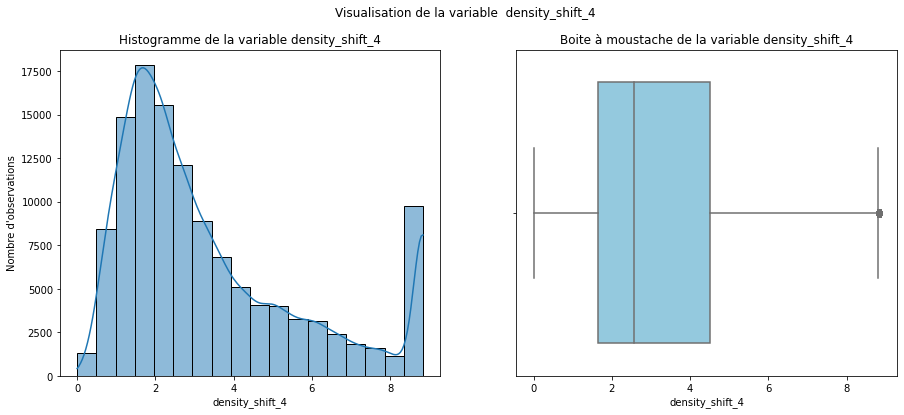

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.365943
std           2.345847
min           0.000000
25%           1.632535
50%           2.576309
75%           4.498283
max           8.839061
Name: density_shift_4, dtype: float64


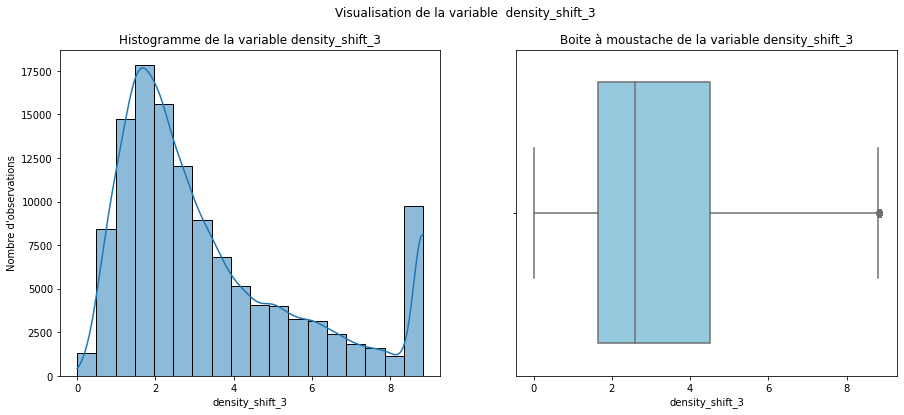

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.369880
std           2.346599
min           0.000000
25%           1.634991
50%           2.580498
75%           4.505376
max           8.839061
Name: density_shift_3, dtype: float64


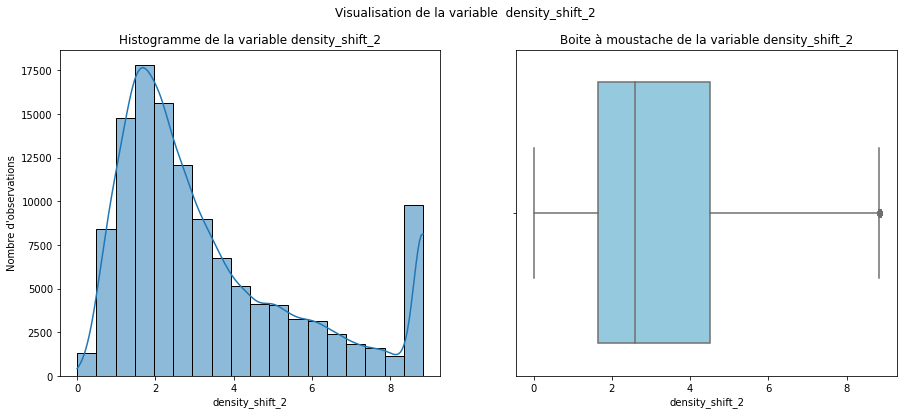

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.372903
std           2.347801
min           0.000000
25%           1.636189
50%           2.582141
75%           4.511774
max           8.839061
Name: density_shift_2, dtype: float64


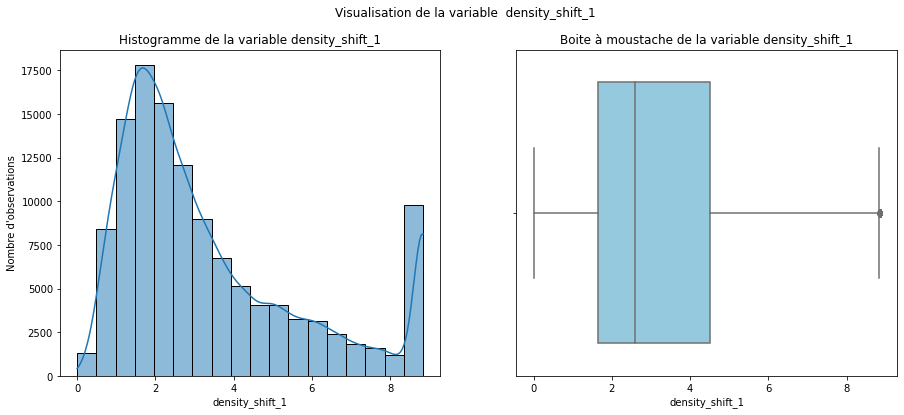

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.375462
std           2.348568
min           0.000000
25%           1.638081
50%           2.584071
75%           4.516003
max           8.839061
Name: density_shift_1, dtype: float64


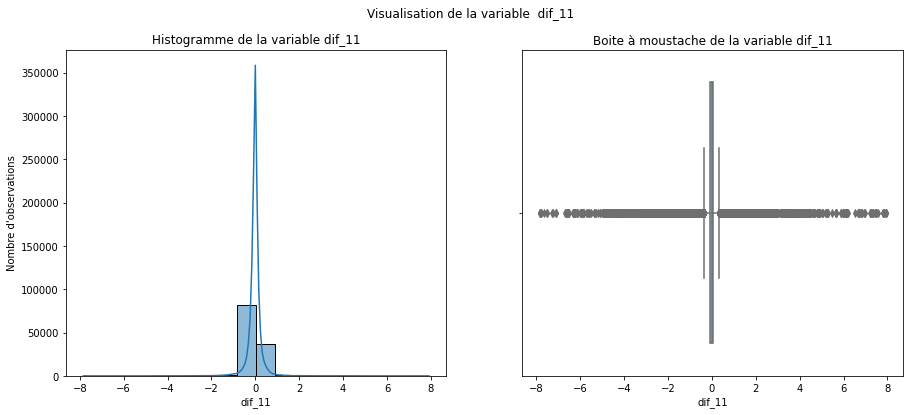

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.022571
std           0.429236
min          -7.839477
25%          -0.103849
50%          -0.001603
75%           0.067176
max           7.919520
Name: dif_11, dtype: float64


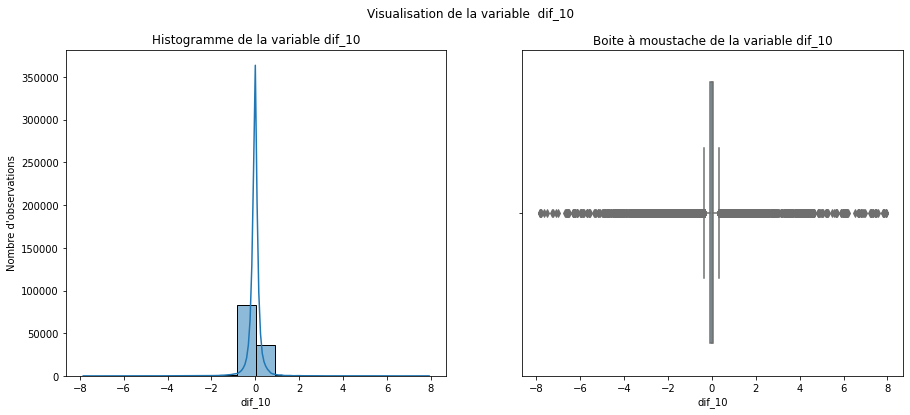

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.021276
std           0.419529
min          -7.839477
25%          -0.102294
50%          -0.001611
75%           0.065997
max           7.919520
Name: dif_10, dtype: float64


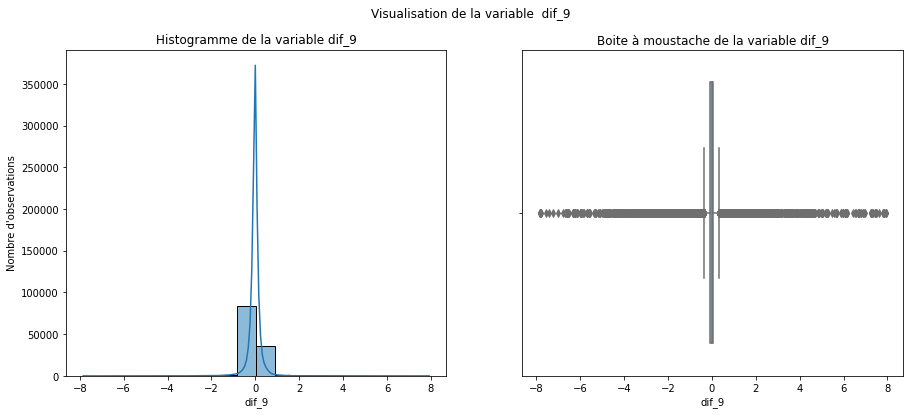

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.020416
std           0.406706
min          -7.839477
25%          -0.099178
50%          -0.003658
75%           0.063889
max           7.919520
Name: dif_9, dtype: float64


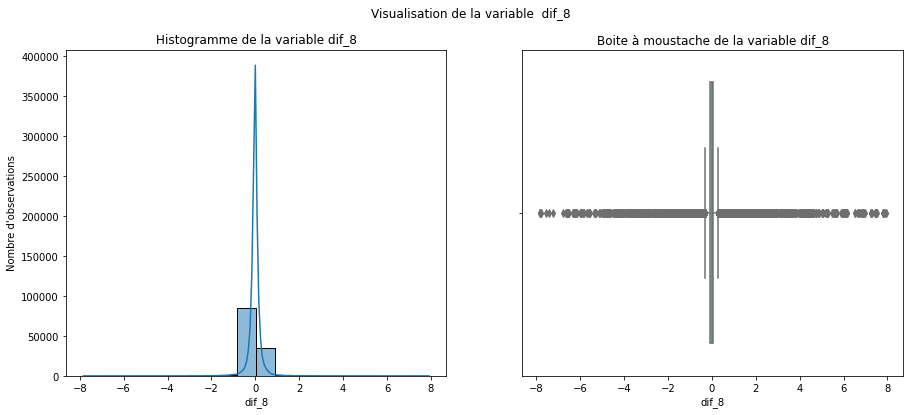

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.019322
std           0.393225
min          -7.839477
25%          -0.094303
50%          -0.003225
75%           0.060348
max           7.919520
Name: dif_8, dtype: float64


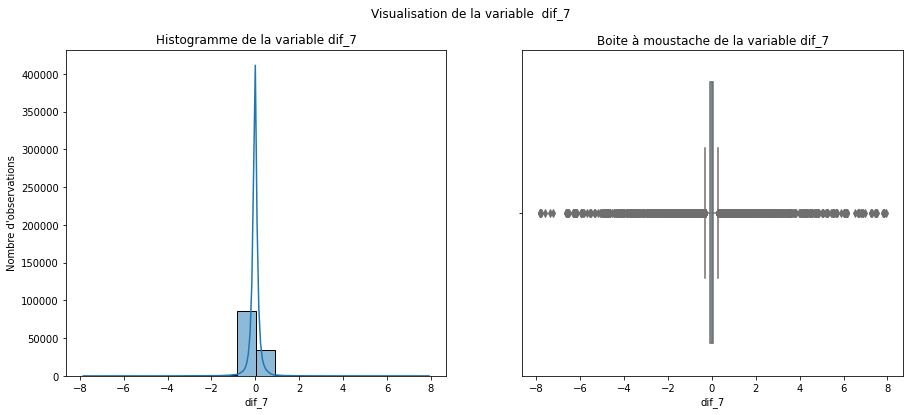

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.017366
std           0.376121
min          -7.839477
25%          -0.087679
50%          -0.004005
75%           0.056802
max           7.919520
Name: dif_7, dtype: float64


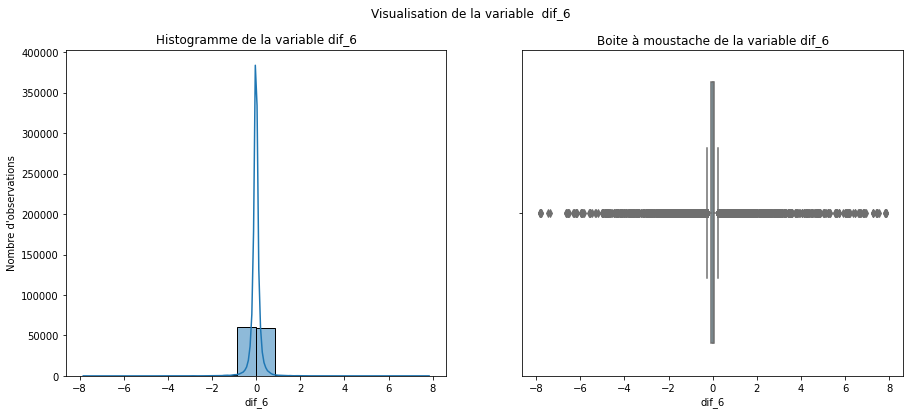

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.015315
std           0.357766
min          -7.839477
25%          -0.080595
50%          -0.002726
75%           0.052573
max           7.839477
Name: dif_6, dtype: float64


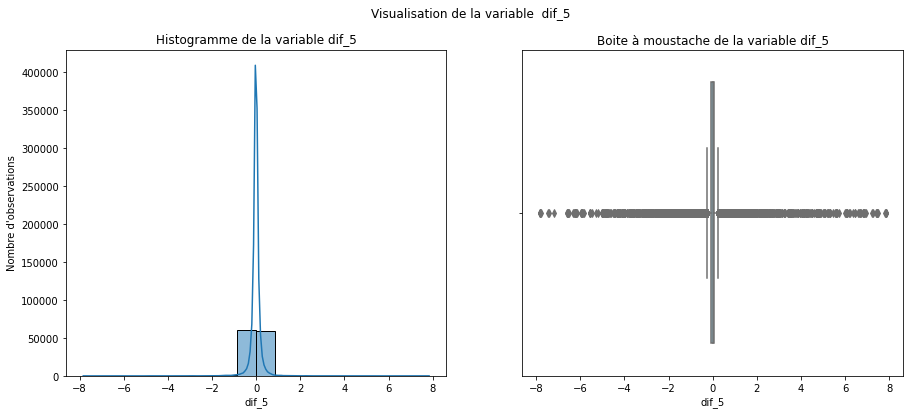

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.013992
std           0.333641
min          -7.839477
25%          -0.072869
50%          -0.002086
75%           0.048019
max           7.839477
Name: dif_5, dtype: float64


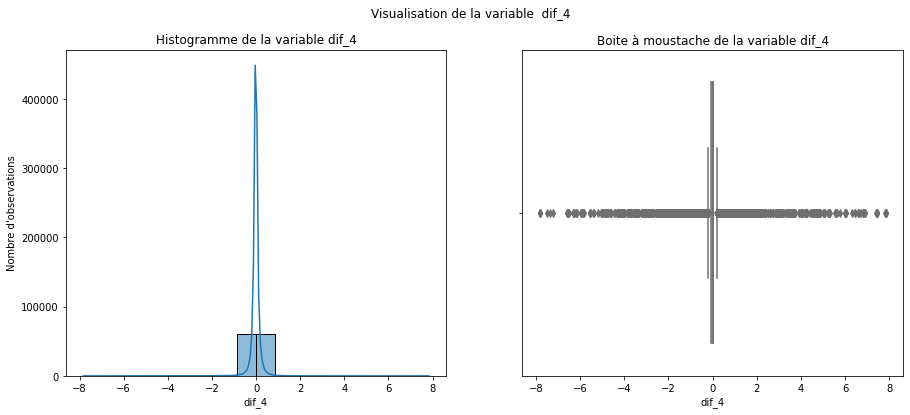

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.012201
std           0.305457
min          -7.839477
25%          -0.062696
50%          -0.000536
75%           0.040825
max           7.839477
Name: dif_4, dtype: float64


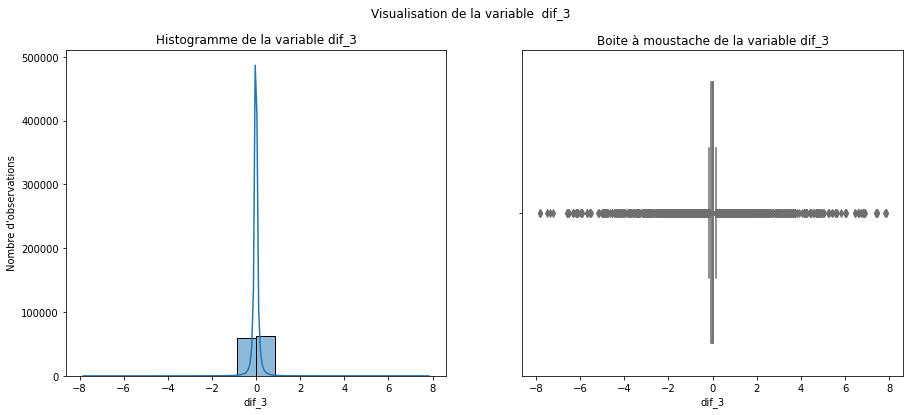

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.008264
std           0.274296
min          -7.839477
25%          -0.051275
50%           0.000000
75%           0.034971
max           7.839477
Name: dif_3, dtype: float64


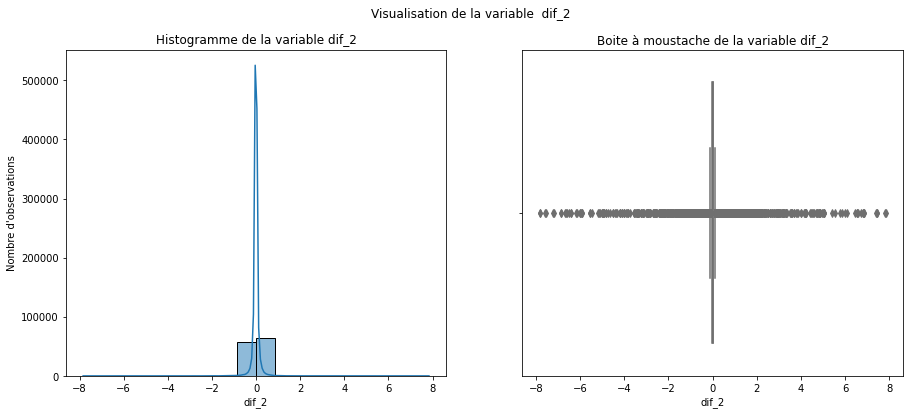

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.005241
std           0.236925
min          -7.839477
25%          -0.038670
50%           0.000000
75%           0.027233
max           7.839477
Name: dif_2, dtype: float64


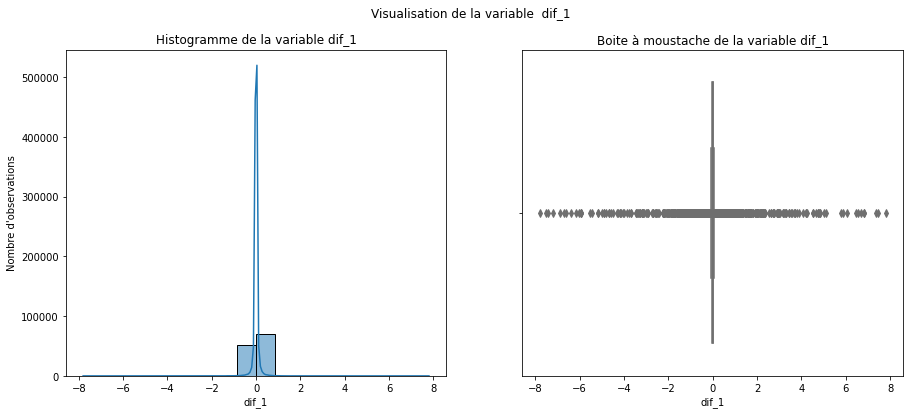

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.002682
std           0.179233
min          -7.805576
25%          -0.023214
50%           0.000000
75%           0.017531
max           7.797828
Name: dif_1, dtype: float64


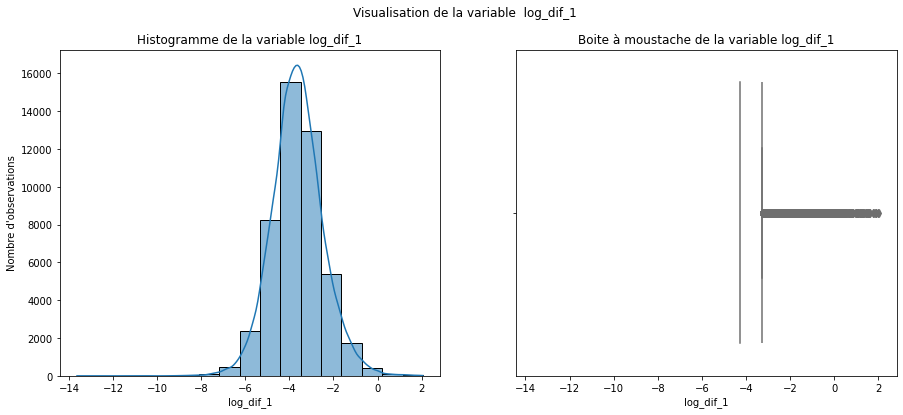

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    6.835700e+04
mean             -inf
std               NaN
min              -inf
25%               NaN
50%     -4.265204e+00
75%     -3.276296e+00
max      2.053845e+00
Name: log_dif_1, dtype: float64


In [833]:
for col in df_train_new_feat_smooth.select_dtypes(include=['float64', 'int64']):
  hist_box_plot(df_train_new_feat_smooth, 
                col, 
                subtitle =f"Visualisation de la variable  {col}",
                hist_title = f'Histogramme de la variable {col}',
                color = 'skyblue')

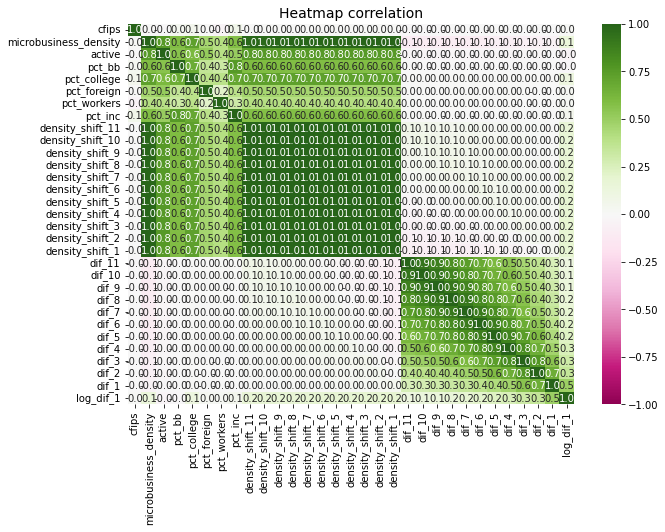

In [834]:
plt.figure(figsize = (10,7))
df_corr = df_train_new_feat_smooth.loc[:, ['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc', 'density_shift_11', 'density_shift_10',
       'density_shift_9', 'density_shift_8', 'density_shift_7',
       'density_shift_6', 'density_shift_5', 'density_shift_4',
       'density_shift_3', 'density_shift_2', 'density_shift_1', 'dif_11',
       'dif_10', 'dif_9', 'dif_8', 'dif_7', 'dif_6', 'dif_5', 'dif_4', 'dif_3',
       'dif_2', 'dif_1', 'log_dif_1']]
plt.title("Heatmap correlation", fontsize =14,loc='center')
heatmap_reg = sns.heatmap(df_corr.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
square=True

#dataframe for prediction with density shift features 

##df pred

In [835]:
df_train_new_feat_smooth.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc', 'density_shift_11', 'density_shift_10',
       'density_shift_9', 'density_shift_8', 'density_shift_7',
       'density_shift_6', 'density_shift_5', 'density_shift_4',
       'density_shift_3', 'density_shift_2', 'density_shift_1', 'dif_11',
       'dif_10', 'dif_9', 'dif_8', 'dif_7', 'dif_6', 'dif_5', 'dif_4', 'dif_3',
       'dif_2', 'dif_1', 'log_dif_1'],
      dtype='object')

In [836]:
df_train_new_feat_smooth

row_id  cfips              county         state  \
0       56045_2022-10-01  56045       Weston County       Wyoming   
1       55041_2022-10-01  55041       Forest County     Wisconsin   
2       48291_2022-10-01  48291      Liberty County         Texas   
3       22089_2022-10-01  22089  St. Charles Parish     Louisiana   
4       53009_2022-10-01  53009      Clallam County    Washington   
...                  ...    ...                 ...           ...   
122260  46009_2019-08-01  46009    Bon Homme County  South Dakota   
122261  18159_2019-08-01  18159       Tipton County       Indiana   
122262  46007_2019-08-01  46007      Bennett County  South Dakota   
122263  18161_2019-08-01  18161        Union County       Indiana   
122264   1001_2019-08-01   1001      Autauga County       Alabama   

       first_day_of_month  microbusiness_density  active  istest  year  month  \
0              2022-10-01               1.785395   100.0       0  2022     10   
1              2022-10-01               1.634575   118.0       0  2022     10   
2              2022-10-01               2.547569  1612.0       0  2022     10   
3              2022-10-01               3.703333  1480.0       0  2022     10   
4              2022-10-01               4.997481  3174.0       0  2022     10   
...                   ...                    ...     ...     ...   ...    ...   
122260         2019-08-01               0.980049    56.0       0  2019      8   
122261         2019-08-01               2.100457   253.0       0  2019      8   
122262         2019-08-01               0.585322    13.0       0  2019      8   
122263         2019-08-01               2.126509   118.0       0  2019      8   
122264         2019-08-01               3.007682  1249.0       0  2019      8   

        dcount  county_i  state_i  pct_bb  pct_college  pct_foreign  \
0           38      3134       50    79.7         12.7          2.3   
1           38      3060       49    76.3         10.7          0.8   
2           38      2664       43    82.7          7.1          9.3   
3           38      1155       18    87.2         21.3          3.7   
4           38      2950       47    86.5         17.5          5.2   
...        ...       ...      ...     ...          ...          ...   
122260       0      2362       41    68.9         12.9          2.0   
122261       0       774       14    74.0         14.0          1.3   
122262       0      2361       41    62.4         14.3          0.5   
122263       0       775       14    63.9         11.7          0.5   
122264       0         0        0    76.6         14.5          2.1   

        pct_workers  pct_inc  density_shift_11  density_shift_10  \
0               0.0  53333.0          1.760374          1.796300   
1               0.5  48394.0          1.556204          1.583993   
2               1.1  50917.0          2.402665          2.436619   
3               1.2  68113.0          3.834356          3.841899   
4               0.7  55090.0          4.952653          4.935028   
...             ...      ...               ...               ...   
122260          0.3  52923.0          1.091039          1.091039   
122261          0.8  53931.0          2.076081          2.076611   
122262          0.9  45725.0          0.498421          0.500227   
122263          1.3  45531.0          1.552951          1.556072   
122264          1.3  55317.0          3.069840          3.083837   

        density_shift_9  density_shift_8  density_shift_7  density_shift_6  \
0              1.749688         1.749688         1.767542         1.767542   
1              1.593018         1.606871         1.703837         1.662280   
2              2.394273         2.402175         2.400594         2.425880   
3              3.818437         3.780903         3.693324         3.695826   
4              4.880967         4.882542         4.929777         4.956543   
...                 ...              ...              ...              ...   


In [837]:
df_pred_density = df_train_new_feat_smooth.loc[:, ['row_id', 'active', 'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc', 'density_shift_11', 'density_shift_10',
       'density_shift_9', 'density_shift_8', 'density_shift_7',
       'density_shift_6', 'density_shift_5', 'density_shift_4',
       'density_shift_3', 'density_shift_2', 'density_shift_1', 'microbusiness_density']]

In [838]:
df_pred_density.set_index(['row_id'], inplace=True)

In [839]:
df_pred_density

active  year  month  dcount  county_i  state_i  pct_bb  \
row_id                                                                     
56045_2022-10-01   100.0  2022     10      38      3134       50    79.7   
55041_2022-10-01   118.0  2022     10      38      3060       49    76.3   
48291_2022-10-01  1612.0  2022     10      38      2664       43    82.7   
22089_2022-10-01  1480.0  2022     10      38      1155       18    87.2   
53009_2022-10-01  3174.0  2022     10      38      2950       47    86.5   
...                  ...   ...    ...     ...       ...      ...     ...   
46009_2019-08-01    56.0  2019      8       0      2362       41    68.9   
18159_2019-08-01   253.0  2019      8       0       774       14    74.0   
46007_2019-08-01    13.0  2019      8       0      2361       41    62.4   
18161_2019-08-01   118.0  2019      8       0       775       14    63.9   
1001_2019-08-01   1249.0  2019      8       0         0        0    76.6   

                  pct_college  pct_foreign  pct_workers  pct_inc  \
row_id                                                             
56045_2022-10-01         12.7          2.3          0.0  53333.0   
55041_2022-10-01         10.7          0.8          0.5  48394.0   
48291_2022-10-01          7.1          9.3          1.1  50917.0   
22089_2022-10-01         21.3          3.7          1.2  68113.0   
53009_2022-10-01         17.5          5.2          0.7  55090.0   
...                       ...          ...          ...      ...   
46009_2019-08-01         12.9          2.0          0.3  52923.0   
18159_2019-08-01         14.0          1.3          0.8  53931.0   
46007_2019-08-01         14.3          0.5          0.9  45725.0   
18161_2019-08-01         11.7          0.5          1.3  45531.0   
1001_2019-08-01          14.5          2.1          1.3  55317.0   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01          1.760374          1.796300         1.749688   
55041_2022-10-01          1.556204          1.583993         1.593018   
48291_2022-10-01          2.402665          2.436619         2.394273   
22089_2022-10-01          3.834356          3.841899         3.818437   
53009_2022-10-01          4.952653          4.935028         4.880967   
...                            ...               ...              ...   
46009_2019-08-01          1.091039          1.091039         1.099982   
18159_2019-08-01          2.076081          2.076611         2.077711   
46007_2019-08-01          0.498421          0.500227         0.521730   
18161_2019-08-01          1.552951          1.556072         1.561961   
1001_2019-08-01           3.069840          3.083837         3.094971   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01         1.749688         1.767542         1.767542   
55041_2022-10-01         1.606871         1.703837         1.662280   
48291_2022-10-01         2.402175         2.400594         2.425880   
22089_2022-10-01         3.780903         3.693324         3.695826   
53009_2022-10-01         4.882542         4.929777         4.956543   
...                           ...              ...              ...   
46009_2019-08-01         1.108925         1.122443         1.135960   
18159_2019-08-01         2.076611         2.076081         2.075550   
46007_2019-08-01         0.543232         0.544467         0.545703   
18161_2019-08-01         1.567850         1.567850         1.567850   
1001_2019-08-01          3.106106         3.125074         3.144043   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01         1.803249         1.803249         1.803249   
55041_2022-10-01         1.634575         1.634575       

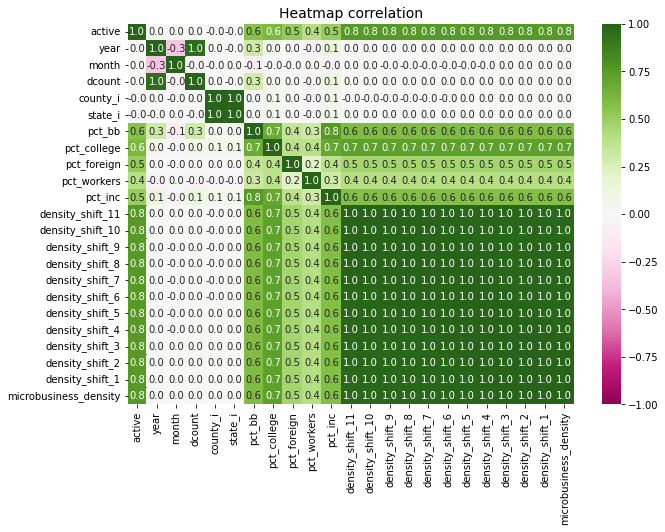

In [840]:
plt.figure(figsize = (10,7))
plt.title("Heatmap correlation", fontsize =14,loc='center')
heatmap_reg = sns.heatmap(df_pred_density.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
square=True

In [841]:
df_pred_density.describe()

active           year          month         dcount  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean     1455.818251    2020.692308       6.692308      19.000000   
std      1835.466134       0.991089       3.390452      11.254675   
min         0.000000    2019.000000       1.000000       0.000000   
25%       145.000000    2020.000000       4.000000       9.000000   
50%       488.000000    2021.000000       7.000000      19.000000   
75%      2124.000000    2022.000000      10.000000      29.000000   
max      5092.500000    2022.000000      12.000000      38.000000   

            county_i        state_i         pct_bb   pct_college  \
count  122265.000000  122265.000000  122265.000000  122265.00000   
mean     1567.000000      26.229665      74.788855      14.13029   
std       905.000202      14.253994       9.064733       5.40431   
min         0.000000       0.000000      51.450000       0.00000   
25%       783.000000      14.000000      69.300000      10.10000   
50%      1567.000000      25.000000      75.800000      13.20000   
75%      2351.000000      40.000000      81.200000      17.30000   
max      3134.000000      50.000000      97.100000      28.10000   

         pct_foreign    pct_workers        pct_inc  density_shift_11  \
count  122265.000000  122265.000000  122265.000000     122265.000000   
mean        4.080285       1.320209   52330.531644          3.355573   
std         3.561062       0.815275   12544.911912          2.344294   
min         0.000000       0.000000   20188.000000          0.000000   
25%         1.400000       0.700000   43512.000000          1.625677   
50%         2.700000       1.200000   51097.000000          2.568728   
75%         5.700000       1.800000   59230.000000          4.470059   
max        12.150000       3.450000   82814.500000          8.839061   

       density_shift_10  density_shift_9  density_shift_8  density_shift_7  \
count     122265.000000    122265.000000    122265.000000    122265.000000   
mean           3.356868         3.357728         3.358822         3.360778   
std            2.344952         2.344526         2.344575         2.344939   
min            0.000000         0.000000         0.000000         0.000000   
25%            1.626016         1.627544         1.627502         1.629138   
50%            2.569110         2.569269         2.570657         2.572649   
75%            4.475314         4.479419         4.481247         4.488442   
max            8.839061         8.839061         8.839061         8.839061   

       density_shift_6  density_shift_5  density_shift_4  density_shift_3  \
count    122265.000000    122265.000000    122265.000000    122265.000000   
mean          3.362829         3.364152         3.365943         3.369880   
std           2.345538         2.345470         2.345847         2.346599   
min           0.000000         0.000000         0.000000         0.000000   
25%           1.630914         1.631602         1.632535         1.634991   
50%           2.573916         2.574461         2.576309         2.580498   
75%           4.490528         4.494822         4.498283         4.505376   
max           8.839061         8.839061         8.839061         8.839061   

       density_shift_2  density_shift_1  microbusiness_density  
count    122265.000000    122265.000000          122265.000000  
mean          3.372903         3.375462               3.378144  
std           2.347801         2.348568               2.349475  
min           0.000000         0.000000               0.000000  
25%           1.636189         1.638081               1.639344  
50%           2.582141         2.584071               2.586543  
75%           4.511774         4.516003               4.519231  
max           8.839061         8.839061               8.839061

In [842]:
df_pred_density.isna().sum()

active                   0
year                     0
month                    0
dcount                   0
county_i                 0
state_i                  0
pct_bb                   0
pct_college              0
pct_foreign              0
pct_workers              0
pct_inc                  0
density_shift_11         0
density_shift_10         0
density_shift_9          0
density_shift_8          0
density_shift_7          0
density_shift_6          0
density_shift_5          0
density_shift_4          0
density_shift_3          0
density_shift_2          0
density_shift_1          0
microbusiness_density    0
dtype: int64

##Data features/target

In [843]:
X_density = df_pred_density.iloc[:,:-1].copy(deep=True)
y_density = df_pred_density["microbusiness_density"].copy(deep=True)

##Preproc - Normalisation 

###RobustScaler

In [844]:
X_density_to_rs = X_density.iloc[:,6:]
X_density_to_rs

pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  \
row_id                                                                     
56045_2022-10-01    79.7         12.7          2.3          0.0  53333.0   
55041_2022-10-01    76.3         10.7          0.8          0.5  48394.0   
48291_2022-10-01    82.7          7.1          9.3          1.1  50917.0   
22089_2022-10-01    87.2         21.3          3.7          1.2  68113.0   
53009_2022-10-01    86.5         17.5          5.2          0.7  55090.0   
...                  ...          ...          ...          ...      ...   
46009_2019-08-01    68.9         12.9          2.0          0.3  52923.0   
18159_2019-08-01    74.0         14.0          1.3          0.8  53931.0   
46007_2019-08-01    62.4         14.3          0.5          0.9  45725.0   
18161_2019-08-01    63.9         11.7          0.5          1.3  45531.0   
1001_2019-08-01     76.6         14.5          2.1          1.3  55317.0   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01          1.760374          1.796300         1.749688   
55041_2022-10-01          1.556204          1.583993         1.593018   
48291_2022-10-01          2.402665          2.436619         2.394273   
22089_2022-10-01          3.834356          3.841899         3.818437   
53009_2022-10-01          4.952653          4.935028         4.880967   
...                            ...               ...              ...   
46009_2019-08-01          1.091039          1.091039         1.099982   
18159_2019-08-01          2.076081          2.076611         2.077711   
46007_2019-08-01          0.498421          0.500227         0.521730   
18161_2019-08-01          1.552951          1.556072         1.561961   
1001_2019-08-01           3.069840          3.083837         3.094971   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01         1.749688         1.767542         1.767542   
55041_2022-10-01         1.606871         1.703837         1.662280   
48291_2022-10-01         2.402175         2.400594         2.425880   
22089_2022-10-01         3.780903         3.693324         3.695826   
53009_2022-10-01         4.882542         4.929777         4.956543   
...                           ...              ...              ...   
46009_2019-08-01         1.108925         1.122443         1.135960   
18159_2019-08-01         2.076611         2.076081         2.075550   
46007_2019-08-01         0.543232         0.544467         0.545703   
18161_2019-08-01         1.567850         1.567850         1.567850   
1001_2019-08-01          3.106106         3.125074         3.144043   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01         1.803249         1.803249         1.803249   
55041_2022-10-01         1.634575         1.634575         1.620723   
48291_2022-10-01         2.430621         2.457488         2.538087   
22089_2022-10-01         3.683315         3.648283         3.725853   
53009_2022-10-01         4.921905         4.898287         4.983310   
...                           ...              ...              ...   
46009_2019-08-01         1.144835         1.153710         1.158042   
18159_2019-08-01         2.074584         2.073618         2.072040   
46007_2019-08-01         0.545703         0.545703         0.545703   
18161_2019-08-01         1.570904         1.573958         1.582901   
1001_2019-08-01          3.159361         3.174679         3.180700   

                  density_shift_2  density_shift_1  
row_id                                              
56045_2022-10-01         1.785395         1.785395  
55041_2022-10-01         1.593018         1.634575  
48291_2022-10-01   

In [845]:
#get data more normalize with RobustScaler
X_density_rs = RobustScaler().fit_transform(X_density_to_rs)
X_density_rs

array([[ 0.32773109, -0.06944444, -0.09302326, ..., -0.27078186,
        -0.27707241, -0.27751807],
       [ 0.04201681, -0.34722222, -0.44186047, ..., -0.33437138,
        -0.34397256, -0.32992399],
       [ 0.57983193, -0.84722222,  1.53488372, ..., -0.01477523,
        -0.01641909, -0.01433062],
       ...,
       [-1.12605042,  0.15277778, -0.51162791, ..., -0.70889275,
        -0.70818215, -0.7082779 ],
       [-1.        , -0.20833333, -0.51162791, ..., -0.34754799,
        -0.34438093, -0.34746607],
       [ 0.06722689,  0.18055556, -0.13953488, ...,  0.20910185,
         0.21024626,  0.21063537]])

In [846]:
df_X_density_rs_ = pd.DataFrame(data=X_density_rs, columns=X_density_to_rs.columns, index = X_density_to_rs.index)
df_X_density_rs_

pct_bb  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                                        
56045_2022-10-01  0.327731    -0.069444    -0.093023    -1.090909  0.142257   
55041_2022-10-01  0.042017    -0.347222    -0.441860    -0.636364 -0.171968   
48291_2022-10-01  0.579832    -0.847222     1.534884    -0.090909 -0.011452   
22089_2022-10-01  0.957983     1.125000     0.232558     0.000000  1.082580   
53009_2022-10-01  0.899160     0.597222     0.581395    -0.454545  0.254040   
...                    ...          ...          ...          ...       ...   
46009_2019-08-01 -0.579832    -0.041667    -0.162791    -0.818182  0.116173   
18159_2019-08-01 -0.151261     0.111111    -0.325581    -0.363636  0.180303   
46007_2019-08-01 -1.126050     0.152778    -0.511628    -0.272727 -0.341774   
18161_2019-08-01 -1.000000    -0.208333    -0.511628     0.090909 -0.354116   
1001_2019-08-01   0.067227     0.180556    -0.139535     0.090909  0.268482   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.284193         -0.271228        -0.287383   
55041_2022-10-01         -0.355973         -0.345740        -0.342319   
48291_2022-10-01         -0.058383         -0.046499        -0.061362   
22089_2022-10-01          0.444957          0.446703         0.438016   
53009_2022-10-01          0.838117          0.830351         0.810589   
...                            ...               ...              ...   
46009_2019-08-01         -0.519511         -0.518749        -0.515200   
18159_2019-08-01         -0.173200         -0.172849        -0.172363   
46007_2019-08-01         -0.727858         -0.726103        -0.717963   
18161_2019-08-01         -0.357117         -0.355539        -0.353209   
1001_2019-08-01           0.176176          0.180651         0.184336   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.287682        -0.281575        -0.281987   
55041_2022-10-01        -0.337727        -0.303854        -0.318797   
48291_2022-10-01        -0.059039        -0.060174        -0.051768   
22089_2022-10-01         0.424090         0.391940         0.392329   
53009_2022-10-01         0.810123         0.824371         0.833199   
...                           ...              ...              ...   
46009_2019-08-01        -0.512216        -0.507189        -0.502850   
18159_2019-08-01        -0.173122        -0.173668        -0.174277   
46007_2019-08-01        -0.710444        -0.709327        -0.709261   
18161_2019-08-01        -0.351401        -0.351414        -0.351819   
1001_2019-08-01          0.187630         0.193203         0.199372   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.269351        -0.269758        -0.270782   
55041_2022-10-01        -0.328262        -0.328617        -0.334371   
48291_2022-10-01        -0.050237        -0.041463        -0.014775   
22089_2022-10-01         0.387275         0.374064         0.399025   
53009_2022-10-01         0.819861         0.810252         0.837105   
...                           ...              ...              ...   
46009_2019-08-01        -0.499307        -0.496415        -0.495563   
18159_2019-08-01        -0.174586        -0.175414        -0.177139   
46007_2019-08-01        -0.708558        -0.708578        -0.708893   
18161_2019-08-01        -0.350500        -0.349769        -0.347548   
1001_2019-08-01          0.204280         0.208801         0.209102   

                  density_shift_2  density_shift_1  
row_id                                              
56045_2022-10-01        -0.277072        -0.277518  
55041_2022-10-01        -0.343973  

In [847]:
X_density_= X_density.iloc[:,:6]
X_density_

active  year  month  dcount  county_i  state_i
row_id                                                          
56045_2022-10-01   100.0  2022     10      38      3134       50
55041_2022-10-01   118.0  2022     10      38      3060       49
48291_2022-10-01  1612.0  2022     10      38      2664       43
22089_2022-10-01  1480.0  2022     10      38      1155       18
53009_2022-10-01  3174.0  2022     10      38      2950       47
...                  ...   ...    ...     ...       ...      ...
46009_2019-08-01    56.0  2019      8       0      2362       41
18159_2019-08-01   253.0  2019      8       0       774       14
46007_2019-08-01    13.0  2019      8       0      2361       41
18161_2019-08-01   118.0  2019      8       0       775       14
1001_2019-08-01   1249.0  2019      8       0         0        0

[122265 rows x 6 columns]

In [848]:
df_X_density_rs = pd.concat([X_density_, df_X_density_rs_], axis=1)
df_X_density_rs

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
56045_2022-10-01   100.0  2022     10      38      3134       50  0.327731   
55041_2022-10-01   118.0  2022     10      38      3060       49  0.042017   
48291_2022-10-01  1612.0  2022     10      38      2664       43  0.579832   
22089_2022-10-01  1480.0  2022     10      38      1155       18  0.957983   
53009_2022-10-01  3174.0  2022     10      38      2950       47  0.899160   
...                  ...   ...    ...     ...       ...      ...       ...   
46009_2019-08-01    56.0  2019      8       0      2362       41 -0.579832   
18159_2019-08-01   253.0  2019      8       0       774       14 -0.151261   
46007_2019-08-01    13.0  2019      8       0      2361       41 -1.126050   
18161_2019-08-01   118.0  2019      8       0       775       14 -1.000000   
1001_2019-08-01   1249.0  2019      8       0         0        0  0.067227   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
56045_2022-10-01    -0.069444    -0.093023    -1.090909  0.142257   
55041_2022-10-01    -0.347222    -0.441860    -0.636364 -0.171968   
48291_2022-10-01    -0.847222     1.534884    -0.090909 -0.011452   
22089_2022-10-01     1.125000     0.232558     0.000000  1.082580   
53009_2022-10-01     0.597222     0.581395    -0.454545  0.254040   
...                       ...          ...          ...       ...   
46009_2019-08-01    -0.041667    -0.162791    -0.818182  0.116173   
18159_2019-08-01     0.111111    -0.325581    -0.363636  0.180303   
46007_2019-08-01     0.152778    -0.511628    -0.272727 -0.341774   
18161_2019-08-01    -0.208333    -0.511628     0.090909 -0.354116   
1001_2019-08-01      0.180556    -0.139535     0.090909  0.268482   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.284193         -0.271228        -0.287383   
55041_2022-10-01         -0.355973         -0.345740        -0.342319   
48291_2022-10-01         -0.058383         -0.046499        -0.061362   
22089_2022-10-01          0.444957          0.446703         0.438016   
53009_2022-10-01          0.838117          0.830351         0.810589   
...                            ...               ...              ...   
46009_2019-08-01         -0.519511         -0.518749        -0.515200   
18159_2019-08-01         -0.173200         -0.172849        -0.172363   
46007_2019-08-01         -0.727858         -0.726103        -0.717963   
18161_2019-08-01         -0.357117         -0.355539        -0.353209   
1001_2019-08-01           0.176176          0.180651         0.184336   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.287682        -0.281575        -0.281987   
55041_2022-10-01        -0.337727        -0.303854        -0.318797   
48291_2022-10-01        -0.059039        -0.060174        -0.051768   
22089_2022-10-01         0.424090         0.391940         0.392329   
53009_2022-10-01         0.810123         0.824371         0.833199   
...                           ...              ...              ...   
46009_2019-08-01        -0.512216        -0.507189        -0.502850   
18159_2019-08-01        -0.173122        -0.173668        -0.174277   
46007_2019-08-01        -0.710444        -0.709327        -0.709261   
18161_2019-08-01        -0.351401        -0.351414        -0.351819   
1001_2019-08-01          0.187630         0.193203         0.199372   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.269351        -0.269758        -0.270782   
55041_2022-10-01  

In [849]:
y_density_shift_gb_train=y_density_shift_gb[train_start:train_end]
y_density_shift_gb_train

row_id
1027_2022-05-01     1.677725
31061_2022-05-01    2.192801
29203_2022-05-01    2.144189
5001_2022-05-01     1.715955
54079_2022-05-01    2.564511
                      ...   
46009_2019-08-01    0.980049
18159_2019-08-01    2.100457
46007_2019-08-01    0.585322
18161_2019-08-01    2.126509
1001_2019-08-01     3.007682
Name: microbusiness_density, Length: 103925, dtype: float64

###Standard Scaler

In [850]:
X_density_to_Sts = X_density.iloc[:,6:]
X_density_to_Sts

pct_bb  pct_college  pct_foreign  pct_workers  pct_inc  \
row_id                                                                     
56045_2022-10-01    79.7         12.7          2.3          0.0  53333.0   
55041_2022-10-01    76.3         10.7          0.8          0.5  48394.0   
48291_2022-10-01    82.7          7.1          9.3          1.1  50917.0   
22089_2022-10-01    87.2         21.3          3.7          1.2  68113.0   
53009_2022-10-01    86.5         17.5          5.2          0.7  55090.0   
...                  ...          ...          ...          ...      ...   
46009_2019-08-01    68.9         12.9          2.0          0.3  52923.0   
18159_2019-08-01    74.0         14.0          1.3          0.8  53931.0   
46007_2019-08-01    62.4         14.3          0.5          0.9  45725.0   
18161_2019-08-01    63.9         11.7          0.5          1.3  45531.0   
1001_2019-08-01     76.6         14.5          2.1          1.3  55317.0   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01          1.760374          1.796300         1.749688   
55041_2022-10-01          1.556204          1.583993         1.593018   
48291_2022-10-01          2.402665          2.436619         2.394273   
22089_2022-10-01          3.834356          3.841899         3.818437   
53009_2022-10-01          4.952653          4.935028         4.880967   
...                            ...               ...              ...   
46009_2019-08-01          1.091039          1.091039         1.099982   
18159_2019-08-01          2.076081          2.076611         2.077711   
46007_2019-08-01          0.498421          0.500227         0.521730   
18161_2019-08-01          1.552951          1.556072         1.561961   
1001_2019-08-01           3.069840          3.083837         3.094971   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01         1.749688         1.767542         1.767542   
55041_2022-10-01         1.606871         1.703837         1.662280   
48291_2022-10-01         2.402175         2.400594         2.425880   
22089_2022-10-01         3.780903         3.693324         3.695826   
53009_2022-10-01         4.882542         4.929777         4.956543   
...                           ...              ...              ...   
46009_2019-08-01         1.108925         1.122443         1.135960   
18159_2019-08-01         2.076611         2.076081         2.075550   
46007_2019-08-01         0.543232         0.544467         0.545703   
18161_2019-08-01         1.567850         1.567850         1.567850   
1001_2019-08-01          3.106106         3.125074         3.144043   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01         1.803249         1.803249         1.803249   
55041_2022-10-01         1.634575         1.634575         1.620723   
48291_2022-10-01         2.430621         2.457488         2.538087   
22089_2022-10-01         3.683315         3.648283         3.725853   
53009_2022-10-01         4.921905         4.898287         4.983310   
...                           ...              ...              ...   
46009_2019-08-01         1.144835         1.153710         1.158042   
18159_2019-08-01         2.074584         2.073618         2.072040   
46007_2019-08-01         0.545703         0.545703         0.545703   
18161_2019-08-01         1.570904         1.573958         1.582901   
1001_2019-08-01          3.159361         3.174679         3.180700   

                  density_shift_2  density_shift_1  
row_id                                              
56045_2022-10-01         1.785395         1.785395  
55041_2022-10-01         1.593018         1.634575  
48291_2022-10-01   

In [851]:
# the scaler object (model)
scaler = StandardScaler()
# fit and transform the data
X_density_Sts = scaler.fit_transform(X_density_to_Sts) 
X_density_Sts

array([[ 0.54178825, -0.26465835, -0.499933  , ..., -0.66762035,
        -0.67617072, -0.67703947],
       [ 0.1667067 , -0.63473486, -0.9211574 , ..., -0.74540404,
        -0.75811033, -0.74125762],
       [ 0.87274255, -1.30087257,  1.46578087, ..., -0.35446901,
        -0.35692131, -0.35452982],
       ...,
       [-1.36671492,  0.03140285, -1.00540228, ..., -1.20352446,
        -1.20419595, -1.20489214],
       [-1.20123777, -0.44969661, -1.00540228, ..., -0.76152188,
        -0.7586105 , -0.76275368],
       [ 0.19980213,  0.0684105 , -0.55609625, ..., -0.08061906,
        -0.07930052, -0.0788567 ]])

In [852]:
df_X_density_Sts_ = pd.DataFrame(data=X_density_Sts, columns=X_density_to_Sts.columns, index = X_density_to_Sts.index)
df_X_density_Sts_

pct_bb  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                                        
56045_2022-10-01  0.541788    -0.264658    -0.499933    -1.619350  0.079911   
55041_2022-10-01  0.166707    -0.634735    -0.921157    -1.006057 -0.313796   
48291_2022-10-01  0.872743    -1.300873     1.465781    -0.270106 -0.112678   
22089_2022-10-01  1.369174     1.326671    -0.106790    -0.147447  1.258082   
53009_2022-10-01  1.291951     0.623525     0.314434    -0.760740  0.219968   
...                    ...          ...          ...          ...       ...   
46009_2019-08-01 -0.649647    -0.227651    -0.584178    -1.251374  0.047228   
18159_2019-08-01 -0.087025    -0.024109    -0.780749    -0.638081  0.127580   
46007_2019-08-01 -1.366715     0.031403    -1.005402    -0.515423 -0.526553   
18161_2019-08-01 -1.201238    -0.449697    -1.005402    -0.024789 -0.542017   
1001_2019-08-01   0.199802     0.068411    -0.556096    -0.024789  0.238063   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.680463         -0.665504        -0.685873   
55041_2022-10-01         -0.767556         -0.756042        -0.752697   
48291_2022-10-01         -0.406481         -0.392440        -0.410940   
22089_2022-10-01          0.204234          0.206841         0.196505   
53009_2022-10-01          0.681265          0.673006         0.649703   
...                            ...               ...              ...   
46009_2019-08-01         -0.965981         -0.966262        -0.962990   
18159_2019-08-01         -0.545792         -0.545965        -0.545962   
46007_2019-08-01         -1.218774         -1.218214        -1.209630   
18161_2019-08-01         -0.768943         -0.767949        -0.765943   
1001_2019-08-01          -0.121885         -0.116434        -0.112073   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.686325        -0.679439        -0.680140   
55041_2022-10-01        -0.747239        -0.706606        -0.725018   
48291_2022-10-01        -0.408028        -0.409472        -0.399462   
22089_2022-10-01         0.180025         0.141815         0.141971   
53009_2022-10-01         0.649894         0.669103         0.679469   
...                           ...              ...              ...   
46009_2019-08-01        -0.959622        -0.954543        -0.949411   
18159_2019-08-01        -0.546886        -0.547862        -0.548823   
46007_2019-08-01        -1.200901        -1.201021        -1.201063   
18161_2019-08-01        -0.763882        -0.764598        -0.765277   
1001_2019-08-01         -0.107788        -0.100516        -0.093278   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.665499        -0.666156        -0.667620   
55041_2022-10-01        -0.737414        -0.738060        -0.745404   
48291_2022-10-01        -0.398016        -0.387263        -0.354469   
22089_2022-10-01         0.136077         0.120358         0.151698   
53009_2022-10-01         0.664157         0.653218         0.687564   
...                           ...              ...              ...   
46009_2019-08-01        -0.946218        -0.943046        -0.942576   
18159_2019-08-01        -0.549814        -0.550902        -0.553075   
46007_2019-08-01        -1.201661        -1.202232        -1.203524   
18161_2019-08-01        -0.764561        -0.763900        -0.761522   
1001_2019-08-01         -0.087314        -0.081533        -0.080619   

                  density_shift_2  density_shift_1  
row_id                                              
56045_2022-10-01        -0.676171        -0.677039  
55041_2022-10-01        -0.758110  

In [853]:
X_density_1= X_density.iloc[:,:6]
X_density_1

active  year  month  dcount  county_i  state_i
row_id                                                          
56045_2022-10-01   100.0  2022     10      38      3134       50
55041_2022-10-01   118.0  2022     10      38      3060       49
48291_2022-10-01  1612.0  2022     10      38      2664       43
22089_2022-10-01  1480.0  2022     10      38      1155       18
53009_2022-10-01  3174.0  2022     10      38      2950       47
...                  ...   ...    ...     ...       ...      ...
46009_2019-08-01    56.0  2019      8       0      2362       41
18159_2019-08-01   253.0  2019      8       0       774       14
46007_2019-08-01    13.0  2019      8       0      2361       41
18161_2019-08-01   118.0  2019      8       0       775       14
1001_2019-08-01   1249.0  2019      8       0         0        0

[122265 rows x 6 columns]

In [854]:
df_X_density_Sts = pd.concat([X_density_1, df_X_density_Sts_], axis=1)
df_X_density_Sts

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
56045_2022-10-01   100.0  2022     10      38      3134       50  0.541788   
55041_2022-10-01   118.0  2022     10      38      3060       49  0.166707   
48291_2022-10-01  1612.0  2022     10      38      2664       43  0.872743   
22089_2022-10-01  1480.0  2022     10      38      1155       18  1.369174   
53009_2022-10-01  3174.0  2022     10      38      2950       47  1.291951   
...                  ...   ...    ...     ...       ...      ...       ...   
46009_2019-08-01    56.0  2019      8       0      2362       41 -0.649647   
18159_2019-08-01   253.0  2019      8       0       774       14 -0.087025   
46007_2019-08-01    13.0  2019      8       0      2361       41 -1.366715   
18161_2019-08-01   118.0  2019      8       0       775       14 -1.201238   
1001_2019-08-01   1249.0  2019      8       0         0        0  0.199802   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
56045_2022-10-01    -0.264658    -0.499933    -1.619350  0.079911   
55041_2022-10-01    -0.634735    -0.921157    -1.006057 -0.313796   
48291_2022-10-01    -1.300873     1.465781    -0.270106 -0.112678   
22089_2022-10-01     1.326671    -0.106790    -0.147447  1.258082   
53009_2022-10-01     0.623525     0.314434    -0.760740  0.219968   
...                       ...          ...          ...       ...   
46009_2019-08-01    -0.227651    -0.584178    -1.251374  0.047228   
18159_2019-08-01    -0.024109    -0.780749    -0.638081  0.127580   
46007_2019-08-01     0.031403    -1.005402    -0.515423 -0.526553   
18161_2019-08-01    -0.449697    -1.005402    -0.024789 -0.542017   
1001_2019-08-01      0.068411    -0.556096    -0.024789  0.238063   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.680463         -0.665504        -0.685873   
55041_2022-10-01         -0.767556         -0.756042        -0.752697   
48291_2022-10-01         -0.406481         -0.392440        -0.410940   
22089_2022-10-01          0.204234          0.206841         0.196505   
53009_2022-10-01          0.681265          0.673006         0.649703   
...                            ...               ...              ...   
46009_2019-08-01         -0.965981         -0.966262        -0.962990   
18159_2019-08-01         -0.545792         -0.545965        -0.545962   
46007_2019-08-01         -1.218774         -1.218214        -1.209630   
18161_2019-08-01         -0.768943         -0.767949        -0.765943   
1001_2019-08-01          -0.121885         -0.116434        -0.112073   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.686325        -0.679439        -0.680140   
55041_2022-10-01        -0.747239        -0.706606        -0.725018   
48291_2022-10-01        -0.408028        -0.409472        -0.399462   
22089_2022-10-01         0.180025         0.141815         0.141971   
53009_2022-10-01         0.649894         0.669103         0.679469   
...                           ...              ...              ...   
46009_2019-08-01        -0.959622        -0.954543        -0.949411   
18159_2019-08-01        -0.546886        -0.547862        -0.548823   
46007_2019-08-01        -1.200901        -1.201021        -1.201063   
18161_2019-08-01        -0.763882        -0.764598        -0.765277   
1001_2019-08-01         -0.107788        -0.100516        -0.093278   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.665499        -0.666156        -0.667620   
55041_2022-10-01  

##Split data

###RobustScaler and features shifts

In [855]:
X_density_shift = df_X_density_rs.copy(deep=True)
y_density_shift = df_pred_density["microbusiness_density"].copy(deep=True)

In [856]:
train_start = round(X_density_shift.shape[0]*0.15)
train_start

18340

In [857]:
train_end = X_density_shift.shape[0]
train_end

122265

In [858]:
X_density_shift_train = X_density_shift.iloc[train_start:train_end]
X_density_shift_train

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
1027_2022-05-01    177.0  2022      5      33        13        0 -0.319328   
31061_2022-05-01    53.0  2022      5      33      1682       27  0.000000   
29203_2022-05-01   138.0  2022      5      33      1581       25 -0.630252   
5001_2022-05-01    235.0  2022      5      33       109        3 -0.378151   
54079_2022-05-01  1127.0  2022      5      33      3024       48  0.386555   
...                  ...   ...    ...     ...       ...      ...       ...   
46009_2019-08-01    56.0  2019      8       0      2362       41 -0.579832   
18159_2019-08-01   253.0  2019      8       0       774       14 -0.151261   
46007_2019-08-01    13.0  2019      8       0      2361       41 -1.126050   
18161_2019-08-01   118.0  2019      8       0       775       14 -1.000000   
1001_2019-08-01   1249.0  2019      8       0         0        0  0.067227   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
1027_2022-05-01     -0.777778    -0.302326    -0.545455 -0.535628   
31061_2022-05-01    -0.125000    -0.418605     0.272727 -0.055096   
29203_2022-05-01    -0.625000    -0.534884    -0.909091 -0.945922   
5001_2022-05-01     -0.333333    -0.418605     0.090909 -0.006171   
54079_2022-05-01     0.388889    -0.325581     0.000000  0.817979   
...                       ...          ...          ...       ...   
46009_2019-08-01    -0.041667    -0.162791    -0.818182  0.116173   
18159_2019-08-01     0.111111    -0.325581    -0.363636  0.180303   
46007_2019-08-01     0.152778    -0.511628    -0.272727 -0.341774   
18161_2019-08-01    -0.208333    -0.511628     0.090909 -0.354116   
1001_2019-08-01      0.180556    -0.139535     0.090909  0.268482   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
1027_2022-05-01          -0.390333         -0.396441        -0.402781   
31061_2022-05-01         -0.121821         -0.150631        -0.164981   
29203_2022-05-01         -0.146670         -0.130135        -0.124607   
5001_2022-05-01          -0.292149         -0.291779        -0.291571   
54079_2022-05-01          0.013090          0.016934         0.012865   
...                            ...               ...              ...   
46009_2019-08-01         -0.519511         -0.518749        -0.515200   
18159_2019-08-01         -0.173200         -0.172849        -0.172363   
46007_2019-08-01         -0.727858         -0.726103        -0.717963   
18161_2019-08-01         -0.357117         -0.355539        -0.353209   
1001_2019-08-01           0.176176          0.180651         0.184336   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
1027_2022-05-01         -0.406322        -0.402916        -0.376821   
31061_2022-05-01        -0.165359        -0.122557        -0.151768   
29203_2022-05-01        -0.135938        -0.141823        -0.136798   
5001_2022-05-01         -0.289329        -0.302125        -0.279747   
54079_2022-05-01         0.006778         0.009258         0.008814   
...                           ...              ...              ...   
46009_2019-08-01        -0.512216        -0.507189        -0.502850   
18159_2019-08-01        -0.173122        -0.173668        -0.174277   
46007_2019-08-01        -0.710444        -0.709327        -0.709261   
18161_2019-08-01        -0.351401        -0.351414        -0.351819   
1001_2019-08-01          0.187630         0.193203         0.199372   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
1027_2022-05-01         -0.386460        -0.376404        -0.314513   
31061_2022-05-01  

In [859]:
X_density_shift_test = X_density_shift.iloc[0:train_start-1]
X_density_shift_test

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
56045_2022-10-01   100.0  2022     10      38      3134       50  0.327731   
55041_2022-10-01   118.0  2022     10      38      3060       49  0.042017   
48291_2022-10-01  1612.0  2022     10      38      2664       43  0.579832   
22089_2022-10-01  1480.0  2022     10      38      1155       18  0.957983   
53009_2022-10-01  3174.0  2022     10      38      2950       47  0.899160   
...                  ...   ...    ...     ...       ...      ...       ...   
27137_2022-05-01  5092.5  2022      5      33      1380       23  0.563025   
32019_2022-05-01  1413.0  2022      5      33      1753       28  1.025210   
5033_2022-05-01   1158.0  2022      5      33       125        3  0.109244   
31095_2022-05-01   133.0  2022      5      33      1699       27 -0.268908   
13037_2022-05-01    31.0  2022      5      33       403       10 -0.655462   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
56045_2022-10-01    -0.069444    -0.093023    -1.090909  0.142257   
55041_2022-10-01    -0.347222    -0.441860    -0.636364 -0.171968   
48291_2022-10-01    -0.847222     1.534884    -0.090909 -0.011452   
22089_2022-10-01     1.125000     0.232558     0.000000  1.082580   
53009_2022-10-01     0.597222     0.581395    -0.454545  0.254040   
...                       ...          ...          ...       ...   
27137_2022-05-01     0.888889    -0.093023     0.090909  0.406095   
32019_2022-05-01    -0.486111     0.930233    -0.363636  0.490966   
5033_2022-05-01     -0.041667     0.372093     0.000000 -0.134686   
31095_2022-05-01     0.138889     0.069767    -0.545455 -0.134623   
13037_2022-05-01    -0.666667     0.441860    -1.090909 -0.581181   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.284193         -0.271228        -0.287383   
55041_2022-10-01         -0.355973         -0.345740        -0.342319   
48291_2022-10-01         -0.058383         -0.046499        -0.061362   
22089_2022-10-01          0.444957          0.446703         0.438016   
53009_2022-10-01          0.838117          0.830351         0.810589   
...                            ...               ...              ...   
27137_2022-05-01          0.655995          0.656901         0.659939   
32019_2022-05-01          0.219752          0.234887         0.241201   
5033_2022-05-01          -0.034334         -0.041834        -0.044078   
31095_2022-05-01          0.098698          0.104683         0.110817   
13037_2022-05-01         -0.708591         -0.694112        -0.693541   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.287682        -0.281575        -0.281987   
55041_2022-10-01        -0.337727        -0.303854        -0.318797   
48291_2022-10-01        -0.059039        -0.060174        -0.051768   
22089_2022-10-01         0.424090         0.391940         0.392329   
53009_2022-10-01         0.810123         0.824371         0.833199   
...                           ...              ...              ...   
27137_2022-05-01         0.657936         0.666346         0.667345   
32019_2022-05-01         0.239735         0.227082         0.233179   
5033_2022-05-01         -0.048242        -0.048105        -0.047803   
31095_2022-05-01         0.097698         0.052938        -0.047783   
13037_2022-05-01        -0.713627        -0.699593        -0.699960   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.269351        -0.269758        -0.270782   
55041_2022-10-01  

In [860]:
y_density_shift_train=y_density_shift[train_start:train_end]
y_density_shift_train

row_id
1027_2022-05-01     1.677725
31061_2022-05-01    2.192801
29203_2022-05-01    2.144189
5001_2022-05-01     1.715955
54079_2022-05-01    2.564511
                      ...   
46009_2019-08-01    0.980049
18159_2019-08-01    2.100457
46007_2019-08-01    0.585322
18161_2019-08-01    2.126509
1001_2019-08-01     3.007682
Name: microbusiness_density, Length: 103925, dtype: float64

In [861]:
y_density_shift_test  = y_density_shift[0:train_start-1]
y_density_shift_test

row_id
56045_2022-10-01    1.785395
55041_2022-10-01    1.634575
48291_2022-10-01    2.547569
22089_2022-10-01    3.703333
53009_2022-10-01    4.997481
                      ...   
27137_2022-05-01    4.717973
32019_2022-05-01    3.220806
5033_2022-05-01     2.429812
31095_2022-05-01    2.374152
13037_2022-05-01    0.596383
Name: microbusiness_density, Length: 18339, dtype: float64

##Linear Reg

In [862]:
%%time
model = LinearRegression()
model.fit(X_density_shift_train, y_density_shift_train)

CPU times: user 93.8 ms, sys: 40.3 ms, total: 134 ms
Wall time: 108 ms


LinearRegression()

In [863]:
y_pred_lr =model.predict(X_density_shift_test)

In [864]:
smape(y_density_shift_test, y_pred_lr)

1.5845482064327665

##Random Forest

In [865]:
%%time
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# fit model
forest_reg.fit(X_density_shift_train, y_density_shift_train)

CPU times: user 6min 14s, sys: 1.29 s, total: 6min 15s
Wall time: 3min 50s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [866]:
y_pred_rf =forest_reg.predict(X_density_shift_test)

In [867]:
smape(y_density_shift_test, y_pred_rf)

1.6973965707179701

##GradientBoosting StandardScaler

###Data GB StSc

In [868]:
X_density_shift_gb = df_X_density_Sts.copy(deep=True)
y_density_shift_gb = df_pred_density["microbusiness_density"].copy(deep=True)

In [869]:
df_pred_density.iloc[18340:122265]

active  year  month  dcount  county_i  state_i  pct_bb  \
row_id                                                                     
1027_2022-05-01    177.0  2022      5      33        13        0    72.0   
31061_2022-05-01    53.0  2022      5      33      1682       27    75.8   
29203_2022-05-01   138.0  2022      5      33      1581       25    68.3   
5001_2022-05-01    235.0  2022      5      33       109        3    71.3   
54079_2022-05-01  1127.0  2022      5      33      3024       48    80.4   
...                  ...   ...    ...     ...       ...      ...     ...   
46009_2019-08-01    56.0  2019      8       0      2362       41    68.9   
18159_2019-08-01   253.0  2019      8       0       774       14    74.0   
46007_2019-08-01    13.0  2019      8       0      2361       41    62.4   
18161_2019-08-01   118.0  2019      8       0       775       14    63.9   
1001_2019-08-01   1249.0  2019      8       0         0        0    76.6   

                  pct_college  pct_foreign  pct_workers  pct_inc  \
row_id                                                             
1027_2022-05-01           7.6          1.4          0.6  42678.0   
31061_2022-05-01         12.3          0.9          1.5  50231.0   
29203_2022-05-01          8.7          0.4          0.2  36229.0   
5001_2022-05-01          10.8          0.9          1.3  51000.0   
54079_2022-05-01         16.0          1.3          1.2  63954.0   
...                       ...          ...          ...      ...   
46009_2019-08-01         12.9          2.0          0.3  52923.0   
18159_2019-08-01         14.0          1.3          0.8  53931.0   
46007_2019-08-01         14.3          0.5          0.9  45725.0   
18161_2019-08-01         11.7          0.5          1.3  45531.0   
1001_2019-08-01          14.5          2.1          1.3  55317.0   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
1027_2022-05-01           1.458471          1.439530         1.420589   
31061_2022-05-01          2.222222          2.139918         2.098765   
29203_2022-05-01          2.151544          2.198316         2.213907   
5001_2022-05-01           1.737745          1.737745         1.737745   
54079_2022-05-01          2.605960          2.617359         2.605960   
...                            ...               ...              ...   
46009_2019-08-01          1.091039          1.091039         1.099982   
18159_2019-08-01          2.076081          2.076611         2.077711   
46007_2019-08-01          0.498421          0.500227         0.521730   
18161_2019-08-01          1.552951          1.556072         1.561961   
1001_2019-08-01           3.069840          3.083837         3.094971   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
1027_2022-05-01          1.411118         1.420589         1.496354   
31061_2022-05-01         2.098765         2.222222         2.139918   
29203_2022-05-01         2.182725         2.167134         2.182725   
5001_2022-05-01          1.744986         1.708783         1.773948   
54079_2022-05-01         2.590000         2.599120         2.599120   
...                           ...              ...              ...   
46009_2019-08-01         1.108925         1.122443         1.135960   
18159_2019-08-01         2.076611         2.076081         2.075550   
46007_2019-08-01         0.543232         0.544467         0.545703   
18161_2019-08-01         1.567850         1.567850         1.567850   
1001_2019-08-01          3.106106         3.125074         3.144043   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
1027_2022-05-01          1.467942         1.497630         1.677725   
31061_2022-05-01         2.181070         2.234174       

In [870]:
train_start = round(X_density_shift_gb.shape[0]*0.15)
train_start

18340

In [871]:
train_end = X_density_shift_gb.shape[0]
train_end

122265

In [872]:
X_density_shift_gb_train = X_density_shift_gb.iloc[train_start:train_end]
X_density_shift_gb_train

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
1027_2022-05-01    177.0  2022      5      33        13        0 -0.307661   
31061_2022-05-01    53.0  2022      5      33      1682       27  0.111548   
29203_2022-05-01   138.0  2022      5      33      1581       25 -0.715838   
5001_2022-05-01    235.0  2022      5      33       109        3 -0.384884   
54079_2022-05-01  1127.0  2022      5      33      3024       48  0.619011   
...                  ...   ...    ...     ...       ...      ...       ...   
46009_2019-08-01    56.0  2019      8       0      2362       41 -0.649647   
18159_2019-08-01   253.0  2019      8       0       774       14 -0.087025   
46007_2019-08-01    13.0  2019      8       0      2361       41 -1.366715   
18161_2019-08-01   118.0  2019      8       0       775       14 -1.201238   
1001_2019-08-01   1249.0  2019      8       0         0        0  0.199802   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
1027_2022-05-01     -1.208353    -0.752668    -0.883398 -0.769441   
31061_2022-05-01    -0.338674    -0.893076     0.220529 -0.167362   
29203_2022-05-01    -1.004811    -1.033484    -1.374033 -1.283516   
5001_2022-05-01     -0.616231    -0.893076    -0.024789 -0.106062   
54079_2022-05-01     0.345968    -0.780749    -0.147447  0.926552   
...                       ...          ...          ...       ...   
46009_2019-08-01    -0.227651    -0.584178    -1.251374  0.047228   
18159_2019-08-01    -0.024109    -0.780749    -0.638081  0.127580   
46007_2019-08-01     0.031403    -1.005402    -0.515423 -0.526553   
18161_2019-08-01    -0.449697    -1.005402    -0.024789 -0.542017   
1001_2019-08-01      0.068411    -0.556096    -0.024789  0.238063   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
1027_2022-05-01          -0.809245         -0.817648        -0.826242   
31061_2022-05-01         -0.483453         -0.518968        -0.536982   
29203_2022-05-01         -0.513602         -0.494064        -0.487871   
5001_2022-05-01          -0.690116         -0.690475        -0.690967   
54079_2022-05-01         -0.319762         -0.315363        -0.320650   
...                            ...               ...              ...   
46009_2019-08-01         -0.965981         -0.966262        -0.962990   
18159_2019-08-01         -0.545792         -0.545965        -0.545962   
46007_2019-08-01         -1.218774         -1.218214        -1.209630   
18161_2019-08-01         -0.768943         -0.767949        -0.765943   
1001_2019-08-01          -0.121885         -0.116434        -0.112073   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
1027_2022-05-01         -0.830731        -0.827397        -0.795759   
31061_2022-05-01        -0.537437        -0.485539        -0.521380   
29203_2022-05-01        -0.501627        -0.509032        -0.503129   
5001_2022-05-01         -0.688331        -0.704497        -0.677409   
54079_2022-05-01        -0.327917        -0.324811        -0.325602   
...                           ...              ...              ...   
46009_2019-08-01        -0.959622        -0.954543        -0.949411   
18159_2019-08-01        -0.546886        -0.547862        -0.548823   
46007_2019-08-01        -1.200901        -1.201021        -1.201063   
18161_2019-08-01        -0.763882        -0.764598        -0.765277   
1001_2019-08-01         -0.107788        -0.100516        -0.093278   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
1027_2022-05-01         -0.808460        -0.796437        -0.721113   
31061_2022-05-01  

In [873]:
X_density_shift_gb_test = X_density_shift_gb.iloc[0:train_start-1]
X_density_shift_gb_test

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
56045_2022-10-01   100.0  2022     10      38      3134       50  0.541788   
55041_2022-10-01   118.0  2022     10      38      3060       49  0.166707   
48291_2022-10-01  1612.0  2022     10      38      2664       43  0.872743   
22089_2022-10-01  1480.0  2022     10      38      1155       18  1.369174   
53009_2022-10-01  3174.0  2022     10      38      2950       47  1.291951   
...                  ...   ...    ...     ...       ...      ...       ...   
27137_2022-05-01  5092.5  2022      5      33      1380       23  0.850679   
32019_2022-05-01  1413.0  2022      5      33      1753       28  1.457428   
5033_2022-05-01   1158.0  2022      5      33       125        3  0.254961   
31095_2022-05-01   133.0  2022      5      33      1699       27 -0.241470   
13037_2022-05-01    31.0  2022      5      33       403       10 -0.748934   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
56045_2022-10-01    -0.264658    -0.499933    -1.619350  0.079911   
55041_2022-10-01    -0.634735    -0.921157    -1.006057 -0.313796   
48291_2022-10-01    -1.300873     1.465781    -0.270106 -0.112678   
22089_2022-10-01     1.326671    -0.106790    -0.147447  1.258082   
53009_2022-10-01     0.623525     0.314434    -0.760740  0.219968   
...                       ...          ...          ...       ...   
27137_2022-05-01     1.012106    -0.499933    -0.024789  0.410484   
32019_2022-05-01    -0.819773     0.735659    -0.638081  0.516823   
5033_2022-05-01     -0.227651     0.061700    -0.147447 -0.267084   
31095_2022-05-01     0.012899    -0.303362    -0.883398 -0.267004   
13037_2022-05-01    -1.060323     0.145944    -1.619350 -0.826516   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.680463         -0.665504        -0.685873   
55041_2022-10-01         -0.767556         -0.756042        -0.752697   
48291_2022-10-01         -0.406481         -0.392440        -0.410940   
22089_2022-10-01          0.204234          0.206841         0.196505   
53009_2022-10-01          0.681265          0.673006         0.649703   
...                            ...               ...              ...   
27137_2022-05-01          0.460292          0.462249         0.466452   
32019_2022-05-01         -0.069013         -0.050533        -0.042901   
5033_2022-05-01          -0.377302         -0.386771        -0.389915   
31095_2022-05-01         -0.215891         -0.208741        -0.201501   
13037_2022-05-01         -1.195396         -1.179343        -1.179924   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.686325        -0.679439        -0.680140   
55041_2022-10-01        -0.747239        -0.706606        -0.725018   
48291_2022-10-01        -0.408028        -0.409472        -0.399462   
22089_2022-10-01         0.180025         0.141815         0.141971   
53009_2022-10-01         0.649894         0.669103         0.679469   
...                           ...              ...              ...   
27137_2022-05-01         0.464656         0.476414         0.477264   
32019_2022-05-01        -0.044368        -0.059205        -0.052061   
5033_2022-05-01         -0.394886        -0.394756        -0.394628   
31095_2022-05-01        -0.217251        -0.271549        -0.394603   
13037_2022-05-01        -1.204776        -1.189152        -1.189723   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.665499        -0.666156        -0.667620   
55041_2022-10-01  

In [874]:
y_density_shift_gb_train=y_density_shift_gb[train_start:train_end]
y_density_shift_gb_train

row_id
1027_2022-05-01     1.677725
31061_2022-05-01    2.192801
29203_2022-05-01    2.144189
5001_2022-05-01     1.715955
54079_2022-05-01    2.564511
                      ...   
46009_2019-08-01    0.980049
18159_2019-08-01    2.100457
46007_2019-08-01    0.585322
18161_2019-08-01    2.126509
1001_2019-08-01     3.007682
Name: microbusiness_density, Length: 103925, dtype: float64

In [875]:
y_density_shift_gb_test  = y_density_shift_gb[0:train_start-1]
y_density_shift_gb_test

row_id
56045_2022-10-01    1.785395
55041_2022-10-01    1.634575
48291_2022-10-01    2.547569
22089_2022-10-01    3.703333
53009_2022-10-01    4.997481
                      ...   
27137_2022-05-01    4.717973
32019_2022-05-01    3.220806
5033_2022-05-01     2.429812
31095_2022-05-01    2.374152
13037_2022-05-01    0.596383
Name: microbusiness_density, Length: 18339, dtype: float64

###Fit & Metric (RobustScaler)

In [876]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
# instanciation du modèle avec paramètre de base 
gdboost = GradientBoostingRegressor(random_state=42)
# fit model
gdboost.fit(X_density_shift_gb_train, y_density_shift_gb_train)

CPU times: user 1min 9s, sys: 52.8 ms, total: 1min 9s
Wall time: 1min 9s


GradientBoostingRegressor(random_state=42)

In [877]:
y_pred = gdboost.predict(X_density_shift_gb_test)

In [878]:
smape(y_density_shift_gb_test, y_pred)

1.7211222993695725

##GradientBoosting RobustScaler

###Data GB RobustScaler

In [879]:
X_density_shift_gb = df_X_density_rs.copy(deep=True)
y_density_shift_gb = df_pred_density["microbusiness_density"].copy(deep=True)

In [880]:
#df_pred_density.iloc[18340:122265]

In [881]:
train_start = round(X_density_shift_gb.shape[0]*0.15)
train_start

18340

In [882]:
train_end = X_density_shift_gb.shape[0]
train_end

122265

In [883]:
X_density_shift_gb_train = X_density_shift_gb.iloc[train_start:train_end]
X_density_shift_gb_train

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
1027_2022-05-01    177.0  2022      5      33        13        0 -0.319328   
31061_2022-05-01    53.0  2022      5      33      1682       27  0.000000   
29203_2022-05-01   138.0  2022      5      33      1581       25 -0.630252   
5001_2022-05-01    235.0  2022      5      33       109        3 -0.378151   
54079_2022-05-01  1127.0  2022      5      33      3024       48  0.386555   
...                  ...   ...    ...     ...       ...      ...       ...   
46009_2019-08-01    56.0  2019      8       0      2362       41 -0.579832   
18159_2019-08-01   253.0  2019      8       0       774       14 -0.151261   
46007_2019-08-01    13.0  2019      8       0      2361       41 -1.126050   
18161_2019-08-01   118.0  2019      8       0       775       14 -1.000000   
1001_2019-08-01   1249.0  2019      8       0         0        0  0.067227   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
1027_2022-05-01     -0.777778    -0.302326    -0.545455 -0.535628   
31061_2022-05-01    -0.125000    -0.418605     0.272727 -0.055096   
29203_2022-05-01    -0.625000    -0.534884    -0.909091 -0.945922   
5001_2022-05-01     -0.333333    -0.418605     0.090909 -0.006171   
54079_2022-05-01     0.388889    -0.325581     0.000000  0.817979   
...                       ...          ...          ...       ...   
46009_2019-08-01    -0.041667    -0.162791    -0.818182  0.116173   
18159_2019-08-01     0.111111    -0.325581    -0.363636  0.180303   
46007_2019-08-01     0.152778    -0.511628    -0.272727 -0.341774   
18161_2019-08-01    -0.208333    -0.511628     0.090909 -0.354116   
1001_2019-08-01      0.180556    -0.139535     0.090909  0.268482   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
1027_2022-05-01          -0.390333         -0.396441        -0.402781   
31061_2022-05-01         -0.121821         -0.150631        -0.164981   
29203_2022-05-01         -0.146670         -0.130135        -0.124607   
5001_2022-05-01          -0.292149         -0.291779        -0.291571   
54079_2022-05-01          0.013090          0.016934         0.012865   
...                            ...               ...              ...   
46009_2019-08-01         -0.519511         -0.518749        -0.515200   
18159_2019-08-01         -0.173200         -0.172849        -0.172363   
46007_2019-08-01         -0.727858         -0.726103        -0.717963   
18161_2019-08-01         -0.357117         -0.355539        -0.353209   
1001_2019-08-01           0.176176          0.180651         0.184336   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
1027_2022-05-01         -0.406322        -0.402916        -0.376821   
31061_2022-05-01        -0.165359        -0.122557        -0.151768   
29203_2022-05-01        -0.135938        -0.141823        -0.136798   
5001_2022-05-01         -0.289329        -0.302125        -0.279747   
54079_2022-05-01         0.006778         0.009258         0.008814   
...                           ...              ...              ...   
46009_2019-08-01        -0.512216        -0.507189        -0.502850   
18159_2019-08-01        -0.173122        -0.173668        -0.174277   
46007_2019-08-01        -0.710444        -0.709327        -0.709261   
18161_2019-08-01        -0.351401        -0.351414        -0.351819   
1001_2019-08-01          0.187630         0.193203         0.199372   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
1027_2022-05-01         -0.386460        -0.376404        -0.314513   
31061_2022-05-01  

In [884]:
X_density_shift_gb_test = X_density_shift_gb.iloc[0:train_start-1]
X_density_shift_gb_test

active  year  month  dcount  county_i  state_i    pct_bb  \
row_id                                                                       
56045_2022-10-01   100.0  2022     10      38      3134       50  0.327731   
55041_2022-10-01   118.0  2022     10      38      3060       49  0.042017   
48291_2022-10-01  1612.0  2022     10      38      2664       43  0.579832   
22089_2022-10-01  1480.0  2022     10      38      1155       18  0.957983   
53009_2022-10-01  3174.0  2022     10      38      2950       47  0.899160   
...                  ...   ...    ...     ...       ...      ...       ...   
27137_2022-05-01  5092.5  2022      5      33      1380       23  0.563025   
32019_2022-05-01  1413.0  2022      5      33      1753       28  1.025210   
5033_2022-05-01   1158.0  2022      5      33       125        3  0.109244   
31095_2022-05-01   133.0  2022      5      33      1699       27 -0.268908   
13037_2022-05-01    31.0  2022      5      33       403       10 -0.655462   

                  pct_college  pct_foreign  pct_workers   pct_inc  \
row_id                                                              
56045_2022-10-01    -0.069444    -0.093023    -1.090909  0.142257   
55041_2022-10-01    -0.347222    -0.441860    -0.636364 -0.171968   
48291_2022-10-01    -0.847222     1.534884    -0.090909 -0.011452   
22089_2022-10-01     1.125000     0.232558     0.000000  1.082580   
53009_2022-10-01     0.597222     0.581395    -0.454545  0.254040   
...                       ...          ...          ...       ...   
27137_2022-05-01     0.888889    -0.093023     0.090909  0.406095   
32019_2022-05-01    -0.486111     0.930233    -0.363636  0.490966   
5033_2022-05-01     -0.041667     0.372093     0.000000 -0.134686   
31095_2022-05-01     0.138889     0.069767    -0.545455 -0.134623   
13037_2022-05-01    -0.666667     0.441860    -1.090909 -0.581181   

                  density_shift_11  density_shift_10  density_shift_9  \
row_id                                                                  
56045_2022-10-01         -0.284193         -0.271228        -0.287383   
55041_2022-10-01         -0.355973         -0.345740        -0.342319   
48291_2022-10-01         -0.058383         -0.046499        -0.061362   
22089_2022-10-01          0.444957          0.446703         0.438016   
53009_2022-10-01          0.838117          0.830351         0.810589   
...                            ...               ...              ...   
27137_2022-05-01          0.655995          0.656901         0.659939   
32019_2022-05-01          0.219752          0.234887         0.241201   
5033_2022-05-01          -0.034334         -0.041834        -0.044078   
31095_2022-05-01          0.098698          0.104683         0.110817   
13037_2022-05-01         -0.708591         -0.694112        -0.693541   

                  density_shift_8  density_shift_7  density_shift_6  \
row_id                                                                
56045_2022-10-01        -0.287682        -0.281575        -0.281987   
55041_2022-10-01        -0.337727        -0.303854        -0.318797   
48291_2022-10-01        -0.059039        -0.060174        -0.051768   
22089_2022-10-01         0.424090         0.391940         0.392329   
53009_2022-10-01         0.810123         0.824371         0.833199   
...                           ...              ...              ...   
27137_2022-05-01         0.657936         0.666346         0.667345   
32019_2022-05-01         0.239735         0.227082         0.233179   
5033_2022-05-01         -0.048242        -0.048105        -0.047803   
31095_2022-05-01         0.097698         0.052938        -0.047783   
13037_2022-05-01        -0.713627        -0.699593        -0.699960   

                  density_shift_5  density_shift_4  density_shift_3  \
row_id                                                                
56045_2022-10-01        -0.269351        -0.269758        -0.270782   
55041_2022-10-01  

In [885]:
y_density_shift_gb_train=y_density_shift_gb[train_start:train_end]
y_density_shift_gb_train

row_id
1027_2022-05-01     1.677725
31061_2022-05-01    2.192801
29203_2022-05-01    2.144189
5001_2022-05-01     1.715955
54079_2022-05-01    2.564511
                      ...   
46009_2019-08-01    0.980049
18159_2019-08-01    2.100457
46007_2019-08-01    0.585322
18161_2019-08-01    2.126509
1001_2019-08-01     3.007682
Name: microbusiness_density, Length: 103925, dtype: float64

In [886]:
y_density_shift_gb_test  = y_density_shift_gb[0:train_start-1]
y_density_shift_gb_test

row_id
56045_2022-10-01    1.785395
55041_2022-10-01    1.634575
48291_2022-10-01    2.547569
22089_2022-10-01    3.703333
53009_2022-10-01    4.997481
                      ...   
27137_2022-05-01    4.717973
32019_2022-05-01    3.220806
5033_2022-05-01     2.429812
31095_2022-05-01    2.374152
13037_2022-05-01    0.596383
Name: microbusiness_density, Length: 18339, dtype: float64

###Fit & Metric (RobustScaler)

In [887]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
# instanciation du modèle avec paramètre de base 
gdboost = GradientBoostingRegressor(random_state=42)
# fit model
gdboost.fit(X_density_shift_gb_train, y_density_shift_gb_train)

CPU times: user 1min 11s, sys: 77.2 ms, total: 1min 11s
Wall time: 1min 12s


GradientBoostingRegressor(random_state=42)

In [888]:
y_pred = gdboost.predict(X_density_shift_gb_test)

In [889]:
smape(y_density_shift_gb_test, y_pred)

1.7211222993695725

###Hyperparam & fit

In [890]:
custom_scorer = make_scorer(smape, greater_is_better=False)

In [891]:
%%time
# Grille de recherche de la meilleure configuration d'hyperparamètre
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators':[10, 100, 700],
           'learning_rate':[0.1,0.5],
           #'max_depth':[3, 7],
           #'subsample':[.5,.75,1],
           #'random_state':[1, 18, None],
           #'min_samples_split': [2, 5, 10]
           }]

grid_search = GridSearchCV(estimator = gdboost, 
                           param_grid = params, 
                           cv = 3,
                           n_jobs = -1,
                           scoring =custom_scorer)

grid_search.fit(X_density_shift_gb_train, y_density_shift_gb_train)

CPU times: user 1min 22s, sys: 1.5 s, total: 1min 24s
Wall time: 30min 52s


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.5],
                          'n_estimators': [10, 100, 700]}],
             scoring=make_scorer(smape, greater_is_better=False))

In [892]:
# Attribution du modèle entraîné à une variable
gb_best_model_density= grid_search.best_estimator_

y_pred_gdboost_best_model_shift_rs = gb_best_model_density.predict(X_density_shift_gb_test)

smape(y_density_shift_gb_test, y_pred_gdboost_best_model_shift_rs)

1.7211222993695725

In [895]:
gb_best_model_density

GradientBoostingRegressor(random_state=42)

In [896]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

#dataframe for prediction 1 with diff features

In [398]:
df_train_new_feat_smooth.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc', 'microbusiness_density_log', 'active_log',
       'density_shift_11', 'density_shift_10', 'density_shift_9',
       'density_shift_8', 'density_shift_7', 'density_shift_6',
       'density_shift_5', 'density_shift_4', 'density_shift_3',
       'density_shift_2', 'density_shift_1', 'dif_11', 'dif_10', 'dif_9',
       'dif_8', 'dif_7', 'dif_6', 'dif_5', 'dif_4', 'dif_3', 'dif_2', 'dif_1',
       'log_dif_1'],
      dtype='object')

In [399]:
df_train_new_feat_smooth

row_id  cfips              county         state  \
0       56045_2022-10-01  56045       Weston County       Wyoming   
1       55041_2022-10-01  55041       Forest County     Wisconsin   
2       48291_2022-10-01  48291      Liberty County         Texas   
3       22089_2022-10-01  22089  St. Charles Parish     Louisiana   
4       53009_2022-10-01  53009      Clallam County    Washington   
...                  ...    ...                 ...           ...   
122260  46009_2019-08-01  46009    Bon Homme County  South Dakota   
122261  18159_2019-08-01  18159       Tipton County       Indiana   
122262  46007_2019-08-01  46007      Bennett County  South Dakota   
122263  18161_2019-08-01  18161        Union County       Indiana   
122264   1001_2019-08-01   1001      Autauga County       Alabama   

       first_day_of_month  microbusiness_density  active  istest  year  month  \
0              2022-10-01               1.785395   100.0       0  2022     10   
1              2022-10-01               1.634575   118.0       0  2022     10   
2              2022-10-01               2.547569  1612.0       0  2022     10   
3              2022-10-01               3.703333  1480.0       0  2022     10   
4              2022-10-01               4.997481  3174.0       0  2022     10   
...                   ...                    ...     ...     ...   ...    ...   
122260         2019-08-01               0.980049    56.0       0  2019      8   
122261         2019-08-01               2.100457   253.0       0  2019      8   
122262         2019-08-01               0.585322    13.0       0  2019      8   
122263         2019-08-01               2.126509   118.0       0  2019      8   
122264         2019-08-01               3.007682  1249.0       0  2019      8   

        dcount  county_i  state_i  pct_bb  pct_college  pct_foreign  \
0           38      3134       50    79.7         12.7          2.3   
1           38      3060       49    76.3         10.7          0.8   
2           38      2664       43    82.7          7.1          9.3   
3           38      1155       18    87.2         21.3          3.7   
4           38      2950       47    86.5         17.5          5.2   
...        ...       ...      ...     ...          ...          ...   
122260       0      2362       41    68.9         12.9          2.0   
122261       0       774       14    74.0         14.0          1.3   
122262       0      2361       41    62.4         14.3          0.5   
122263       0       775       14    63.9         11.7          0.5   
122264       0         0        0    76.6         14.5          2.1   

        pct_workers  pct_inc  microbusiness_density_log  active_log  \
0               0.0  53333.0                   0.579640    4.605170   
1               0.5  48394.0                   0.491383    4.770685   
2               1.1  50917.0                   0.935140    7.385231   
3               1.2  68113.0                   1.309233    7.299797   
4               0.7  55090.0                   1.608934    8.062748   
...             ...      ...                        ...         ...   
122260          0.3  52923.0                  -0.020153    4.025352   
122261          0.8  53931.0                   0.742155    5.533389   
122262          0.9  45725.0                  -0.535593    2.564949   
122263          1.3  45531.0                   0.754482    4.770685   
122264          1.3  55317.0                   1.101170    7.130099   

        density_shift_11  density_shift_10  density_shift_9  density_shift_8  \
0               1.760374          1.796300         1.749688         1.749688   
1               1.556204          1.583993         1.593018         1.606871   
2               2.402665          2.436619         2.394273         2.402175   
3               3.834356          3.841899         3.818437         3.780903   
4               4.952653          4.935028         4.880967         4.882542   
...                  ...      

In [400]:
df_pred = df_train_new_feat_smooth.loc[:, ["row_id",'year', 'month', 'dcount',
       'county_i', 'state_i', 'pct_bb', 'pct_college', 'pct_foreign',
       'pct_workers', 'pct_inc',  'dif_11',
       'dif_10', 'dif_9', 'dif_8', 'dif_7', 'dif_6', 'dif_5', 'dif_4', 'dif_3',
       'dif_2', 'dif_1', "microbusiness_density"]]

In [401]:
df_pred.set_index(['row_id'], inplace=True)

In [402]:
df_pred

year  month  dcount  county_i  state_i  pct_bb  pct_college  \
row_id                                                                          
56045_2022-10-01  2022     10      38      3134       50    79.7         12.7   
55041_2022-10-01  2022     10      38      3060       49    76.3         10.7   
48291_2022-10-01  2022     10      38      2664       43    82.7          7.1   
22089_2022-10-01  2022     10      38      1155       18    87.2         21.3   
53009_2022-10-01  2022     10      38      2950       47    86.5         17.5   
...                ...    ...     ...       ...      ...     ...          ...   
46009_2019-08-01  2019      8       0      2362       41    68.9         12.9   
18159_2019-08-01  2019      8       0       774       14    74.0         14.0   
46007_2019-08-01  2019      8       0      2361       41    62.4         14.3   
18161_2019-08-01  2019      8       0       775       14    63.9         11.7   
1001_2019-08-01   2019      8       0         0        0    76.6         14.5   

                  pct_foreign  pct_workers  pct_inc    dif_11    dif_10  \
row_id                                                                    
56045_2022-10-01          2.3          0.0  53333.0 -0.025022  0.010904   
55041_2022-10-01          0.8          0.5  48394.0 -0.078371 -0.050582   
48291_2022-10-01          9.3          1.1  50917.0 -0.144905 -0.110950   
22089_2022-10-01          3.7          1.2  68113.0  0.131023  0.138566   
53009_2022-10-01          5.2          0.7  55090.0 -0.044828 -0.062453   
...                       ...          ...      ...       ...       ...   
46009_2019-08-01          2.0          0.3  52923.0  0.110990  0.110990   
18159_2019-08-01          1.3          0.8  53931.0 -0.024376 -0.023845   
46007_2019-08-01          0.5          0.9  45725.0 -0.086901 -0.085095   
18161_2019-08-01          0.5          1.3  45531.0 -0.573559 -0.570437   
1001_2019-08-01           2.1          1.3  55317.0  0.062158  0.076156   

                     dif_9     dif_8     dif_7     dif_6     dif_5     dif_4  \
row_id                                                                         
56045_2022-10-01 -0.035708 -0.035708 -0.017854 -0.017854  0.017854  0.017854   
55041_2022-10-01 -0.041557 -0.027705  0.069262  0.027705  0.000000  0.000000   
48291_2022-10-01 -0.153297 -0.145395 -0.146975 -0.121689 -0.116948 -0.090082   
22089_2022-10-01  0.115104  0.077570 -0.010009 -0.007507 -0.020018 -0.055049   
53009_2022-10-01 -0.116514 -0.114939 -0.067704 -0.040938 -0.075576 -0.099194   
...                    ...       ...       ...       ...       ...       ...   
46009_2019-08-01  0.119933  0.128876  0.142394  0.155911  0.164786  0.173661   
18159_2019-08-01 -0.022745 -0.023845 -0.024376 -0.024907 -0.025873 -0.026839   
46007_2019-08-01 -0.063592 -0.042090 -0.040855 -0.039619 -0.039619 -0.039619   
18161_2019-08-01 -0.564548 -0.558659 -0.558659 -0.558659 -0.555605 -0.552551   
1001_2019-08-01   0.087290  0.098424  0.117392  0.136361  0.151679  0.166997   

                     dif_3     dif_2     dif_1  microbusiness_density  
row_id                                                                 
56045_2022-10-01  0.017854  0.000000  0.000000               1.785395  
55041_2022-10-01 -0.013852 -0.041557  0.000000               1.634575  
48291_2022-10-01 -0.009482 -0.012643 -0.004741               2.547569  
22089_2022-10-01  0.022520 -0.005004  0.002502               3.703333  
53009_2022-10-01 -0.014171 -0.039363 -0.025192               4.997481  
...                    ...       ...       ...                    ...  
46009_2019-08-01  0.177993  0.182326  0.182430               0.980049  
18159_2019-08-01 -0.028417 -0.026839 -0.025873               2.100457  
46007_2019-08-01 -0.039619 -0.039619 -0.039619               0.585322  
18161_2019-08-01 -0.543608 -0.534665 -0.542419               2.126509  
1001_2019-08-01   0.173019  0.179040  0.182581               3.007682  

[122265 ro

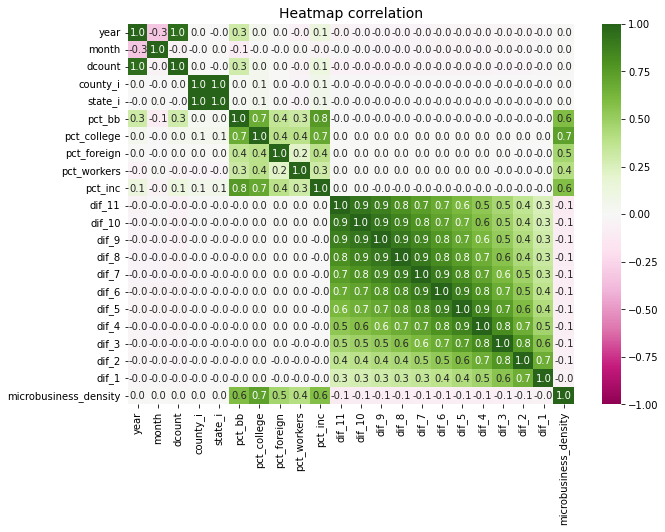

In [403]:
plt.figure(figsize = (10,7))
plt.title("Heatmap correlation", fontsize =14,loc='center')
heatmap_reg = sns.heatmap(df_pred.corr(), cmap="PiYG", robust=True,annot=True,annot_kws={'size':10},fmt=".1f",vmin=-1, vmax=1)
square=True

In [404]:
df_pred.describe()

year          month         dcount       county_i  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean     2020.692308       6.692308      19.000000    1567.000000   
std         0.991089       3.390452      11.254675     905.000202   
min      2019.000000       1.000000       0.000000       0.000000   
25%      2020.000000       4.000000       9.000000     783.000000   
50%      2021.000000       7.000000      19.000000    1567.000000   
75%      2022.000000      10.000000      29.000000    2351.000000   
max      2022.000000      12.000000      38.000000    3134.000000   

             state_i         pct_bb   pct_college    pct_foreign  \
count  122265.000000  122265.000000  122265.00000  122265.000000   
mean       26.229665      74.788855      14.13029       4.080285   
std        14.253994       9.064733       5.40431       3.561062   
min         0.000000      51.450000       0.00000       0.000000   
25%        14.000000      69.300000      10.10000       1.400000   
50%        25.000000      75.800000      13.20000       2.700000   
75%        40.000000      81.200000      17.30000       5.700000   
max        50.000000      97.100000      28.10000      12.150000   

         pct_workers        pct_inc         dif_11         dif_10  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean        1.320209   52330.531644      -0.022571      -0.021276   
std         0.815275   12544.911912       0.429236       0.419529   
min         0.000000   20188.000000      -7.839477      -7.839477   
25%         0.700000   43512.000000      -0.103849      -0.102294   
50%         1.200000   51097.000000      -0.001603      -0.001611   
75%         1.800000   59230.000000       0.067176       0.065997   
max         3.450000   82814.500000       7.919520       7.919520   

               dif_9          dif_8          dif_7          dif_6  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean       -0.020416      -0.019322      -0.017366      -0.015315   
std         0.406706       0.393225       0.376121       0.357766   
min        -7.839477      -7.839477      -7.839477      -7.839477   
25%        -0.099178      -0.094303      -0.087679      -0.080595   
50%        -0.003658      -0.003225      -0.004005      -0.002726   
75%         0.063889       0.060348       0.056802       0.052573   
max         7.919520       7.919520       7.919520       7.839477   

               dif_5          dif_4          dif_3          dif_2  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean       -0.013992      -0.012201      -0.008264      -0.005241   
std         0.333641       0.305457       0.274296       0.236925   
min        -7.839477      -7.839477      -7.839477      -7.839477   
25%        -0.072869      -0.062696      -0.051275      -0.038670   
50%        -0.002086      -0.000536       0.000000       0.000000   
75%         0.048019       0.040825       0.034971       0.027233   
max         7.839477       7.839477       7.839477       7.839477   

               dif_1  microbusiness_density  
count  122265.000000          122265.000000  
mean       -0.002682               3.378144  
std         0.179233               2.349475  
min        -7.805576               0.000000  
25%        -0.023214               1.639344  
50%         0.000000               2.586543  
75%         0.017531               4.519231  
max         7.797828               8.839061

##data features diff/target

In [405]:
X_density = df_pred.iloc[:,:-1].copy(deep=True)
y_density = df_pred["microbusiness_density"].copy(deep=True)

##Normalisation -  Robustscaler

###fit

In [406]:
#get data more normalize with RobustScaler
X_density_rs = RobustScaler().fit_transform(X_density)

###dataframe

In [407]:
df_X_density_rs = pd.DataFrame(data=X_density_rs, columns=X_density.columns, index = X_density.index)
df_X_density_rs.describe()

year          month         dcount      county_i  \
count  122265.000000  122265.000000  122265.000000  1.222650e+05   
mean       -0.153846      -0.051282       0.000000 -7.264372e-20   
std         0.495544       0.565075       0.562734  5.771685e-01   
min        -1.000000      -1.000000      -0.950000 -9.993622e-01   
25%        -0.500000      -0.500000      -0.500000 -5.000000e-01   
50%         0.000000       0.000000       0.000000  0.000000e+00   
75%         0.500000       0.500000       0.500000  5.000000e-01   
max         0.500000       0.833333       0.950000  9.993622e-01   

             state_i         pct_bb    pct_college    pct_foreign  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean        0.047295      -0.084970       0.129207       0.320997   
std         0.548231       0.761742       0.750599       0.828154   
min        -0.961538      -2.046218      -1.833333      -0.627907   
25%        -0.423077      -0.546218      -0.430556      -0.302326   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.576923       0.453782       0.569444       0.697674   
max         0.961538       1.789916       2.069444       2.197674   

         pct_workers        pct_inc         dif_11         dif_10  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean        0.109281       0.078479      -0.122604      -0.116847   
std         0.741159       0.798124       2.509786       2.492892   
min        -1.090909      -1.966472     -45.828828     -46.573541   
25%        -0.454545      -0.482568      -0.597843      -0.598266   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.545455       0.517432       0.402157       0.401734   
max         2.045455       2.017909      46.315593      47.068317   

               dif_9          dif_8          dif_7          dif_6  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean       -0.102769      -0.104086      -0.092472      -0.094528   
std         2.494099       2.542672       2.603250       2.686576   
min       -48.052642     -50.670720     -54.231661     -58.848558   
25%        -0.585771      -0.588925      -0.579131      -0.584738   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.414229       0.411075       0.420869       0.415262   
max        48.588365      51.230003      54.841111      58.889507   

               dif_5          dif_4          dif_3          dif_2  \
count  122265.000000  122265.000000  122265.000000  122265.000000   
mean       -0.098487      -0.112686      -0.095813      -0.079523   
std         2.759921       2.950687       3.180372       3.595068   
min       -64.831927     -75.723494     -90.896146    -118.954966   
25%        -0.585521      -0.600462      -0.594522      -0.586769   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.414479       0.399538       0.405478       0.413231   
max        64.866442      75.733844      90.896146     118.954966   

               dif_1  
count  122265.000000  
mean       -0.065812  
std         4.398874  
min      -191.569968  
25%        -0.569744  
50%         0.000000  
75%         0.430256  
max       191.379813

##GradientBoosting_1

###data gb

In [408]:
X_density_gb = df_X_density_rs.copy(deep=True)
y_density_gb = df_pred["microbusiness_density"].copy(deep=True)

In [409]:
X_density_gb.shape

(122265, 21)

In [410]:
df_train_new_feat_smooth.iloc[18340:122265]

row_id  cfips            county          state  \
18340    1027_2022-05-01   1027       Clay County        Alabama   
18341   31061_2022-05-01  31061   Franklin County       Nebraska   
18342   29203_2022-05-01  29203    Shannon County       Missouri   
18343    5001_2022-05-01   5001   Arkansas County       Arkansas   
18344   54079_2022-05-01  54079     Putnam County  West Virginia   
...                  ...    ...               ...            ...   
122260  46009_2019-08-01  46009  Bon Homme County   South Dakota   
122261  18159_2019-08-01  18159     Tipton County        Indiana   
122262  46007_2019-08-01  46007    Bennett County   South Dakota   
122263  18161_2019-08-01  18161      Union County        Indiana   
122264   1001_2019-08-01   1001    Autauga County        Alabama   

       first_day_of_month  microbusiness_density  active  istest  year  month  \
18340          2022-05-01               1.677725   177.0       0  2022      5   
18341          2022-05-01               2.192801    53.0       0  2022      5   
18342          2022-05-01               2.144189   138.0       0  2022      5   
18343          2022-05-01               1.715955   235.0       0  2022      5   
18344          2022-05-01               2.564511  1127.0       0  2022      5   
...                   ...                    ...     ...     ...   ...    ...   
122260         2019-08-01               0.980049    56.0       0  2019      8   
122261         2019-08-01               2.100457   253.0       0  2019      8   
122262         2019-08-01               0.585322    13.0       0  2019      8   
122263         2019-08-01               2.126509   118.0       0  2019      8   
122264         2019-08-01               3.007682  1249.0       0  2019      8   

        dcount  county_i  state_i  pct_bb  pct_college  pct_foreign  \
18340       33        13        0    72.0          7.6          1.4   
18341       33      1682       27    75.8         12.3          0.9   
18342       33      1581       25    68.3          8.7          0.4   
18343       33       109        3    71.3         10.8          0.9   
18344       33      3024       48    80.4         16.0          1.3   
...        ...       ...      ...     ...          ...          ...   
122260       0      2362       41    68.9         12.9          2.0   
122261       0       774       14    74.0         14.0          1.3   
122262       0      2361       41    62.4         14.3          0.5   
122263       0       775       14    63.9         11.7          0.5   
122264       0         0        0    76.6         14.5          2.1   

        pct_workers  pct_inc  microbusiness_density_log  active_log  \
18340           0.6  42678.0                   0.517439    5.176150   
18341           1.5  50231.0                   0.785180    3.970292   
18342           0.2  36229.0                   0.762761    4.927254   
18343           1.3  51000.0                   0.539970    5.459586   
18344           1.2  63954.0                   0.941768    7.027315   
...             ...      ...                        ...         ...   
122260          0.3  52923.0                  -0.020153    4.025352   
122261          0.8  53931.0                   0.742155    5.533389   
122262          0.9  45725.0                  -0.535593    2.564949   
122263          1.3  45531.0                   0.754482    4.770685   
122264          1.3  55317.0                   1.101170    7.130099   

        density_shift_11  density_shift_10  density_shift_9  density_shift_8  \
18340           1.458471          1.439530         1.420589         1.411118   
18341           2.222222          2.139918         2.098765         2.098765   
18342           2.151544          2.198316         2.213907         2.182725   
18343           1.737745          1.737745         1.737745         1.744986   
18344           2.605960          2.617359         2.605960         2.590000   
...                  ...               ...

In [411]:
train_start = round(X_density_gb.shape[0]*0.15)
train_start

18340

In [412]:
train_end = X_density_gb.shape[0]
train_end

122265

In [413]:
X_density_gb_train = X_density_gb.iloc[train_start:train_end]
X_density_gb_train

year     month  dcount  county_i   state_i    pct_bb  \
row_id                                                                   
1027_2022-05-01    0.5 -0.333333    0.70 -0.991071 -0.961538 -0.319328   
31061_2022-05-01   0.5 -0.333333    0.70  0.073342  0.076923  0.000000   
29203_2022-05-01   0.5 -0.333333    0.70  0.008929  0.000000 -0.630252   
5001_2022-05-01    0.5 -0.333333    0.70 -0.929847 -0.846154 -0.378151   
54079_2022-05-01   0.5 -0.333333    0.70  0.929209  0.884615  0.386555   
...                ...       ...     ...       ...       ...       ...   
46009_2019-08-01  -1.0  0.166667   -0.95  0.507015  0.615385 -0.579832   
18159_2019-08-01  -1.0  0.166667   -0.95 -0.505740 -0.423077 -0.151261   
46007_2019-08-01  -1.0  0.166667   -0.95  0.506378  0.615385 -1.126050   
18161_2019-08-01  -1.0  0.166667   -0.95 -0.505102 -0.423077 -1.000000   
1001_2019-08-01   -1.0  0.166667   -0.95 -0.999362 -0.961538  0.067227   

                  pct_college  pct_foreign  pct_workers   pct_inc    dif_11  \
row_id                                                                        
1027_2022-05-01     -0.777778    -0.302326    -0.545455 -0.535628 -1.272626   
31061_2022-05-01    -0.125000    -0.418605     0.272727 -0.055096  0.181401   
29203_2022-05-01    -0.625000    -0.534884    -0.909091 -0.945922  0.052376   
5001_2022-05-01     -0.333333    -0.418605     0.090909 -0.006171  0.136783   
54079_2022-05-01     0.388889    -0.325581     0.000000  0.817979  0.251726   
...                       ...          ...          ...       ...       ...   
46009_2019-08-01    -0.041667    -0.162791    -0.818182  0.116173  0.658343   
18159_2019-08-01     0.111111    -0.325581    -0.363636  0.180303 -0.133157   
46007_2019-08-01     0.152778    -0.511628    -0.272727 -0.341774 -0.498748   
18161_2019-08-01    -0.208333    -0.511628     0.090909 -0.354116 -3.344283   
1001_2019-08-01      0.180556    -0.139535     0.090909  0.268482  0.372818   

                    dif_10     dif_9     dif_8     dif_7     dif_6     dif_5  \
row_id                                                                         
1027_2022-05-01  -1.405808 -1.554438 -1.703076 -1.751992 -1.341498 -1.718096   
31061_2022-05-01 -0.304665 -0.554235 -0.587198  0.231357 -0.376644 -0.079784   
29203_2022-05-01  0.331205  0.449973  0.270037  0.186535  0.309855  0.078096   
5001_2022-05-01   0.139056  0.156061  0.208575 -0.021916  0.455965  0.437092   
54079_2022-05-01  0.323605  0.276613  0.185672  0.267261  0.280362  0.246966   
...                    ...       ...       ...       ...       ...       ...   
46009_2019-08-01  0.669092  0.757914  0.854192  1.013273  1.191259  1.380388   
18159_2019-08-01 -0.132118 -0.117053 -0.133335 -0.140990 -0.166557 -0.196766   
46007_2019-08-01 -0.496067 -0.367543 -0.251306 -0.255043 -0.277039 -0.310479   
18161_2019-08-01 -3.380031 -3.439622 -3.591544 -3.838925 -4.174668 -4.578781   
1001_2019-08-01   0.462100  0.557730  0.657281  0.840231  1.044450  1.271966   

                     dif_4     dif_3     dif_2      dif_1  
row_id                                                     
1027_2022-05-01  -1.734524  0.000000  0.000000  -0.232633  
31061_2022-05-01  0.404839 -0.479712 -0.627795   0.000000  
29203_2022-05-01  0.155268  0.000000  0.000000  -0.381332  
5001_2022-05-01   0.216783  0.169326  0.221596   0.537628  
54079_2022-05-01  0.356874  0.263838  0.656038   0.223390  
...                    ...       ...       ...        ...  
46009_2019-08-01  1.682722  2.063773  2.766584   4.477322  
18159_2019-08-01 -0.254088 -0.329481 -0.407251  -0.634989  
46007_2019-08-01 -0.377544 -0.459373 -0.601177  -0.972365  
18161_2019-08-01 -5.332420 -6.302956 -8.112922 -13.312420  
1001_2019-08-01   1.618353  2.006095  2.716727   4.481031  

[103925 rows x 21 columns]

In [414]:
X_density_gb_test = X_density_gb.iloc[0:train_start-1]
X_density_gb_test

year     month  dcount  county_i   state_i    pct_bb  \
row_id                                                                   
56045_2022-10-01   0.5  0.500000    0.95  0.999362  0.961538  0.327731   
55041_2022-10-01   0.5  0.500000    0.95  0.952168  0.923077  0.042017   
48291_2022-10-01   0.5  0.500000    0.95  0.699617  0.692308  0.579832   
22089_2022-10-01   0.5  0.500000    0.95 -0.262755 -0.269231  0.957983   
53009_2022-10-01   0.5  0.500000    0.95  0.882015  0.846154  0.899160   
...                ...       ...     ...       ...       ...       ...   
27137_2022-05-01   0.5 -0.333333    0.70 -0.119260 -0.076923  0.563025   
32019_2022-05-01   0.5 -0.333333    0.70  0.118622  0.115385  1.025210   
5033_2022-05-01    0.5 -0.333333    0.70 -0.919643 -0.846154  0.109244   
31095_2022-05-01   0.5 -0.333333    0.70  0.084184  0.076923 -0.268908   
13037_2022-05-01   0.5 -0.333333    0.70 -0.742347 -0.576923 -0.655462   

                  pct_college  pct_foreign  pct_workers   pct_inc    dif_11  \
row_id                                                                        
56045_2022-10-01    -0.069444    -0.093023    -1.090909  0.142257 -0.136934   
55041_2022-10-01    -0.347222    -0.441860    -0.636364 -0.171968 -0.448873   
48291_2022-10-01    -0.847222     1.534884    -0.090909 -0.011452 -0.837900   
22089_2022-10-01     1.125000     0.232558     0.000000  1.082580  0.775476   
53009_2022-10-01     0.597222     0.581395    -0.454545  0.254040 -0.252744   
...                       ...          ...          ...       ...       ...   
27137_2022-05-01     0.888889    -0.093023     0.090909  0.406095 -1.647375   
32019_2022-05-01    -0.486111     0.930233    -0.363636  0.490966 -0.148618   
5033_2022-05-01     -0.041667     0.372093     0.000000 -0.134686  0.250601   
31095_2022-05-01     0.138889     0.069767    -0.545455 -0.134623  2.788557   
13037_2022-05-01    -0.666667     0.441860    -1.090909 -0.581181 -0.242984   

                    dif_10     dif_9     dif_8     dif_7     dif_6     dif_5  \
row_id                                                                         
56045_2022-10-01  0.074368 -0.196544 -0.210040 -0.095850 -0.113597  0.164948   
55041_2022-10-01 -0.290990 -0.232414 -0.158289  0.507104  0.228517  0.017257   
48291_2022-10-01 -0.649707 -0.917649 -0.919295 -0.989536 -0.893327 -0.950151   
22089_2022-10-01  0.832950  0.728298  0.522437 -0.041551 -0.035895 -0.148333   
53009_2022-10-01 -0.361530 -0.692081 -0.722365 -0.440875 -0.286938 -0.607920   
...                    ...       ...       ...       ...       ...       ...   
27137_2022-05-01 -1.637333 -1.612727 -1.723301 -1.633651 -1.749524 -2.065607   
32019_2022-05-01  0.113953  0.245280  0.240656  0.035609  0.170005  0.570213   
5033_2022-05-01   0.129011  0.106771  0.041382  0.064339  0.076088  0.026018   
31095_2022-05-01  2.940414  3.157041  3.094301  2.449224  0.494489  0.391180   
13037_2022-05-01 -0.020171 -0.008266 -0.381576 -0.138959 -0.160369 -0.024152   

                     dif_4     dif_3     dif_2     dif_1  
row_id                                                    
56045_2022-10-01  0.177643  0.207011  0.000000  0.000000  
55041_2022-10-01  0.005175 -0.160613 -0.630579  0.000000  
48291_2022-10-01 -0.865005 -0.109943 -0.191841 -0.116357  
22089_2022-10-01 -0.526598  0.261115 -0.075936  0.061416  
53009_2022-10-01 -0.953032 -0.164305 -0.597286 -0.618287  
...                    ...       ...       ...       ...  
27137_2022-05-01 -0.054595  0.251100  0.563330  0.516320  
32019_2022-05-01 -0.369147 -0.317147 -0.345872 -0.279711  
5033_2022-05-01  -0.197516 -0.389263 -0.254713  0.205989  
31095_2022-05-01  0.005175  0.620919  0.270862  0.876211  
13037_2022-05-01  0.005175  0.000000 -0.583834 -0.944314  

[18339 rows x 21 columns]

In [415]:
y_density_gb_train=y_density_gb[train_start:train_end]
y_density_gb_train

row_id
1027_2022-05-01     1.677725
31061_2022-05-01    2.192801
29203_2022-05-01    2.144189
5001_2022-05-01     1.715955
54079_2022-05-01    2.564511
                      ...   
46009_2019-08-01    0.980049
18159_2019-08-01    2.100457
46007_2019-08-01    0.585322
18161_2019-08-01    2.126509
1001_2019-08-01     3.007682
Name: microbusiness_density, Length: 103925, dtype: float64

In [416]:
y_density_gb_test  = y_density_gb[0:train_start-1]
y_density_gb_test

row_id
56045_2022-10-01    1.785395
55041_2022-10-01    1.634575
48291_2022-10-01    2.547569
22089_2022-10-01    3.703333
53009_2022-10-01    4.997481
                      ...   
27137_2022-05-01    4.717973
32019_2022-05-01    3.220806
5033_2022-05-01     2.429812
31095_2022-05-01    2.374152
13037_2022-05-01    0.596383
Name: microbusiness_density, Length: 18339, dtype: float64

###fit & metric

In [417]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
# instanciation du modèle avec paramètre de base 
gdboost = GradientBoostingRegressor(random_state=42)
# fit model
gdboost.fit(X_density_gb_train, y_density_gb_train)

CPU times: user 1min 9s, sys: 38 ms, total: 1min 9s
Wall time: 1min 9s


GradientBoostingRegressor(random_state=42)

In [418]:
y_pred = gdboost.predict(X_density_gb_test)

In [419]:
smape(y_density_gb_test, y_pred)

28.66058645660523

##hyperparam

###1 max smape

In [420]:
#pip sklearn.metrics.scorer
#from sklearn.metrics.scorer import make_scorer
#custom_scorer = make_scorer(smape, greater_is_better=True)

In [421]:
!pip install probatus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.4/352.4 KB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.38.1-cp38-cp38-linux_x86_64.whl size=537221 sha256=3c0266cb946dc8c42745a79b0e1f5a3fcb13baf4318973a30377cb671ce80b90
  Stored in directory: /root/.cache/pip/wheels/87/7c/3f/1012132e5a8db6b4e125e64be0fd96f581803e101b0403c65f
Successfully built shap


In [422]:
from probatus.utils import Scorer
from sklearn.metrics import make_scorer

In [423]:
#scorer = Scorer('custom_metric', custom_scorer=make_scorer(smape))

In [424]:
#custom_scorer = make_scorer(smape, greater_is_better=True)

In [425]:
#%%time
# Grille de recherche de la meilleure configuration d'hyperparamètre
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
#from sklearn.model_selection import GridSearchCV

#params = [{'n_estimators':[10, 100, 700],
           #'learning_rate':[0.1,0.5],
           #'max_depth':[2, 3, 7],
           #'subsample':[.5,.75,1],
           #'random_state':[1, 18, None],
#           'min_samples_split': [2, 5, 10]}]

#grid_search = GridSearchCV(estimator = gdboost, 
                           param_grid = params, 
                           cv = 2,
                           n_jobs = -1,
                           scoring =custom_scorer)

#grid_search.fit(X_density_gb_train, y_density_gb_train)

CPU times: user 16.9 s, sys: 1.06 s, total: 18 s
Wall time: 21min 34s


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid=[{'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 100, 700]}],
             scoring=make_scorer(smape))

In [426]:
# Attribution du modèle entraîné à une variable
#gb_best_model_density= grid_search.best_estimator_

#y_pred_gdboost_best_model_density = gb_best_model_density.predict(X_density_gb_test)

#smape(y_density_gb_test, y_pred_gdboost_best_model_density)

40.347303474637116

###2 minimize smape

In [430]:
custom_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
%%time
# Grille de recherche de la meilleure configuration d'hyperparamètre
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
from sklearn.model_selection import GridSearchCV

params = [{'n_estimators':[10, 100, 700],
           'learning_rate':[0.1,0.5],
           #'max_depth':[2, 3, 7],
           #'subsample':[.5,.75,1],
           #'random_state':[1, 18, None],
           'min_samples_split': [2, 5, 10]}]

grid_search = GridSearchCV(estimator = gdboost, 
                           param_grid = params, 
                           cv = 2,
                           n_jobs = -1,
                           scoring =custom_scorer)

grid_search.fit(X_density_gb_train, y_density_gb_train)

In [ ]:
# Attribution du modèle entraîné à une variable
gb_best_model_density= grid_search.best_estimator_

y_pred_gdboost_best_model_density = gb_best_model_density.predict(X_density_gb_test)

smape(y_density_gb_test, y_pred_gdboost_best_model_density)

#

In [ ]:
SMAPE(df_pred.loc[:, "microbusiness_density"], df_pred.loc[:, "microbusiness_density"])

In [ ]:
df_pred

#Test

In [ ]:
def new_features_(df):
    for i in range (0, 11):
        df[f'density_shifty_{i}'] = df.groupby('cfips')['microbusiness_density'].shift(-i).bfill()
    return df

#def new_features1(df, col) :
#  for i in df.cfips.unique(): 
#    for k in range(len(col)-1, -1, -1):
#      median_density = df[df["cfips"]==i].loc[:, col[k]].median()
#      df.loc[(df["cfips"]==i) & (df[col[k]].isnull()), col[k]] = median_density
#  return df

def new_features2_(df):
    for i in range (0, 11):
        df[f'rat_{i}'] = (df['microbusiness_density']/df[f'density_shifty_{i}']).fillna(1).clip(0,None)-1
    return df

In [ ]:
df_train_feat_smooth_1 = df_train_smoothy.copy(deep=True)
#df_train_feat_smooth_1.sort_values(by='first_day_of_month', ascending=False, inplace=True)
#df_train_feat_smooth_1.reset_index(drop=True, inplace=True)

In [ ]:
%%time
df_train_feat_smooth_1_ = new_features_(df_train_feat_smooth_1)

CPU times: user 44.9 ms, sys: 4.99 ms, total: 49.9 ms
Wall time: 56.8 ms


In [ ]:
%%time
df_train_new_feat_smooth_2_ = new_features2_(df_train_feat_smooth_1_)

CPU times: user 20.1 ms, sys: 4.99 ms, total: 25.1 ms
Wall time: 26.5 ms


In [ ]:
df_train_new_feat_smooth_2_.isna().sum()

row_id                    0
cfips                     0
county                    0
state                     0
first_day_of_month        0
microbusiness_density     0
active                    0
istest                    0
year                      0
month                     0
dcount                    0
county_i                  0
state_i                   0
pct_bb                    0
pct_college               0
pct_foreign               0
pct_workers               0
pct_inc                   0
density_shifty_0          0
density_shifty_1          1
density_shifty_2          2
density_shifty_3          3
density_shifty_4          4
density_shifty_5          5
density_shifty_6          6
density_shifty_7          7
density_shifty_8          8
density_shifty_9          9
density_shifty_10        10
rat_0                     0
rat_1                     0
rat_2                     0
rat_3                     0
rat_4                     0
rat_5                     0
rat_6               

In [ ]:
SMAPE(df_train_new_feat_smooth_2_.loc[:, "microbusiness_density"], df_train_new_feat_smooth_2_.loc[:, "rat_1"])

197.16297848044957

In [ ]:
SMAPE(df_train_new_feat_smooth.loc[:, "microbusiness_density"], df_train_new_feat_smooth.loc[:, "density_shift_11"])


6.685621413447618

In [ ]:
df_train_new_feat_smooth

row_id  cfips              county         state  \
0       56045_2022-10-01  56045       Weston County       Wyoming   
1       55041_2022-10-01  55041       Forest County     Wisconsin   
2       48291_2022-10-01  48291      Liberty County         Texas   
3       22089_2022-10-01  22089  St. Charles Parish     Louisiana   
4       53009_2022-10-01  53009      Clallam County    Washington   
...                  ...    ...                 ...           ...   
122260  46009_2019-08-01  46009    Bon Homme County  South Dakota   
122261  18159_2019-08-01  18159       Tipton County       Indiana   
122262  46007_2019-08-01  46007      Bennett County  South Dakota   
122263  18161_2019-08-01  18161        Union County       Indiana   
122264   1001_2019-08-01   1001      Autauga County       Alabama   

       first_day_of_month  microbusiness_density  active  istest  year  month  \
0              2022-10-01               1.785395   100.0       0  2022     10   
1              2022-10-01               1.634575   118.0       0  2022     10   
2              2022-10-01               2.547569  1612.0       0  2022     10   
3              2022-10-01               3.703333  1480.0       0  2022     10   
4              2022-10-01               4.997481  3174.0       0  2022     10   
...                   ...                    ...     ...     ...   ...    ...   
122260         2019-08-01               0.980049    56.0       0  2019      8   
122261         2019-08-01               2.100457   253.0       0  2019      8   
122262         2019-08-01               0.585322    13.0       0  2019      8   
122263         2019-08-01               2.126509   118.0       0  2019      8   
122264         2019-08-01               3.007682  1249.0       0  2019      8   

        dcount  county_i  state_i  pct_bb  pct_college  pct_foreign  \
0           38      3134       50    79.7         12.7          2.3   
1           38      3060       49    76.3         10.7          0.8   
2           38      2664       43    82.7          7.1          9.3   
3           38      1155       18    87.2         21.3          3.7   
4           38      2950       47    86.5         17.5          5.2   
...        ...       ...      ...     ...          ...          ...   
122260       0      2362       41    68.9         12.9          2.0   
122261       0       774       14    74.0         14.0          1.3   
122262       0      2361       41    62.4         14.3          0.5   
122263       0       775       14    63.9         11.7          0.5   
122264       0         0        0    76.6         14.5          2.1   

        pct_workers  pct_inc  density_shift_11  density_shift_10  \
0               0.0  53333.0          1.760374          1.796300   
1               0.5  48394.0          1.556204          1.583993   
2               1.1  50917.0          2.402665          2.436619   
3               1.2  68113.0          3.834356          3.841899   
4               0.7  55090.0          4.952653          4.935028   
...             ...      ...               ...               ...   
122260          0.3  52923.0          1.091039          1.091039   
122261          0.8  53931.0          2.076081          2.076611   
122262          0.9  45725.0          0.498421          0.500227   
122263          1.3  45531.0          1.552951          1.556072   
122264          1.3  55317.0          3.069840          3.083837   

        density_shift_9  density_shift_8  density_shift_7  density_shift_6  \
0              1.749688         1.749688         1.767542         1.767542   
1              1.593018         1.606871         1.703837         1.662280   
2              2.394273         2.402175         2.400594         2.425880   
3              3.818437         3.780903         3.693324         3.695826   
4              4.880967         4.882542         4.929777         4.956543   
...                 ...              ...              ...              ...   
